## Create bottlenecks

In [ ]:
%run lz_producebottlenecks.py

## Train on the bottleneck files

In [12]:
#%%writefile lz_classifier.py


import tensorflow as tf
import sys
import math
import os
import numpy as np
import json
import argparse
import re
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.python.platform import gfile
from progress.bar import Bar

slim = tf.contrib.slim

bottleneck_dir = 'VG_PPG_1s_bottlenecks'


### LOAD DATA FROM BOTTLENECKS
data_inputs = []
data_labels = []

bottleneck_list = []
file_glob = os.path.join(bottleneck_dir, '*.txt')
bottleneck_list.extend(gfile.Glob(file_glob))
shuffle(bottleneck_list, random_state = 1)

for bottleneck_file in bottleneck_list:
    
    bottleneck = open(bottleneck_file)
    bottleneck_string = bottleneck.read()
    bottleneck_values = [float(x) for x in bottleneck_string.split(',')]
    
    data_inputs.append(bottleneck_values)
    regex = re.compile(r'\d+')
    labels = regex.findall(bottleneck_file)
    SBP_label = int(labels[-2])
    DBP_label = int(labels[-1])        
    data_labels.append([int(SBP_label), int(DBP_label)])
    
train_inputs, valtest_inputs, train_labels, valtest_labels = train_test_split(data_inputs, data_labels, test_size=0.2, random_state=1)
val_inputs, test_inputs, val_labels, test_labels = train_test_split(valtest_inputs, valtest_labels, test_size=0.9, random_state=2)

# Setting hyperparameters
learning_rate = 0.0005
batch_size = 64
epochs = 2500
log_batch_step = 50

# useful info
n_features = np.size(train_inputs, 1)
n_labels = np.size(train_labels, 1)

tf.reset_default_graph()
graph = tf.get_default_graph()

# Placeholders for input features and labels
inputs = tf.placeholder(tf.float32, (None, n_features), name='inputs')
labels = tf.placeholder(tf.float32, (None, n_labels), name='labels')
label_SBP, label_DBP = tf.split(labels, 2, 1)

# Setting up weights and bias
weights = tf.Variable(tf.truncated_normal((n_features, n_labels), stddev=0.1), name='weights')
bias = tf.Variable(tf.zeros(n_labels), name='bias')
tf.summary.histogram('weightshist', weights)
tf.summary.histogram('biashist', bias)

# Setting up operation in fully connected layer
predictions = tf.add(tf.matmul(inputs, weights), bias)
pred_SBP, pred_DBP = tf.split(predictions, 2, 1)

# Defining loss of network
mean_squared_error_SBP = tf.losses.mean_squared_error(pred_SBP, label_SBP)
mean_squared_error_DBP = tf.losses.mean_squared_error(pred_DBP, label_DBP)
total_loss = mean_squared_error_SBP + mean_squared_error_DBP

tf.summary.scalar('loss', total_loss)

# Setting optimiser
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)

# For saving checkpoint after training
saver = tf.train.Saver()

merged = tf.summary.merge_all()

# use in command line: tensorboard --logdir=path/to/log  --> to view tensorboard

# Run tensorflow session
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    train_writer = tf.summary.FileWriter('log', sess.graph)
    tf.train.write_graph(sess.graph_def, '', 'savedgraph.pbtxt', as_text=False)
    
    # Running the training in batches 
    batch_count = int(math.ceil(len(train_inputs)/batch_size))
    
    for epoch_i in range(epochs):
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_inputs = train_inputs[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]
            # Run optimizer
            _, summary = sess.run([optimizer, merged], feed_dict={inputs: batch_inputs, labels: batch_labels})
            train_writer.add_summary(summary, batch_i)
            
        # Check mean sqaure error against validation data
        val_MSR_SBP,val_MSR_DBP,val_total_loss = sess.run([mean_squared_error_SBP,mean_squared_error_DBP,total_loss], feed_dict={inputs: val_inputs, labels: val_labels})
        print("After epoch {}, MSR_SBP: {}, MSR_DBP: {}, Total Loss: {}.".format(epoch_i+1, val_MSR_SBP,val_MSR_DBP,val_total_loss))
            
    test_MSR_SBP,test_MSR_DBP,test_total_loss = sess.run([mean_squared_error_SBP,mean_squared_error_DBP,total_loss], feed_dict={inputs: test_inputs, labels: test_labels})
    print ("Test MSR_SBP: {}, Test MSR_DBP: {}, Test Total Loss: {}.".format(test_MSR_SBP,test_MSR_DBP,test_total_loss))
    
    test_predictions = sess.run([predictions], feed_dict={inputs: test_inputs, labels: test_labels})
    
    g = tf.get_default_graph()
    saver.save(sess, 'savedgraph')
    
    #print ("predictions: {}".format(test_predictions))
            

Epoch  3/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1, MSR_SBP: 15310.837890625, MSR_DBP: 4435.58203125, Total Loss: 19746.419921875.
After epoch 2, MSR_SBP: 13762.5244140625, MSR_DBP: 3627.935546875, Total Loss: 17390.4609375.


Epoch  5/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 3, MSR_SBP: 12336.0498046875, MSR_DBP: 2936.0, Total Loss: 15272.0498046875.
After epoch 4, MSR_SBP: 11029.5126953125, MSR_DBP: 2352.967041015625, Total Loss: 13382.4794921875.


Epoch  7/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 5, MSR_SBP: 9837.513671875, MSR_DBP: 1868.2724609375, Total Loss: 11705.7861328125.
After epoch 6, MSR_SBP: 8753.802734375, MSR_DBP: 1470.6263427734375, Total Loss: 10224.4287109375.


Epoch  9/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 7, MSR_SBP: 7771.9990234375, MSR_DBP: 1148.89697265625, Total Loss: 8920.896484375.
After epoch 8, MSR_SBP: 6885.75537109375, MSR_DBP: 892.41259765625, Total Loss: 7778.16796875.


Epoch 12/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 9, MSR_SBP: 6088.79150390625, MSR_DBP: 691.1351318359375, Total Loss: 6779.9267578125.
After epoch 10, MSR_SBP: 5374.92578125, MSR_DBP: 535.8029174804688, Total Loss: 5910.728515625.
After epoch 11, MSR_SBP: 4738.09814453125, MSR_DBP: 418.03814697265625, Total Loss: 5156.13623046875.


Epoch 14/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 12, MSR_SBP: 4172.39111328125, MSR_DBP: 330.42303466796875, Total Loss: 4502.81396484375.
After epoch 13, MSR_SBP: 3672.056884765625, MSR_DBP: 266.5343933105469, Total Loss: 3938.59130859375.


Epoch 16/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 14, MSR_SBP: 3231.53564453125, MSR_DBP: 220.93618774414062, Total Loss: 3452.471923828125.
After epoch 15, MSR_SBP: 2845.48193359375, MSR_DBP: 189.13629150390625, Total Loss: 3034.6181640625.


Epoch 18/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 16, MSR_SBP: 2508.782958984375, MSR_DBP: 167.5111083984375, Total Loss: 2676.2939453125.
After epoch 17, MSR_SBP: 2216.573974609375, MSR_DBP: 153.20867919921875, Total Loss: 2369.78271484375.


Epoch 20/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 18, MSR_SBP: 1964.260498046875, MSR_DBP: 144.0403289794922, Total Loss: 2108.30078125.
After epoch 19, MSR_SBP: 1747.5238037109375, MSR_DBP: 138.36851501464844, Total Loss: 1885.892333984375.


Epoch 22/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 20, MSR_SBP: 1562.3343505859375, MSR_DBP: 135.0003204345703, Total Loss: 1697.334716796875.
After epoch 21, MSR_SBP: 1404.9566650390625, MSR_DBP: 133.0901641845703, Total Loss: 1538.046875.


Epoch 24/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 22, MSR_SBP: 1271.952392578125, MSR_DBP: 132.0559844970703, Total Loss: 1404.0084228515625.
After epoch 23, MSR_SBP: 1160.1767578125, MSR_DBP: 131.51022338867188, Total Loss: 1291.68701171875.


Epoch 26/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 24, MSR_SBP: 1066.77587890625, MSR_DBP: 131.20401000976562, Total Loss: 1197.9798583984375.
After epoch 25, MSR_SBP: 989.1787719726562, MSR_DBP: 130.9850616455078, Total Loss: 1120.163818359375.


Epoch 28/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 26, MSR_SBP: 925.0853271484375, MSR_DBP: 130.76565551757812, Total Loss: 1055.8509521484375.
After epoch 27, MSR_SBP: 872.4526977539062, MSR_DBP: 130.49998474121094, Total Loss: 1002.9526977539062.


Epoch 31/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 28, MSR_SBP: 829.4827880859375, MSR_DBP: 130.16827392578125, Total Loss: 959.6510620117188.
After epoch 29, MSR_SBP: 794.6015625, MSR_DBP: 129.76573181152344, Total Loss: 924.3673095703125.
After epoch 30, MSR_SBP: 766.444580078125, MSR_DBP: 129.29615783691406, Total Loss: 895.74072265625.


Epoch 34/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 31, MSR_SBP: 743.8367309570312, MSR_DBP: 128.7668914794922, Total Loss: 872.6036376953125.
After epoch 32, MSR_SBP: 725.773681640625, MSR_DBP: 128.18675231933594, Total Loss: 853.96044921875.
After epoch 33, MSR_SBP: 711.4041137695312, MSR_DBP: 127.56427001953125, Total Loss: 838.9683837890625.


Epoch 36/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 34, MSR_SBP: 700.012451171875, MSR_DBP: 126.90724182128906, Total Loss: 826.919677734375.
After epoch 35, MSR_SBP: 691.0015869140625, MSR_DBP: 126.22209930419922, Total Loss: 817.2236938476562.


Epoch 39/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 36, MSR_SBP: 683.8767700195312, MSR_DBP: 125.51425170898438, Total Loss: 809.3909912109375.
After epoch 37, MSR_SBP: 678.2323608398438, MSR_DBP: 124.78809356689453, Total Loss: 803.0204467773438.
After epoch 38, MSR_SBP: 673.7374877929688, MSR_DBP: 124.04705047607422, Total Loss: 797.7845458984375.


Epoch 42/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 39, MSR_SBP: 670.125732421875, MSR_DBP: 123.2936782836914, Total Loss: 793.41943359375.
After epoch 40, MSR_SBP: 667.1829223632812, MSR_DBP: 122.53022766113281, Total Loss: 789.713134765625.
After epoch 41, MSR_SBP: 664.740234375, MSR_DBP: 121.75811767578125, Total Loss: 786.4983520507812.


Epoch 45/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 42, MSR_SBP: 662.6638793945312, MSR_DBP: 120.97850799560547, Total Loss: 783.6423950195312.
After epoch 43, MSR_SBP: 660.8504638671875, MSR_DBP: 120.19261932373047, Total Loss: 781.0430908203125.
After epoch 44, MSR_SBP: 659.2206420898438, MSR_DBP: 119.40100860595703, Total Loss: 778.6216430664062.


Epoch 48/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 45, MSR_SBP: 657.7129516601562, MSR_DBP: 118.6043930053711, Total Loss: 776.3173217773438.
After epoch 46, MSR_SBP: 656.2823486328125, MSR_DBP: 117.80328369140625, Total Loss: 774.0856323242188.
After epoch 47, MSR_SBP: 654.8950805664062, MSR_DBP: 116.99819946289062, Total Loss: 771.893310546875.


Epoch 51/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 48, MSR_SBP: 653.5267944335938, MSR_DBP: 116.18942260742188, Total Loss: 769.7161865234375.
After epoch 49, MSR_SBP: 652.1597290039062, MSR_DBP: 115.37725830078125, Total Loss: 767.5369873046875.
After epoch 50, MSR_SBP: 650.7820434570312, MSR_DBP: 114.56209564208984, Total Loss: 765.3441162109375.


Epoch 54/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 51, MSR_SBP: 649.3855590820312, MSR_DBP: 113.74430847167969, Total Loss: 763.1298828125.
After epoch 52, MSR_SBP: 647.965087890625, MSR_DBP: 112.92399597167969, Total Loss: 760.8890991210938.
After epoch 53, MSR_SBP: 646.5181884765625, MSR_DBP: 112.10161590576172, Total Loss: 758.6198120117188.


Epoch 57/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 54, MSR_SBP: 645.0430297851562, MSR_DBP: 111.27727508544922, Total Loss: 756.3203125.
After epoch 55, MSR_SBP: 643.5392456054688, MSR_DBP: 110.45143127441406, Total Loss: 753.9906616210938.
After epoch 56, MSR_SBP: 642.0073852539062, MSR_DBP: 109.62417602539062, Total Loss: 751.631591796875.


Epoch 60/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 57, MSR_SBP: 640.4484252929688, MSR_DBP: 108.79574584960938, Total Loss: 749.244140625.
After epoch 58, MSR_SBP: 638.8630981445312, MSR_DBP: 107.96646881103516, Total Loss: 746.82958984375.
After epoch 59, MSR_SBP: 637.2525024414062, MSR_DBP: 107.13658905029297, Total Loss: 744.3890991210938.


Epoch 63/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 60, MSR_SBP: 635.618408203125, MSR_DBP: 106.30622863769531, Total Loss: 741.9246215820312.
After epoch 61, MSR_SBP: 633.9614868164062, MSR_DBP: 105.47563171386719, Total Loss: 739.4371337890625.
After epoch 62, MSR_SBP: 632.2830810546875, MSR_DBP: 104.6451644897461, Total Loss: 736.92822265625.


Epoch 65/2500: 100%|██████████| 19/19 [00:00<00:00, 190.44batches/s]

After epoch 63, MSR_SBP: 630.584716796875, MSR_DBP: 103.81491088867188, Total Loss: 734.399658203125.
After epoch 64, MSR_SBP: 628.866943359375, MSR_DBP: 102.98516845703125, Total Loss: 731.8521118164062.



Epoch 68/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 65, MSR_SBP: 627.1309204101562, MSR_DBP: 102.15602111816406, Total Loss: 729.2869262695312.
After epoch 66, MSR_SBP: 625.37744140625, MSR_DBP: 101.3277359008789, Total Loss: 726.7052001953125.
After epoch 67, MSR_SBP: 623.6068115234375, MSR_DBP: 100.50065612792969, Total Loss: 724.1074829101562.


Epoch 70/2500: 100%|██████████| 19/19 [00:00<00:00, 208.41batches/s]


After epoch 68, MSR_SBP: 621.8203125, MSR_DBP: 99.67478942871094, Total Loss: 721.4951171875.
After epoch 69, MSR_SBP: 620.0177612304688, MSR_DBP: 98.85037231445312, Total Loss: 718.8681640625.


Epoch 73/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 70, MSR_SBP: 618.200439453125, MSR_DBP: 98.02767944335938, Total Loss: 716.2281494140625.
After epoch 71, MSR_SBP: 616.36865234375, MSR_DBP: 97.20687103271484, Total Loss: 713.5755004882812.
After epoch 72, MSR_SBP: 614.5227661132812, MSR_DBP: 96.38803100585938, Total Loss: 710.9107666015625.


Epoch 76/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 73, MSR_SBP: 612.662841796875, MSR_DBP: 95.57145690917969, Total Loss: 708.2343139648438.
After epoch 74, MSR_SBP: 610.7899169921875, MSR_DBP: 94.75724792480469, Total Loss: 705.5471801757812.
After epoch 75, MSR_SBP: 608.9036865234375, MSR_DBP: 93.9455795288086, Total Loss: 702.8492431640625.


Epoch 78/2500: 100%|██████████| 19/19 [00:00<00:00, 224.62batches/s]


After epoch 76, MSR_SBP: 607.0048217773438, MSR_DBP: 93.13672637939453, Total Loss: 700.1415405273438.
After epoch 77, MSR_SBP: 605.093505859375, MSR_DBP: 92.3306655883789, Total Loss: 697.4241943359375.


Epoch 81/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 78, MSR_SBP: 603.169921875, MSR_DBP: 91.52777862548828, Total Loss: 694.6976928710938.
After epoch 79, MSR_SBP: 601.2343139648438, MSR_DBP: 90.7280502319336, Total Loss: 691.9623413085938.
After epoch 80, MSR_SBP: 599.2872924804688, MSR_DBP: 89.931640625, Total Loss: 689.2189331054688.


Epoch 84/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 81, MSR_SBP: 597.328369140625, MSR_DBP: 89.1387710571289, Total Loss: 686.4671630859375.
After epoch 82, MSR_SBP: 595.3584594726562, MSR_DBP: 88.34955596923828, Total Loss: 683.7080078125.
After epoch 83, MSR_SBP: 593.3775634765625, MSR_DBP: 87.56412506103516, Total Loss: 680.9417114257812.


Epoch 87/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 84, MSR_SBP: 591.3860473632812, MSR_DBP: 86.78263854980469, Total Loss: 678.168701171875.
After epoch 85, MSR_SBP: 589.3837280273438, MSR_DBP: 86.00523376464844, Total Loss: 675.3889770507812.
After epoch 86, MSR_SBP: 587.3712158203125, MSR_DBP: 85.23191833496094, Total Loss: 672.6031494140625.


Epoch 90/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 87, MSR_SBP: 585.3480834960938, MSR_DBP: 84.46302795410156, Total Loss: 669.8110961914062.
After epoch 88, MSR_SBP: 583.3156127929688, MSR_DBP: 83.6985092163086, Total Loss: 667.0140991210938.
After epoch 89, MSR_SBP: 581.2730102539062, MSR_DBP: 82.93860626220703, Total Loss: 664.2116088867188.


Epoch 92/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 90, MSR_SBP: 579.22119140625, MSR_DBP: 82.18331909179688, Total Loss: 661.404541015625.
After epoch 91, MSR_SBP: 577.1600952148438, MSR_DBP: 81.43285369873047, Total Loss: 658.5929565429688.


Epoch 94/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 92, MSR_SBP: 575.0897827148438, MSR_DBP: 80.6872329711914, Total Loss: 655.7770385742188.
After epoch 93, MSR_SBP: 573.0105590820312, MSR_DBP: 79.94659423828125, Total Loss: 652.9571533203125.


Epoch 96/2500:  84%|████████▍ | 16/19 [00:00<00:00, 151.74batches/s]

After epoch 94, MSR_SBP: 570.9230346679688, MSR_DBP: 79.21112823486328, Total Loss: 650.1341552734375.
After epoch 95, MSR_SBP: 568.826904296875, MSR_DBP: 78.48075866699219, Total Loss: 647.3076782226562.


Epoch 99/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 96, MSR_SBP: 566.7225341796875, MSR_DBP: 77.7557144165039, Total Loss: 644.478271484375.
After epoch 97, MSR_SBP: 564.6103515625, MSR_DBP: 77.0359878540039, Total Loss: 641.6463623046875.
After epoch 98, MSR_SBP: 562.4900512695312, MSR_DBP: 76.3218002319336, Total Loss: 638.8118286132812.


Epoch 102/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 99, MSR_SBP: 560.3621215820312, MSR_DBP: 75.613037109375, Total Loss: 635.9751586914062.
After epoch 100, MSR_SBP: 558.2273559570312, MSR_DBP: 74.91000366210938, Total Loss: 633.1373291015625.
After epoch 101, MSR_SBP: 556.0853271484375, MSR_DBP: 74.21257019042969, Total Loss: 630.2979125976562.


Epoch 105/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 102, MSR_SBP: 553.9364013671875, MSR_DBP: 73.52094268798828, Total Loss: 627.4573364257812.
After epoch 103, MSR_SBP: 551.781005859375, MSR_DBP: 72.83512878417969, Total Loss: 624.6161499023438.
After epoch 104, MSR_SBP: 549.618896484375, MSR_DBP: 72.15518951416016, Total Loss: 621.7741088867188.


Epoch 108/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 105, MSR_SBP: 547.4505615234375, MSR_DBP: 71.48123168945312, Total Loss: 618.9317626953125.
After epoch 106, MSR_SBP: 545.2767333984375, MSR_DBP: 70.81330871582031, Total Loss: 616.0900268554688.
After epoch 107, MSR_SBP: 543.0967407226562, MSR_DBP: 70.15138244628906, Total Loss: 613.2481079101562.


Epoch 111/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 108, MSR_SBP: 540.9113159179688, MSR_DBP: 69.49565887451172, Total Loss: 610.406982421875.
After epoch 109, MSR_SBP: 538.720703125, MSR_DBP: 68.84605407714844, Total Loss: 607.5667724609375.
After epoch 110, MSR_SBP: 536.52490234375, MSR_DBP: 68.20272064208984, Total Loss: 604.7276000976562.


Epoch 114/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 111, MSR_SBP: 534.32470703125, MSR_DBP: 67.56556701660156, Total Loss: 601.8902587890625.
After epoch 112, MSR_SBP: 532.1196899414062, MSR_DBP: 66.93476867675781, Total Loss: 599.054443359375.
After epoch 113, MSR_SBP: 529.9100341796875, MSR_DBP: 66.3102798461914, Total Loss: 596.2203369140625.


Epoch 117/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 114, MSR_SBP: 527.6968383789062, MSR_DBP: 65.69218444824219, Total Loss: 593.3890380859375.
After epoch 115, MSR_SBP: 525.479248046875, MSR_DBP: 65.08050537109375, Total Loss: 590.5597534179688.
After epoch 116, MSR_SBP: 523.25830078125, MSR_DBP: 64.47520446777344, Total Loss: 587.7335205078125.


Epoch 120/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 117, MSR_SBP: 521.033935546875, MSR_DBP: 63.876426696777344, Total Loss: 584.9103393554688.
After epoch 118, MSR_SBP: 518.8062744140625, MSR_DBP: 63.28410339355469, Total Loss: 582.0903930664062.
After epoch 119, MSR_SBP: 516.5759887695312, MSR_DBP: 62.69823455810547, Total Loss: 579.2742309570312.


Epoch 123/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 120, MSR_SBP: 514.3427734375, MSR_DBP: 62.118892669677734, Total Loss: 576.461669921875.
After epoch 121, MSR_SBP: 512.1072387695312, MSR_DBP: 61.54610061645508, Total Loss: 573.6533203125.
After epoch 122, MSR_SBP: 509.86968994140625, MSR_DBP: 60.97983169555664, Total Loss: 570.8495483398438.


Epoch 126/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 123, MSR_SBP: 507.6299133300781, MSR_DBP: 60.420108795166016, Total Loss: 568.050048828125.
After epoch 124, MSR_SBP: 505.38861083984375, MSR_DBP: 59.867000579833984, Total Loss: 565.255615234375.
After epoch 125, MSR_SBP: 503.1455993652344, MSR_DBP: 59.320369720458984, Total Loss: 562.4659423828125.


Epoch 128/2500:  79%|███████▉  | 15/19 [00:00<00:00, 144.44batches/s]

After epoch 126, MSR_SBP: 500.90167236328125, MSR_DBP: 58.78032302856445, Total Loss: 559.6820068359375.
After epoch 127, MSR_SBP: 498.65655517578125, MSR_DBP: 58.24681854248047, Total Loss: 556.9033813476562.


Epoch 130/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 128, MSR_SBP: 496.41094970703125, MSR_DBP: 57.71992874145508, Total Loss: 554.130859375.
After epoch 129, MSR_SBP: 494.16461181640625, MSR_DBP: 57.19949722290039, Total Loss: 551.3641357421875.


Epoch 133/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 130, MSR_SBP: 491.91802978515625, MSR_DBP: 56.685638427734375, Total Loss: 548.6036376953125.
After epoch 131, MSR_SBP: 489.6717834472656, MSR_DBP: 56.178340911865234, Total Loss: 545.85009765625.
After epoch 132, MSR_SBP: 487.4251708984375, MSR_DBP: 55.677513122558594, Total Loss: 543.1026611328125.


Epoch 136/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 133, MSR_SBP: 485.1796875, MSR_DBP: 55.183162689208984, Total Loss: 540.3628540039062.
After epoch 134, MSR_SBP: 482.93438720703125, MSR_DBP: 54.69533920288086, Total Loss: 537.6296997070312.
After epoch 135, MSR_SBP: 480.6901550292969, MSR_DBP: 54.21398162841797, Total Loss: 534.9041137695312.


Epoch 139/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 136, MSR_SBP: 478.4473876953125, MSR_DBP: 53.73906326293945, Total Loss: 532.1864624023438.
After epoch 137, MSR_SBP: 476.205810546875, MSR_DBP: 53.27055358886719, Total Loss: 529.4763793945312.
After epoch 138, MSR_SBP: 473.96624755859375, MSR_DBP: 52.808406829833984, Total Loss: 526.774658203125.


Epoch 142/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 139, MSR_SBP: 471.7283935546875, MSR_DBP: 52.35271453857422, Total Loss: 524.0811157226562.
After epoch 140, MSR_SBP: 469.4926452636719, MSR_DBP: 51.903297424316406, Total Loss: 521.3959350585938.
After epoch 141, MSR_SBP: 467.2592468261719, MSR_DBP: 51.46016311645508, Total Loss: 518.7194213867188.


Epoch 145/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 142, MSR_SBP: 465.02862548828125, MSR_DBP: 51.0233039855957, Total Loss: 516.0519409179688.
After epoch 143, MSR_SBP: 462.80084228515625, MSR_DBP: 50.592735290527344, Total Loss: 513.3935546875.
After epoch 144, MSR_SBP: 460.576171875, MSR_DBP: 50.16830062866211, Total Loss: 510.7444763183594.


Epoch 148/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 145, MSR_SBP: 458.354736328125, MSR_DBP: 49.75008773803711, Total Loss: 508.1048278808594.
After epoch 146, MSR_SBP: 456.136962890625, MSR_DBP: 49.33796310424805, Total Loss: 505.47491455078125.
After epoch 147, MSR_SBP: 453.9231262207031, MSR_DBP: 48.93197250366211, Total Loss: 502.8551025390625.


Epoch 150/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 148, MSR_SBP: 451.71331787109375, MSR_DBP: 48.53191375732422, Total Loss: 500.2452392578125.
After epoch 149, MSR_SBP: 449.5075988769531, MSR_DBP: 48.13794708251953, Total Loss: 497.6455383300781.


Epoch 152/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 150, MSR_SBP: 447.30682373046875, MSR_DBP: 47.749881744384766, Total Loss: 495.05670166015625.
After epoch 151, MSR_SBP: 445.11016845703125, MSR_DBP: 47.3677978515625, Total Loss: 492.47796630859375.


Epoch 155/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 152, MSR_SBP: 442.91876220703125, MSR_DBP: 46.991485595703125, Total Loss: 489.9102478027344.
After epoch 153, MSR_SBP: 440.7323913574219, MSR_DBP: 46.621028900146484, Total Loss: 487.3534240722656.
After epoch 154, MSR_SBP: 438.5516662597656, MSR_DBP: 46.256309509277344, Total Loss: 484.8079833984375.


Epoch 158/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 155, MSR_SBP: 436.3766174316406, MSR_DBP: 45.897315979003906, Total Loss: 482.27392578125.
After epoch 156, MSR_SBP: 434.20709228515625, MSR_DBP: 45.54393005371094, Total Loss: 479.75103759765625.
After epoch 157, MSR_SBP: 432.0439758300781, MSR_DBP: 45.196205139160156, Total Loss: 477.24017333984375.


Epoch 161/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 158, MSR_SBP: 429.886962890625, MSR_DBP: 44.85397720336914, Total Loss: 474.7409362792969.
After epoch 159, MSR_SBP: 427.7364501953125, MSR_DBP: 44.51725769042969, Total Loss: 472.25372314453125.
After epoch 160, MSR_SBP: 425.5926818847656, MSR_DBP: 44.18598175048828, Total Loss: 469.7786560058594.


Epoch 164/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 161, MSR_SBP: 423.4560852050781, MSR_DBP: 43.86008071899414, Total Loss: 467.316162109375.
After epoch 162, MSR_SBP: 421.326171875, MSR_DBP: 43.53950500488281, Total Loss: 464.86566162109375.
After epoch 163, MSR_SBP: 419.203857421875, MSR_DBP: 43.2241096496582, Total Loss: 462.427978515625.


Epoch 167/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 164, MSR_SBP: 417.08905029296875, MSR_DBP: 42.91402816772461, Total Loss: 460.0030822753906.
After epoch 165, MSR_SBP: 414.9819030761719, MSR_DBP: 42.609039306640625, Total Loss: 457.5909423828125.
After epoch 166, MSR_SBP: 412.8825988769531, MSR_DBP: 42.30915832519531, Total Loss: 455.1917724609375.


Epoch 170/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 167, MSR_SBP: 410.79180908203125, MSR_DBP: 42.0142707824707, Total Loss: 452.80609130859375.
After epoch 168, MSR_SBP: 408.70904541015625, MSR_DBP: 41.72434997558594, Total Loss: 450.43341064453125.
After epoch 169, MSR_SBP: 406.6348571777344, MSR_DBP: 41.439308166503906, Total Loss: 448.07415771484375.


Epoch 173/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 170, MSR_SBP: 404.5693054199219, MSR_DBP: 41.159114837646484, Total Loss: 445.7284240722656.
After epoch 171, MSR_SBP: 402.5127258300781, MSR_DBP: 40.883705139160156, Total Loss: 443.39642333984375.
After epoch 172, MSR_SBP: 400.4650573730469, MSR_DBP: 40.61296081542969, Total Loss: 441.0780029296875.


Epoch 176/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 173, MSR_SBP: 398.42694091796875, MSR_DBP: 40.34688186645508, Total Loss: 438.7738342285156.
After epoch 174, MSR_SBP: 396.3980407714844, MSR_DBP: 40.085391998291016, Total Loss: 436.4834289550781.
After epoch 175, MSR_SBP: 394.3786926269531, MSR_DBP: 39.82838439941406, Total Loss: 434.20709228515625.


Epoch 178/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 176, MSR_SBP: 392.36920166015625, MSR_DBP: 39.575870513916016, Total Loss: 431.945068359375.
After epoch 177, MSR_SBP: 390.3696594238281, MSR_DBP: 39.327720642089844, Total Loss: 429.6973876953125.


Epoch 180/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 178, MSR_SBP: 388.3802185058594, MSR_DBP: 39.08389663696289, Total Loss: 427.464111328125.
After epoch 179, MSR_SBP: 386.40081787109375, MSR_DBP: 38.84431457519531, Total Loss: 425.2451171875.


Epoch 182/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 180, MSR_SBP: 384.43194580078125, MSR_DBP: 38.60896682739258, Total Loss: 423.0409240722656.
After epoch 181, MSR_SBP: 382.4736022949219, MSR_DBP: 38.37767791748047, Total Loss: 420.8512878417969.


Epoch 184/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 182, MSR_SBP: 380.52618408203125, MSR_DBP: 38.150489807128906, Total Loss: 418.6766662597656.
After epoch 183, MSR_SBP: 378.5893249511719, MSR_DBP: 37.927276611328125, Total Loss: 416.5166015625.


Epoch 187/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 184, MSR_SBP: 376.66339111328125, MSR_DBP: 37.70804214477539, Total Loss: 414.3714294433594.
After epoch 185, MSR_SBP: 374.7490539550781, MSR_DBP: 37.492652893066406, Total Loss: 412.24169921875.
After epoch 186, MSR_SBP: 372.8456115722656, MSR_DBP: 37.28105163574219, Total Loss: 410.12664794921875.


Epoch 190/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 187, MSR_SBP: 370.9535217285156, MSR_DBP: 37.07314682006836, Total Loss: 408.02667236328125.
After epoch 188, MSR_SBP: 369.0732421875, MSR_DBP: 36.8690299987793, Total Loss: 405.9422607421875.
After epoch 189, MSR_SBP: 367.2042236328125, MSR_DBP: 36.66844940185547, Total Loss: 403.8726806640625.


Epoch 193/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 190, MSR_SBP: 365.34710693359375, MSR_DBP: 36.47144317626953, Total Loss: 401.81854248046875.
After epoch 191, MSR_SBP: 363.50213623046875, MSR_DBP: 36.277889251708984, Total Loss: 399.780029296875.
After epoch 192, MSR_SBP: 361.66864013671875, MSR_DBP: 36.087745666503906, Total Loss: 397.7563781738281.


Epoch 196/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 193, MSR_SBP: 359.8476867675781, MSR_DBP: 35.900997161865234, Total Loss: 395.7486877441406.
After epoch 194, MSR_SBP: 358.03875732421875, MSR_DBP: 35.71756362915039, Total Loss: 393.7563171386719.
After epoch 195, MSR_SBP: 356.2422790527344, MSR_DBP: 35.53732681274414, Total Loss: 391.77960205078125.


Epoch 199/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 196, MSR_SBP: 354.457763671875, MSR_DBP: 35.36031723022461, Total Loss: 389.8180847167969.
After epoch 197, MSR_SBP: 352.68609619140625, MSR_DBP: 35.18635559082031, Total Loss: 387.8724365234375.
After epoch 198, MSR_SBP: 350.9268493652344, MSR_DBP: 35.01546859741211, Total Loss: 385.94232177734375.


Epoch 202/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 199, MSR_SBP: 349.180419921875, MSR_DBP: 34.847599029541016, Total Loss: 384.02801513671875.
After epoch 200, MSR_SBP: 347.4465026855469, MSR_DBP: 34.68264389038086, Total Loss: 382.129150390625.
After epoch 201, MSR_SBP: 345.725341796875, MSR_DBP: 34.52056884765625, Total Loss: 380.24591064453125.


Epoch 204/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 202, MSR_SBP: 344.0171203613281, MSR_DBP: 34.36133575439453, Total Loss: 378.3784484863281.
After epoch 203, MSR_SBP: 342.3218688964844, MSR_DBP: 34.204795837402344, Total Loss: 376.52667236328125.


Epoch 206/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 204, MSR_SBP: 340.6396179199219, MSR_DBP: 34.050994873046875, Total Loss: 374.69061279296875.
After epoch 205, MSR_SBP: 338.9703063964844, MSR_DBP: 33.899845123291016, Total Loss: 372.8701477050781.


Epoch 208/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 206, MSR_SBP: 337.31439208984375, MSR_DBP: 33.75124740600586, Total Loss: 371.0656433105469.
After epoch 207, MSR_SBP: 335.67120361328125, MSR_DBP: 33.605194091796875, Total Loss: 369.2763977050781.


Epoch 210/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 208, MSR_SBP: 334.0413818359375, MSR_DBP: 33.4616584777832, Total Loss: 367.5030517578125.
After epoch 209, MSR_SBP: 332.4248962402344, MSR_DBP: 33.320491790771484, Total Loss: 365.7453918457031.


Epoch 212/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 210, MSR_SBP: 330.82135009765625, MSR_DBP: 33.18174362182617, Total Loss: 364.0030822753906.
After epoch 211, MSR_SBP: 329.2314758300781, MSR_DBP: 33.04528045654297, Total Loss: 362.2767639160156.


Epoch 214/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 212, MSR_SBP: 327.6546325683594, MSR_DBP: 32.91108703613281, Total Loss: 360.56573486328125.
After epoch 213, MSR_SBP: 326.0914611816406, MSR_DBP: 32.77908706665039, Total Loss: 358.87054443359375.


Epoch 216/2500: 100%|██████████| 19/19 [00:00<00:00, 228.28batches/s]


After epoch 214, MSR_SBP: 324.5413513183594, MSR_DBP: 32.649269104003906, Total Loss: 357.19061279296875.
After epoch 215, MSR_SBP: 323.00482177734375, MSR_DBP: 32.52153396606445, Total Loss: 355.5263671875.
After epoch 216, MSR_SBP: 321.4814453125, MSR_DBP: 32.39590072631836, Total Loss: 353.8773498535156.


Epoch 219/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 217, MSR_SBP: 319.9717712402344, MSR_DBP: 32.27228546142578, Total Loss: 352.2440490722656.
After epoch 218, MSR_SBP: 318.4752502441406, MSR_DBP: 32.150577545166016, Total Loss: 350.6258239746094.


Epoch 221/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 219, MSR_SBP: 316.9923095703125, MSR_DBP: 32.03081130981445, Total Loss: 349.02313232421875.
After epoch 220, MSR_SBP: 315.5224914550781, MSR_DBP: 31.912925720214844, Total Loss: 347.4354248046875.


Epoch 223/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 221, MSR_SBP: 314.0661315917969, MSR_DBP: 31.796831130981445, Total Loss: 345.86297607421875.
After epoch 222, MSR_SBP: 312.62359619140625, MSR_DBP: 31.682544708251953, Total Loss: 344.30615234375.


Epoch 225/2500:  84%|████████▍ | 16/19 [00:00<00:00, 158.12batches/s]

After epoch 223, MSR_SBP: 311.19390869140625, MSR_DBP: 31.56999397277832, Total Loss: 342.763916015625.
After epoch 224, MSR_SBP: 309.77740478515625, MSR_DBP: 31.459077835083008, Total Loss: 341.2364807128906.


Epoch 227/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 225, MSR_SBP: 308.37457275390625, MSR_DBP: 31.349830627441406, Total Loss: 339.7243957519531.
After epoch 226, MSR_SBP: 306.9848937988281, MSR_DBP: 31.2421875, Total Loss: 338.2270812988281.


Epoch 229/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 227, MSR_SBP: 305.60858154296875, MSR_DBP: 31.136096954345703, Total Loss: 336.74468994140625.
After epoch 228, MSR_SBP: 304.2450866699219, MSR_DBP: 31.031532287597656, Total Loss: 335.276611328125.


Epoch 231/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 229, MSR_SBP: 302.8951110839844, MSR_DBP: 30.928430557250977, Total Loss: 333.82354736328125.
After epoch 230, MSR_SBP: 301.55816650390625, MSR_DBP: 30.826786041259766, Total Loss: 332.38494873046875.


Epoch 233/2500:  95%|█████████▍| 18/19 [00:00<00:00, 176.55batches/s]

After epoch 231, MSR_SBP: 300.23431396484375, MSR_DBP: 30.726512908935547, Total Loss: 330.9608154296875.
After epoch 232, MSR_SBP: 298.9234619140625, MSR_DBP: 30.627639770507812, Total Loss: 329.55108642578125.


Epoch 235/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 233, MSR_SBP: 297.6255187988281, MSR_DBP: 30.530029296875, Total Loss: 328.1555480957031.
After epoch 234, MSR_SBP: 296.3404846191406, MSR_DBP: 30.433752059936523, Total Loss: 326.77423095703125.


Epoch 238/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 235, MSR_SBP: 295.068359375, MSR_DBP: 30.338699340820312, Total Loss: 325.40704345703125.
After epoch 236, MSR_SBP: 293.80914306640625, MSR_DBP: 30.244855880737305, Total Loss: 324.0539855957031.
After epoch 237, MSR_SBP: 292.56256103515625, MSR_DBP: 30.152219772338867, Total Loss: 322.71478271484375.


Epoch 241/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 238, MSR_SBP: 291.3284606933594, MSR_DBP: 30.060651779174805, Total Loss: 321.38909912109375.
After epoch 239, MSR_SBP: 290.1072082519531, MSR_DBP: 29.97026824951172, Total Loss: 320.0774841308594.
After epoch 240, MSR_SBP: 288.8981628417969, MSR_DBP: 29.880901336669922, Total Loss: 318.779052734375.


Epoch 244/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 241, MSR_SBP: 287.7017822265625, MSR_DBP: 29.79262351989746, Total Loss: 317.4944152832031.
After epoch 242, MSR_SBP: 286.51763916015625, MSR_DBP: 29.705322265625, Total Loss: 316.22296142578125.
After epoch 243, MSR_SBP: 285.3457336425781, MSR_DBP: 29.6190185546875, Total Loss: 314.9647521972656.


Epoch 247/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 244, MSR_SBP: 284.1860046386719, MSR_DBP: 29.53369140625, Total Loss: 313.7196960449219.
After epoch 245, MSR_SBP: 283.0384521484375, MSR_DBP: 29.449230194091797, Total Loss: 312.4876708984375.
After epoch 246, MSR_SBP: 281.9029846191406, MSR_DBP: 29.36570167541504, Total Loss: 311.2686767578125.


Epoch 249/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 247, MSR_SBP: 280.7792053222656, MSR_DBP: 29.283023834228516, Total Loss: 310.0622253417969.
After epoch 248, MSR_SBP: 279.6674499511719, MSR_DBP: 29.20115089416504, Total Loss: 308.86859130859375.


Epoch 251/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 249, MSR_SBP: 278.5672607421875, MSR_DBP: 29.1201171875, Total Loss: 307.6873779296875.
After epoch 250, MSR_SBP: 277.4786376953125, MSR_DBP: 29.03982925415039, Total Loss: 306.5184631347656.


Epoch 253/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 251, MSR_SBP: 276.4016418457031, MSR_DBP: 28.960372924804688, Total Loss: 305.36199951171875.
After epoch 252, MSR_SBP: 275.3360595703125, MSR_DBP: 28.88157081604004, Total Loss: 304.2176208496094.


Epoch 255/2500: 100%|██████████| 19/19 [00:00<00:00, 223.47batches/s]

After epoch 253, MSR_SBP: 274.28167724609375, MSR_DBP: 28.80351448059082, Total Loss: 303.085205078125.
After epoch 254, MSR_SBP: 273.2385559082031, MSR_DBP: 28.726123809814453, Total Loss: 301.9646911621094.



Epoch 257/2500:  89%|████████▉ | 17/19 [00:00<00:00, 166.72batches/s]

After epoch 255, MSR_SBP: 272.20648193359375, MSR_DBP: 28.6494140625, Total Loss: 300.85589599609375.
After epoch 256, MSR_SBP: 271.18536376953125, MSR_DBP: 28.57332992553711, Total Loss: 299.7586975097656.


Epoch 259/2500: 100%|██████████| 19/19 [00:00<00:00, 176.66batches/s]


After epoch 257, MSR_SBP: 270.1751708984375, MSR_DBP: 28.49786949157715, Total Loss: 298.67303466796875.
After epoch 258, MSR_SBP: 269.17578125, MSR_DBP: 28.422988891601562, Total Loss: 297.5987548828125.
After epoch 259, MSR_SBP: 268.1869201660156, MSR_DBP: 28.348670959472656, Total Loss: 296.53558349609375.


Epoch 262/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 260, MSR_SBP: 267.2086486816406, MSR_DBP: 28.27495574951172, Total Loss: 295.4836120605469.
After epoch 261, MSR_SBP: 266.2405700683594, MSR_DBP: 28.201753616333008, Total Loss: 294.44232177734375.


Epoch 265/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 262, MSR_SBP: 265.28302001953125, MSR_DBP: 28.129024505615234, Total Loss: 293.41204833984375.
After epoch 263, MSR_SBP: 264.3354187011719, MSR_DBP: 28.05682945251465, Total Loss: 292.3922424316406.
After epoch 264, MSR_SBP: 263.3981628417969, MSR_DBP: 27.98512840270996, Total Loss: 291.38330078125.


Epoch 268/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 265, MSR_SBP: 262.4704284667969, MSR_DBP: 27.913877487182617, Total Loss: 290.3843078613281.
After epoch 266, MSR_SBP: 261.5526428222656, MSR_DBP: 27.84303092956543, Total Loss: 289.3956604003906.
After epoch 267, MSR_SBP: 260.64483642578125, MSR_DBP: 27.77264976501465, Total Loss: 288.41748046875.


Epoch 271/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 268, MSR_SBP: 259.7463073730469, MSR_DBP: 27.702695846557617, Total Loss: 287.4490051269531.
After epoch 269, MSR_SBP: 258.85723876953125, MSR_DBP: 27.633153915405273, Total Loss: 286.4903869628906.
After epoch 270, MSR_SBP: 257.97760009765625, MSR_DBP: 27.56395721435547, Total Loss: 285.54156494140625.


Epoch 274/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 271, MSR_SBP: 257.1068420410156, MSR_DBP: 27.495155334472656, Total Loss: 284.60198974609375.
After epoch 272, MSR_SBP: 256.24517822265625, MSR_DBP: 27.426660537719727, Total Loss: 283.6718444824219.
After epoch 273, MSR_SBP: 255.39263916015625, MSR_DBP: 27.35854148864746, Total Loss: 282.7511901855469.


Epoch 277/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 274, MSR_SBP: 254.54881286621094, MSR_DBP: 27.29079246520996, Total Loss: 281.839599609375.
After epoch 275, MSR_SBP: 253.71376037597656, MSR_DBP: 27.22332763671875, Total Loss: 280.93707275390625.
After epoch 276, MSR_SBP: 252.88722229003906, MSR_DBP: 27.156200408935547, Total Loss: 280.0434265136719.


Epoch 280/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 277, MSR_SBP: 252.06900024414062, MSR_DBP: 27.089344024658203, Total Loss: 279.1583557128906.
After epoch 278, MSR_SBP: 251.25914001464844, MSR_DBP: 27.02277946472168, Total Loss: 278.28192138671875.
After epoch 279, MSR_SBP: 250.4574737548828, MSR_DBP: 26.956501007080078, Total Loss: 277.4139709472656.


Epoch 283/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 280, MSR_SBP: 249.66368103027344, MSR_DBP: 26.89048957824707, Total Loss: 276.5541687011719.
After epoch 281, MSR_SBP: 248.87796020507812, MSR_DBP: 26.82469940185547, Total Loss: 275.7026672363281.
After epoch 282, MSR_SBP: 248.10000610351562, MSR_DBP: 26.759227752685547, Total Loss: 274.8592224121094.


Epoch 286/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 283, MSR_SBP: 247.32977294921875, MSR_DBP: 26.693952560424805, Total Loss: 274.0237121582031.
After epoch 284, MSR_SBP: 246.5670166015625, MSR_DBP: 26.62891387939453, Total Loss: 273.1959228515625.
After epoch 285, MSR_SBP: 245.81175231933594, MSR_DBP: 26.564115524291992, Total Loss: 272.3758544921875.


Epoch 288/2500: 100%|██████████| 19/19 [00:00<00:00, 189.49batches/s]

After epoch 286, MSR_SBP: 245.06378173828125, MSR_DBP: 26.499570846557617, Total Loss: 271.5633544921875.
After epoch 287, MSR_SBP: 244.3228759765625, MSR_DBP: 26.435209274291992, Total Loss: 270.7580871582031.



Epoch 290/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 288, MSR_SBP: 243.5890655517578, MSR_DBP: 26.37105941772461, Total Loss: 269.9601135253906.
After epoch 289, MSR_SBP: 242.86236572265625, MSR_DBP: 26.307161331176758, Total Loss: 269.1695251464844.


Epoch 292/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 290, MSR_SBP: 242.1420440673828, MSR_DBP: 26.243391036987305, Total Loss: 268.38543701171875.
After epoch 291, MSR_SBP: 241.42868041992188, MSR_DBP: 26.179868698120117, Total Loss: 267.6085510253906.


Epoch 295/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 292, MSR_SBP: 240.7221221923828, MSR_DBP: 26.116500854492188, Total Loss: 266.838623046875.
After epoch 293, MSR_SBP: 240.0218505859375, MSR_DBP: 26.05335807800293, Total Loss: 266.0751953125.
After epoch 294, MSR_SBP: 239.32765197753906, MSR_DBP: 25.990381240844727, Total Loss: 265.3180236816406.


Epoch 298/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 295, MSR_SBP: 238.6398468017578, MSR_DBP: 25.927562713623047, Total Loss: 264.5674133300781.
After epoch 296, MSR_SBP: 237.9583740234375, MSR_DBP: 25.864961624145508, Total Loss: 263.8233337402344.
After epoch 297, MSR_SBP: 237.28256225585938, MSR_DBP: 25.802513122558594, Total Loss: 263.0850830078125.


Epoch 300/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 298, MSR_SBP: 236.61277770996094, MSR_DBP: 25.74022102355957, Total Loss: 262.3529968261719.
After epoch 299, MSR_SBP: 235.94898986816406, MSR_DBP: 25.67813491821289, Total Loss: 261.62713623046875.


Epoch 302/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 300, MSR_SBP: 235.2904052734375, MSR_DBP: 25.61622428894043, Total Loss: 260.9066162109375.
After epoch 301, MSR_SBP: 234.63766479492188, MSR_DBP: 25.554439544677734, Total Loss: 260.1921081542969.


Epoch 304/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 302, MSR_SBP: 233.99037170410156, MSR_DBP: 25.492841720581055, Total Loss: 259.48321533203125.
After epoch 303, MSR_SBP: 233.34808349609375, MSR_DBP: 25.43143081665039, Total Loss: 258.7795104980469.


Epoch 307/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 304, MSR_SBP: 232.71133422851562, MSR_DBP: 25.370155334472656, Total Loss: 258.08148193359375.
After epoch 305, MSR_SBP: 232.07957458496094, MSR_DBP: 25.30907440185547, Total Loss: 257.3886413574219.
After epoch 306, MSR_SBP: 231.45281982421875, MSR_DBP: 25.248153686523438, Total Loss: 256.70098876953125.


Epoch 309/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 307, MSR_SBP: 230.83102416992188, MSR_DBP: 25.187393188476562, Total Loss: 256.0184326171875.
After epoch 308, MSR_SBP: 230.21409606933594, MSR_DBP: 25.126813888549805, Total Loss: 255.34091186523438.


Epoch 312/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 309, MSR_SBP: 229.60179138183594, MSR_DBP: 25.06636619567871, Total Loss: 254.66815185546875.
After epoch 310, MSR_SBP: 228.99400329589844, MSR_DBP: 25.006118774414062, Total Loss: 254.0001220703125.
After epoch 311, MSR_SBP: 228.39089965820312, MSR_DBP: 24.94603157043457, Total Loss: 253.33692932128906.


Epoch 314/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 312, MSR_SBP: 227.7921905517578, MSR_DBP: 24.886112213134766, Total Loss: 252.6782989501953.
After epoch 313, MSR_SBP: 227.19776916503906, MSR_DBP: 24.826404571533203, Total Loss: 252.024169921875.


Epoch 316/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 314, MSR_SBP: 226.6076202392578, MSR_DBP: 24.76683807373047, Total Loss: 251.37445068359375.
After epoch 315, MSR_SBP: 226.02159118652344, MSR_DBP: 24.707439422607422, Total Loss: 250.72903442382812.


Epoch 318/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 316, MSR_SBP: 225.43968200683594, MSR_DBP: 24.64828109741211, Total Loss: 250.0879669189453.
After epoch 317, MSR_SBP: 224.8616485595703, MSR_DBP: 24.589229583740234, Total Loss: 249.4508819580078.


Epoch 321/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 318, MSR_SBP: 224.28738403320312, MSR_DBP: 24.530399322509766, Total Loss: 248.81777954101562.
After epoch 319, MSR_SBP: 223.71713256835938, MSR_DBP: 24.471742630004883, Total Loss: 248.18887329101562.
After epoch 320, MSR_SBP: 223.15037536621094, MSR_DBP: 24.41330337524414, Total Loss: 247.5636749267578.


Epoch 323/2500:  79%|███████▉  | 15/19 [00:00<00:00, 141.98batches/s]

After epoch 321, MSR_SBP: 222.5872344970703, MSR_DBP: 24.355039596557617, Total Loss: 246.94227600097656.
After epoch 322, MSR_SBP: 222.02784729003906, MSR_DBP: 24.296951293945312, Total Loss: 246.32479858398438.


Epoch 325/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 323, MSR_SBP: 221.47183227539062, MSR_DBP: 24.239099502563477, Total Loss: 245.7109375.
After epoch 324, MSR_SBP: 220.91908264160156, MSR_DBP: 24.18145179748535, Total Loss: 245.1005401611328.


Epoch 327/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 325, MSR_SBP: 220.36981201171875, MSR_DBP: 24.12398338317871, Total Loss: 244.49378967285156.
After epoch 326, MSR_SBP: 219.82351684570312, MSR_DBP: 24.06674575805664, Total Loss: 243.8902587890625.


Epoch 330/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 327, MSR_SBP: 219.28077697753906, MSR_DBP: 24.009668350219727, Total Loss: 243.2904510498047.
After epoch 328, MSR_SBP: 218.7407684326172, MSR_DBP: 23.95284652709961, Total Loss: 242.69361877441406.
After epoch 329, MSR_SBP: 218.20379638671875, MSR_DBP: 23.89625358581543, Total Loss: 242.1000518798828.


Epoch 333/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 330, MSR_SBP: 217.6698760986328, MSR_DBP: 23.839866638183594, Total Loss: 241.50973510742188.
After epoch 331, MSR_SBP: 217.13876342773438, MSR_DBP: 23.783733367919922, Total Loss: 240.92250061035156.
After epoch 332, MSR_SBP: 216.61062622070312, MSR_DBP: 23.72774887084961, Total Loss: 240.33837890625.


Epoch 335/2500: 100%|██████████| 19/19 [00:00<00:00, 188.09batches/s]

After epoch 333, MSR_SBP: 216.08511352539062, MSR_DBP: 23.672090530395508, Total Loss: 239.7572021484375.
After epoch 334, MSR_SBP: 215.56227111816406, MSR_DBP: 23.616619110107422, Total Loss: 239.17889404296875.



Epoch 338/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 335, MSR_SBP: 215.04200744628906, MSR_DBP: 23.5613956451416, Total Loss: 238.60340881347656.
After epoch 336, MSR_SBP: 214.52442932128906, MSR_DBP: 23.506423950195312, Total Loss: 238.03085327148438.
After epoch 337, MSR_SBP: 214.00918579101562, MSR_DBP: 23.451688766479492, Total Loss: 237.46087646484375.


Epoch 341/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 338, MSR_SBP: 213.4964599609375, MSR_DBP: 23.39720344543457, Total Loss: 236.89366149902344.
After epoch 339, MSR_SBP: 212.98599243164062, MSR_DBP: 23.34299659729004, Total Loss: 236.32899475097656.
After epoch 340, MSR_SBP: 212.47811889648438, MSR_DBP: 23.289020538330078, Total Loss: 235.7671356201172.


Epoch 344/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 341, MSR_SBP: 211.97247314453125, MSR_DBP: 23.235334396362305, Total Loss: 235.2078094482422.
After epoch 342, MSR_SBP: 211.46881103515625, MSR_DBP: 23.181913375854492, Total Loss: 234.65072631835938.
After epoch 343, MSR_SBP: 210.96739196777344, MSR_DBP: 23.128704071044922, Total Loss: 234.09609985351562.


Epoch 347/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 344, MSR_SBP: 210.4681396484375, MSR_DBP: 23.07582664489746, Total Loss: 233.54396057128906.
After epoch 345, MSR_SBP: 209.9709014892578, MSR_DBP: 23.0231876373291, Total Loss: 232.9940948486328.
After epoch 346, MSR_SBP: 209.4757080078125, MSR_DBP: 22.9708309173584, Total Loss: 232.446533203125.


Epoch 350/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 347, MSR_SBP: 208.9825439453125, MSR_DBP: 22.918766021728516, Total Loss: 231.90130615234375.
After epoch 348, MSR_SBP: 208.49127197265625, MSR_DBP: 22.86699867248535, Total Loss: 231.3582763671875.
After epoch 349, MSR_SBP: 208.00192260742188, MSR_DBP: 22.815502166748047, Total Loss: 230.8174285888672.


Epoch 353/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 350, MSR_SBP: 207.51446533203125, MSR_DBP: 22.764301300048828, Total Loss: 230.2787628173828.
After epoch 351, MSR_SBP: 207.0284881591797, MSR_DBP: 22.71337127685547, Total Loss: 229.74185180664062.
After epoch 352, MSR_SBP: 206.54461669921875, MSR_DBP: 22.662765502929688, Total Loss: 229.20738220214844.


Epoch 356/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 353, MSR_SBP: 206.06239318847656, MSR_DBP: 22.61244773864746, Total Loss: 228.67483520507812.
After epoch 354, MSR_SBP: 205.5818634033203, MSR_DBP: 22.56244468688965, Total Loss: 228.14430236816406.
After epoch 355, MSR_SBP: 205.10284423828125, MSR_DBP: 22.512739181518555, Total Loss: 227.61558532714844.


Epoch 359/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 356, MSR_SBP: 204.62557983398438, MSR_DBP: 22.463294982910156, Total Loss: 227.0888671875.
After epoch 357, MSR_SBP: 204.14984130859375, MSR_DBP: 22.41423225402832, Total Loss: 226.56407165527344.
After epoch 358, MSR_SBP: 203.67572021484375, MSR_DBP: 22.36545181274414, Total Loss: 226.04116821289062.


Epoch 362/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 359, MSR_SBP: 203.20306396484375, MSR_DBP: 22.31698226928711, Total Loss: 225.52005004882812.
After epoch 360, MSR_SBP: 202.73194885253906, MSR_DBP: 22.26881980895996, Total Loss: 225.00076293945312.
After epoch 361, MSR_SBP: 202.2623291015625, MSR_DBP: 22.22098159790039, Total Loss: 224.48330688476562.


Epoch 365/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 362, MSR_SBP: 201.7940673828125, MSR_DBP: 22.173460006713867, Total Loss: 223.967529296875.
After epoch 363, MSR_SBP: 201.32696533203125, MSR_DBP: 22.12624168395996, Total Loss: 223.4532012939453.
After epoch 364, MSR_SBP: 200.8616943359375, MSR_DBP: 22.079368591308594, Total Loss: 222.94107055664062.


Epoch 368/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 365, MSR_SBP: 200.3976287841797, MSR_DBP: 22.03282928466797, Total Loss: 222.43045043945312.
After epoch 366, MSR_SBP: 199.93472290039062, MSR_DBP: 21.986568450927734, Total Loss: 221.92129516601562.
After epoch 367, MSR_SBP: 199.4732666015625, MSR_DBP: 21.940677642822266, Total Loss: 221.4139404296875.


Epoch 371/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 368, MSR_SBP: 199.01303100585938, MSR_DBP: 21.895095825195312, Total Loss: 220.9081268310547.
After epoch 369, MSR_SBP: 198.5541534423828, MSR_DBP: 21.84982681274414, Total Loss: 220.4039764404297.
After epoch 370, MSR_SBP: 198.0965118408203, MSR_DBP: 21.804895401000977, Total Loss: 219.9014129638672.


Epoch 374/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 371, MSR_SBP: 197.64007568359375, MSR_DBP: 21.760313034057617, Total Loss: 219.400390625.
After epoch 372, MSR_SBP: 197.18479919433594, MSR_DBP: 21.71604347229004, Total Loss: 218.90084838867188.
After epoch 373, MSR_SBP: 196.7306671142578, MSR_DBP: 21.67211151123047, Total Loss: 218.40277099609375.


Epoch 377/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 374, MSR_SBP: 196.27792358398438, MSR_DBP: 21.628503799438477, Total Loss: 217.90643310546875.
After epoch 375, MSR_SBP: 195.826171875, MSR_DBP: 21.58523178100586, Total Loss: 217.41140747070312.
After epoch 376, MSR_SBP: 195.3754425048828, MSR_DBP: 21.54229164123535, Total Loss: 216.91773986816406.


Epoch 380/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 377, MSR_SBP: 194.9261474609375, MSR_DBP: 21.499692916870117, Total Loss: 216.42584228515625.
After epoch 378, MSR_SBP: 194.47775268554688, MSR_DBP: 21.457374572753906, Total Loss: 215.93511962890625.
After epoch 379, MSR_SBP: 194.03067016601562, MSR_DBP: 21.41545295715332, Total Loss: 215.4461212158203.


Epoch 383/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 380, MSR_SBP: 193.5845184326172, MSR_DBP: 21.37381362915039, Total Loss: 214.9583282470703.
After epoch 381, MSR_SBP: 193.13937377929688, MSR_DBP: 21.33254051208496, Total Loss: 214.47190856933594.
After epoch 382, MSR_SBP: 192.6954345703125, MSR_DBP: 21.291553497314453, Total Loss: 213.9869842529297.


Epoch 386/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 383, MSR_SBP: 192.2527618408203, MSR_DBP: 21.250930786132812, Total Loss: 213.50369262695312.
After epoch 384, MSR_SBP: 191.81077575683594, MSR_DBP: 21.21060562133789, Total Loss: 213.02137756347656.
After epoch 385, MSR_SBP: 191.36997985839844, MSR_DBP: 21.170652389526367, Total Loss: 212.54063415527344.


Epoch 389/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 386, MSR_SBP: 190.93031311035156, MSR_DBP: 21.131004333496094, Total Loss: 212.06130981445312.
After epoch 387, MSR_SBP: 190.49154663085938, MSR_DBP: 21.09166145324707, Total Loss: 211.5832061767578.
After epoch 388, MSR_SBP: 190.0538787841797, MSR_DBP: 21.052637100219727, Total Loss: 211.1065216064453.


Epoch 391/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 389, MSR_SBP: 189.61708068847656, MSR_DBP: 21.01397132873535, Total Loss: 210.6310577392578.
After epoch 390, MSR_SBP: 189.1815185546875, MSR_DBP: 20.975614547729492, Total Loss: 210.15713500976562.


Epoch 394/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 391, MSR_SBP: 188.74703979492188, MSR_DBP: 20.93756675720215, Total Loss: 209.68460083007812.
After epoch 392, MSR_SBP: 188.31332397460938, MSR_DBP: 20.899860382080078, Total Loss: 209.2131805419922.
After epoch 393, MSR_SBP: 187.8806610107422, MSR_DBP: 20.862428665161133, Total Loss: 208.7430877685547.


Epoch 397/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 394, MSR_SBP: 187.44912719726562, MSR_DBP: 20.825363159179688, Total Loss: 208.2744903564453.
After epoch 395, MSR_SBP: 187.01866149902344, MSR_DBP: 20.78856658935547, Total Loss: 207.80722045898438.
After epoch 396, MSR_SBP: 186.58909606933594, MSR_DBP: 20.75210189819336, Total Loss: 207.34120178222656.


Epoch 400/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 397, MSR_SBP: 186.1605224609375, MSR_DBP: 20.715959548950195, Total Loss: 206.87648010253906.
After epoch 398, MSR_SBP: 185.73294067382812, MSR_DBP: 20.68008804321289, Total Loss: 206.41302490234375.
After epoch 399, MSR_SBP: 185.3064422607422, MSR_DBP: 20.64456558227539, Total Loss: 205.9510040283203.


Epoch 402/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 400, MSR_SBP: 184.8809051513672, MSR_DBP: 20.60932731628418, Total Loss: 205.490234375.
After epoch 401, MSR_SBP: 184.4564208984375, MSR_DBP: 20.574373245239258, Total Loss: 205.03079223632812.


Epoch 405/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 402, MSR_SBP: 184.03289794921875, MSR_DBP: 20.539731979370117, Total Loss: 204.5726318359375.
After epoch 403, MSR_SBP: 183.6103973388672, MSR_DBP: 20.50535774230957, Total Loss: 204.11575317382812.
After epoch 404, MSR_SBP: 183.18890380859375, MSR_DBP: 20.47134780883789, Total Loss: 203.66024780273438.


Epoch 408/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 405, MSR_SBP: 182.76844787597656, MSR_DBP: 20.437578201293945, Total Loss: 203.20602416992188.
After epoch 406, MSR_SBP: 182.34915161132812, MSR_DBP: 20.40410041809082, Total Loss: 202.7532501220703.
After epoch 407, MSR_SBP: 181.93060302734375, MSR_DBP: 20.370891571044922, Total Loss: 202.30149841308594.


Epoch 411/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 408, MSR_SBP: 181.51327514648438, MSR_DBP: 20.337993621826172, Total Loss: 201.8512725830078.
After epoch 409, MSR_SBP: 181.09695434570312, MSR_DBP: 20.30538558959961, Total Loss: 201.40234375.
After epoch 410, MSR_SBP: 180.681640625, MSR_DBP: 20.273029327392578, Total Loss: 200.9546661376953.


Epoch 413/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 411, MSR_SBP: 180.26727294921875, MSR_DBP: 20.24095916748047, Total Loss: 200.50823974609375.
After epoch 412, MSR_SBP: 179.85409545898438, MSR_DBP: 20.20914649963379, Total Loss: 200.06324768066406.


Epoch 415/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 413, MSR_SBP: 179.44204711914062, MSR_DBP: 20.1776180267334, Total Loss: 199.61965942382812.
After epoch 414, MSR_SBP: 179.03085327148438, MSR_DBP: 20.146358489990234, Total Loss: 199.17721557617188.


Epoch 418/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 415, MSR_SBP: 178.62078857421875, MSR_DBP: 20.115360260009766, Total Loss: 198.73614501953125.
After epoch 416, MSR_SBP: 178.2119140625, MSR_DBP: 20.08460235595703, Total Loss: 198.2965087890625.
After epoch 417, MSR_SBP: 177.80393981933594, MSR_DBP: 20.054141998291016, Total Loss: 197.8580780029297.


Epoch 421/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 418, MSR_SBP: 177.39706420898438, MSR_DBP: 20.02389144897461, Total Loss: 197.42095947265625.
After epoch 419, MSR_SBP: 176.99134826660156, MSR_DBP: 19.9939022064209, Total Loss: 196.98524475097656.
After epoch 420, MSR_SBP: 176.58680725097656, MSR_DBP: 19.964204788208008, Total Loss: 196.55101013183594.


Epoch 423/2500:  89%|████████▉ | 17/19 [00:00<00:00, 169.66batches/s]

After epoch 421, MSR_SBP: 176.18331909179688, MSR_DBP: 19.934707641601562, Total Loss: 196.11802673339844.
After epoch 422, MSR_SBP: 175.7808837890625, MSR_DBP: 19.905441284179688, Total Loss: 195.6863250732422.


Epoch 426/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 423, MSR_SBP: 175.37969970703125, MSR_DBP: 19.87645149230957, Total Loss: 195.2561492919922.
After epoch 424, MSR_SBP: 174.9795379638672, MSR_DBP: 19.84767723083496, Total Loss: 194.82720947265625.
After epoch 425, MSR_SBP: 174.58055114746094, MSR_DBP: 19.81913948059082, Total Loss: 194.39968872070312.


Epoch 428/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 426, MSR_SBP: 174.1825714111328, MSR_DBP: 19.79083251953125, Total Loss: 193.97340393066406.
After epoch 427, MSR_SBP: 173.78591918945312, MSR_DBP: 19.762758255004883, Total Loss: 193.54867553710938.


Epoch 430/2500: 100%|██████████| 19/19 [00:00<00:00, 193.16batches/s]


After epoch 428, MSR_SBP: 173.39028930664062, MSR_DBP: 19.734886169433594, Total Loss: 193.12518310546875.
After epoch 429, MSR_SBP: 172.9959259033203, MSR_DBP: 19.70724105834961, Total Loss: 192.7031707763672.
After epoch 430, MSR_SBP: 172.60260009765625, MSR_DBP: 19.679807662963867, Total Loss: 192.28240966796875.


Epoch 434/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 431, MSR_SBP: 172.2105712890625, MSR_DBP: 19.652603149414062, Total Loss: 191.86317443847656.
After epoch 432, MSR_SBP: 171.81971740722656, MSR_DBP: 19.625606536865234, Total Loss: 191.44532775878906.
After epoch 433, MSR_SBP: 171.4300537109375, MSR_DBP: 19.59880256652832, Total Loss: 191.0288543701172.


Epoch 437/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 434, MSR_SBP: 171.04151916503906, MSR_DBP: 19.57221031188965, Total Loss: 190.6137237548828.
After epoch 435, MSR_SBP: 170.65426635742188, MSR_DBP: 19.545839309692383, Total Loss: 190.20010375976562.
After epoch 436, MSR_SBP: 170.26832580566406, MSR_DBP: 19.51962661743164, Total Loss: 189.78794860839844.


Epoch 440/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 437, MSR_SBP: 169.88339233398438, MSR_DBP: 19.493640899658203, Total Loss: 189.3770294189453.
After epoch 438, MSR_SBP: 169.49986267089844, MSR_DBP: 19.467830657958984, Total Loss: 188.9676971435547.
After epoch 439, MSR_SBP: 169.11752319335938, MSR_DBP: 19.44220733642578, Total Loss: 188.55972290039062.


Epoch 443/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 440, MSR_SBP: 168.73641967773438, MSR_DBP: 19.416765213012695, Total Loss: 188.15318298339844.
After epoch 441, MSR_SBP: 168.35665893554688, MSR_DBP: 19.391525268554688, Total Loss: 187.74818420410156.
After epoch 442, MSR_SBP: 167.97811889648438, MSR_DBP: 19.366416931152344, Total Loss: 187.34454345703125.


Epoch 446/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 443, MSR_SBP: 167.6008758544922, MSR_DBP: 19.341548919677734, Total Loss: 186.9424285888672.
After epoch 444, MSR_SBP: 167.22488403320312, MSR_DBP: 19.31682777404785, Total Loss: 186.54171752929688.
After epoch 445, MSR_SBP: 166.85031127929688, MSR_DBP: 19.292251586914062, Total Loss: 186.14256286621094.


Epoch 449/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 446, MSR_SBP: 166.47686767578125, MSR_DBP: 19.267858505249023, Total Loss: 185.74472045898438.
After epoch 447, MSR_SBP: 166.10475158691406, MSR_DBP: 19.243616104125977, Total Loss: 185.34837341308594.
After epoch 448, MSR_SBP: 165.73388671875, MSR_DBP: 19.219575881958008, Total Loss: 184.95346069335938.


Epoch 452/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 449, MSR_SBP: 165.36439514160156, MSR_DBP: 19.195650100708008, Total Loss: 184.56004333496094.
After epoch 450, MSR_SBP: 164.99636840820312, MSR_DBP: 19.17190933227539, Total Loss: 184.16827392578125.
After epoch 451, MSR_SBP: 164.6295928955078, MSR_DBP: 19.148298263549805, Total Loss: 183.77789306640625.


Epoch 455/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 452, MSR_SBP: 164.26414489746094, MSR_DBP: 19.124860763549805, Total Loss: 183.38900756835938.
After epoch 453, MSR_SBP: 163.90016174316406, MSR_DBP: 19.101533889770508, Total Loss: 183.00169372558594.
After epoch 454, MSR_SBP: 163.53741455078125, MSR_DBP: 19.078367233276367, Total Loss: 182.61578369140625.


Epoch 458/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 455, MSR_SBP: 163.17596435546875, MSR_DBP: 19.05533218383789, Total Loss: 182.23129272460938.
After epoch 456, MSR_SBP: 162.8160400390625, MSR_DBP: 19.032459259033203, Total Loss: 181.84849548339844.
After epoch 457, MSR_SBP: 162.45736694335938, MSR_DBP: 19.009719848632812, Total Loss: 181.4670867919922.


Epoch 461/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 458, MSR_SBP: 162.1001434326172, MSR_DBP: 18.98711395263672, Total Loss: 181.08724975585938.
After epoch 459, MSR_SBP: 161.74436950683594, MSR_DBP: 18.96461296081543, Total Loss: 180.708984375.
After epoch 460, MSR_SBP: 161.38986206054688, MSR_DBP: 18.942264556884766, Total Loss: 180.33212280273438.


Epoch 464/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 461, MSR_SBP: 161.03675842285156, MSR_DBP: 18.92002296447754, Total Loss: 179.956787109375.
After epoch 462, MSR_SBP: 160.68531799316406, MSR_DBP: 18.89793586730957, Total Loss: 179.583251953125.
After epoch 463, MSR_SBP: 160.3350067138672, MSR_DBP: 18.875974655151367, Total Loss: 179.2109832763672.


Epoch 466/2500: 100%|██████████| 19/19 [00:00<00:00, 229.43batches/s]

After epoch 464, MSR_SBP: 159.98619079589844, MSR_DBP: 18.854084014892578, Total Loss: 178.84027099609375.
After epoch 465, MSR_SBP: 159.63902282714844, MSR_DBP: 18.832304000854492, Total Loss: 178.47132873535156.



Epoch 469/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 466, MSR_SBP: 159.29298400878906, MSR_DBP: 18.81068992614746, Total Loss: 178.10366821289062.
After epoch 467, MSR_SBP: 158.9484100341797, MSR_DBP: 18.789169311523438, Total Loss: 177.73757934570312.
After epoch 468, MSR_SBP: 158.60531616210938, MSR_DBP: 18.767744064331055, Total Loss: 177.37306213378906.


Epoch 472/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 469, MSR_SBP: 158.2638397216797, MSR_DBP: 18.74640655517578, Total Loss: 177.01025390625.
After epoch 470, MSR_SBP: 157.9236602783203, MSR_DBP: 18.725202560424805, Total Loss: 176.64886474609375.
After epoch 471, MSR_SBP: 157.58493041992188, MSR_DBP: 18.704065322875977, Total Loss: 176.28900146484375.


Epoch 475/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 472, MSR_SBP: 157.24777221679688, MSR_DBP: 18.683080673217773, Total Loss: 175.93084716796875.
After epoch 473, MSR_SBP: 156.91200256347656, MSR_DBP: 18.662193298339844, Total Loss: 175.57418823242188.
After epoch 474, MSR_SBP: 156.5776824951172, MSR_DBP: 18.641380310058594, Total Loss: 175.21905517578125.


Epoch 478/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 475, MSR_SBP: 156.2448272705078, MSR_DBP: 18.62065315246582, Total Loss: 174.865478515625.
After epoch 476, MSR_SBP: 155.91339111328125, MSR_DBP: 18.60003662109375, Total Loss: 174.513427734375.
After epoch 477, MSR_SBP: 155.58358764648438, MSR_DBP: 18.57949447631836, Total Loss: 174.1630859375.


Epoch 481/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 478, MSR_SBP: 155.25523376464844, MSR_DBP: 18.55904769897461, Total Loss: 173.8142852783203.
After epoch 479, MSR_SBP: 154.92837524414062, MSR_DBP: 18.53868865966797, Total Loss: 173.46707153320312.
After epoch 480, MSR_SBP: 154.60279846191406, MSR_DBP: 18.51842498779297, Total Loss: 173.1212158203125.


Epoch 483/2500: 100%|██████████| 19/19 [00:00<00:00, 192.78batches/s]

After epoch 481, MSR_SBP: 154.27891540527344, MSR_DBP: 18.498228073120117, Total Loss: 172.7771453857422.
After epoch 482, MSR_SBP: 153.95660400390625, MSR_DBP: 18.47812843322754, Total Loss: 172.4347381591797.



Epoch 485/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 483, MSR_SBP: 153.6356201171875, MSR_DBP: 18.45809555053711, Total Loss: 172.09371948242188.
After epoch 484, MSR_SBP: 153.3162384033203, MSR_DBP: 18.438135147094727, Total Loss: 171.75437927246094.


Epoch 487/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 485, MSR_SBP: 152.99830627441406, MSR_DBP: 18.418258666992188, Total Loss: 171.41656494140625.
After epoch 486, MSR_SBP: 152.68197631835938, MSR_DBP: 18.398466110229492, Total Loss: 171.0804443359375.


Epoch 489/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 487, MSR_SBP: 152.36692810058594, MSR_DBP: 18.378738403320312, Total Loss: 170.74566650390625.
After epoch 488, MSR_SBP: 152.05360412597656, MSR_DBP: 18.35907745361328, Total Loss: 170.41268920898438.


Epoch 491/2500:  79%|███████▉  | 15/19 [00:00<00:00, 146.57batches/s]

After epoch 489, MSR_SBP: 151.74159240722656, MSR_DBP: 18.339506149291992, Total Loss: 170.0811004638672.
After epoch 490, MSR_SBP: 151.4312744140625, MSR_DBP: 18.320005416870117, Total Loss: 169.75128173828125.


Epoch 493/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 491, MSR_SBP: 151.12246704101562, MSR_DBP: 18.300539016723633, Total Loss: 169.42300415039062.
After epoch 492, MSR_SBP: 150.81503295898438, MSR_DBP: 18.28116798400879, Total Loss: 169.09620666503906.


Epoch 495/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 493, MSR_SBP: 150.5092315673828, MSR_DBP: 18.26186180114746, Total Loss: 168.77108764648438.
After epoch 494, MSR_SBP: 150.2048797607422, MSR_DBP: 18.24260711669922, Total Loss: 168.44747924804688.


Epoch 497/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 495, MSR_SBP: 149.90200805664062, MSR_DBP: 18.223426818847656, Total Loss: 168.12542724609375.
After epoch 496, MSR_SBP: 149.60086059570312, MSR_DBP: 18.204299926757812, Total Loss: 167.80516052246094.


Epoch 499/2500: 100%|██████████| 19/19 [00:00<00:00, 211.83batches/s]

After epoch 497, MSR_SBP: 149.30099487304688, MSR_DBP: 18.185218811035156, Total Loss: 167.4862060546875.
After epoch 498, MSR_SBP: 149.0027618408203, MSR_DBP: 18.166227340698242, Total Loss: 167.1689910888672.



Epoch 501/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 499, MSR_SBP: 148.7060089111328, MSR_DBP: 18.14728355407715, Total Loss: 166.85328674316406.
After epoch 500, MSR_SBP: 148.41075134277344, MSR_DBP: 18.12840461730957, Total Loss: 166.53915405273438.


Epoch 504/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 501, MSR_SBP: 148.11705017089844, MSR_DBP: 18.109554290771484, Total Loss: 166.2266082763672.
After epoch 502, MSR_SBP: 147.82489013671875, MSR_DBP: 18.090770721435547, Total Loss: 165.91566467285156.
After epoch 503, MSR_SBP: 147.53414916992188, MSR_DBP: 18.072086334228516, Total Loss: 165.60623168945312.


Epoch 507/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 504, MSR_SBP: 147.24488830566406, MSR_DBP: 18.053390502929688, Total Loss: 165.29827880859375.
After epoch 505, MSR_SBP: 146.9572296142578, MSR_DBP: 18.034807205200195, Total Loss: 164.99203491210938.
After epoch 506, MSR_SBP: 146.67103576660156, MSR_DBP: 18.0162353515625, Total Loss: 164.68727111816406.


Epoch 510/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 507, MSR_SBP: 146.3863983154297, MSR_DBP: 17.997713088989258, Total Loss: 164.3841094970703.
After epoch 508, MSR_SBP: 146.10333251953125, MSR_DBP: 17.979265213012695, Total Loss: 164.0825958251953.
After epoch 509, MSR_SBP: 145.8216552734375, MSR_DBP: 17.96084976196289, Total Loss: 163.78250122070312.


Epoch 513/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 510, MSR_SBP: 145.54151916503906, MSR_DBP: 17.942493438720703, Total Loss: 163.4840087890625.
After epoch 511, MSR_SBP: 145.2628173828125, MSR_DBP: 17.924175262451172, Total Loss: 163.18699645996094.
After epoch 512, MSR_SBP: 144.98574829101562, MSR_DBP: 17.90589141845703, Total Loss: 162.89163208007812.


Epoch 516/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 513, MSR_SBP: 144.7101593017578, MSR_DBP: 17.8877010345459, Total Loss: 162.5978546142578.
After epoch 514, MSR_SBP: 144.4358673095703, MSR_DBP: 17.8695068359375, Total Loss: 162.3053741455078.
After epoch 515, MSR_SBP: 144.16331481933594, MSR_DBP: 17.851402282714844, Total Loss: 162.01470947265625.


Epoch 518/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 516, MSR_SBP: 143.89218139648438, MSR_DBP: 17.833301544189453, Total Loss: 161.72547912597656.
After epoch 517, MSR_SBP: 143.62240600585938, MSR_DBP: 17.815303802490234, Total Loss: 161.43771362304688.


Epoch 520/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 518, MSR_SBP: 143.35414123535156, MSR_DBP: 17.79729652404785, Total Loss: 161.1514434814453.
After epoch 519, MSR_SBP: 143.08761596679688, MSR_DBP: 17.77935028076172, Total Loss: 160.86697387695312.


Epoch 522/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 520, MSR_SBP: 142.82237243652344, MSR_DBP: 17.761425018310547, Total Loss: 160.58380126953125.
After epoch 521, MSR_SBP: 142.5585479736328, MSR_DBP: 17.743579864501953, Total Loss: 160.3021240234375.


Epoch 524/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 522, MSR_SBP: 142.29632568359375, MSR_DBP: 17.725784301757812, Total Loss: 160.02210998535156.
After epoch 523, MSR_SBP: 142.03543090820312, MSR_DBP: 17.70799446105957, Total Loss: 159.74342346191406.


Epoch 526/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 524, MSR_SBP: 141.77603149414062, MSR_DBP: 17.690263748168945, Total Loss: 159.46629333496094.
After epoch 525, MSR_SBP: 141.51815795898438, MSR_DBP: 17.672565460205078, Total Loss: 159.1907196044922.


Epoch 528/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 526, MSR_SBP: 141.26168823242188, MSR_DBP: 17.654922485351562, Total Loss: 158.91661071777344.
After epoch 527, MSR_SBP: 141.0067138671875, MSR_DBP: 17.637287139892578, Total Loss: 158.6439971923828.


Epoch 530/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 528, MSR_SBP: 140.75318908691406, MSR_DBP: 17.619718551635742, Total Loss: 158.37290954589844.
After epoch 529, MSR_SBP: 140.50100708007812, MSR_DBP: 17.60219955444336, Total Loss: 158.10321044921875.


Epoch 532/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 530, MSR_SBP: 140.25038146972656, MSR_DBP: 17.584739685058594, Total Loss: 157.83511352539062.
After epoch 531, MSR_SBP: 140.0010986328125, MSR_DBP: 17.5672607421875, Total Loss: 157.568359375.


Epoch 535/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 532, MSR_SBP: 139.75338745117188, MSR_DBP: 17.549882888793945, Total Loss: 157.3032684326172.
After epoch 533, MSR_SBP: 139.50706481933594, MSR_DBP: 17.532508850097656, Total Loss: 157.03958129882812.
After epoch 534, MSR_SBP: 139.26210021972656, MSR_DBP: 17.51517105102539, Total Loss: 156.7772674560547.


Epoch 538/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 535, MSR_SBP: 139.01844787597656, MSR_DBP: 17.497867584228516, Total Loss: 156.5163116455078.
After epoch 536, MSR_SBP: 138.77638244628906, MSR_DBP: 17.480649948120117, Total Loss: 156.2570343017578.
After epoch 537, MSR_SBP: 138.53573608398438, MSR_DBP: 17.46341896057129, Total Loss: 155.99916076660156.


Epoch 541/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 538, MSR_SBP: 138.29637145996094, MSR_DBP: 17.446271896362305, Total Loss: 155.74264526367188.
After epoch 539, MSR_SBP: 138.05850219726562, MSR_DBP: 17.429115295410156, Total Loss: 155.48760986328125.
After epoch 540, MSR_SBP: 137.82188415527344, MSR_DBP: 17.412033081054688, Total Loss: 155.23391723632812.


Epoch 544/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 541, MSR_SBP: 137.58670043945312, MSR_DBP: 17.394968032836914, Total Loss: 154.98167419433594.
After epoch 542, MSR_SBP: 137.35301208496094, MSR_DBP: 17.378002166748047, Total Loss: 154.73101806640625.
After epoch 543, MSR_SBP: 137.12059020996094, MSR_DBP: 17.360994338989258, Total Loss: 154.48158264160156.


Epoch 546/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 544, MSR_SBP: 136.88967895507812, MSR_DBP: 17.34406280517578, Total Loss: 154.23373413085938.
After epoch 545, MSR_SBP: 136.66001892089844, MSR_DBP: 17.327159881591797, Total Loss: 153.9871826171875.


Epoch 548/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 546, MSR_SBP: 136.43174743652344, MSR_DBP: 17.310314178466797, Total Loss: 153.7420654296875.
After epoch 547, MSR_SBP: 136.20469665527344, MSR_DBP: 17.29348373413086, Total Loss: 153.49818420410156.


Epoch 550/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 548, MSR_SBP: 135.9790496826172, MSR_DBP: 17.276721954345703, Total Loss: 153.25576782226562.
After epoch 549, MSR_SBP: 135.7548370361328, MSR_DBP: 17.25999641418457, Total Loss: 153.01483154296875.


Epoch 553/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 550, MSR_SBP: 135.53173828125, MSR_DBP: 17.243297576904297, Total Loss: 152.77503967285156.
After epoch 551, MSR_SBP: 135.3102264404297, MSR_DBP: 17.226646423339844, Total Loss: 152.536865234375.
After epoch 552, MSR_SBP: 135.0899658203125, MSR_DBP: 17.21002769470215, Total Loss: 152.29998779296875.


Epoch 556/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 553, MSR_SBP: 134.8710479736328, MSR_DBP: 17.193435668945312, Total Loss: 152.06448364257812.
After epoch 554, MSR_SBP: 134.65350341796875, MSR_DBP: 17.176937103271484, Total Loss: 151.8304443359375.
After epoch 555, MSR_SBP: 134.4370574951172, MSR_DBP: 17.16042709350586, Total Loss: 151.5974884033203.


Epoch 558/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 556, MSR_SBP: 134.2218780517578, MSR_DBP: 17.143985748291016, Total Loss: 151.36585998535156.
After epoch 557, MSR_SBP: 134.0082550048828, MSR_DBP: 17.127578735351562, Total Loss: 151.13583374023438.


Epoch 560/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 558, MSR_SBP: 133.79563903808594, MSR_DBP: 17.11119270324707, Total Loss: 150.90682983398438.
After epoch 559, MSR_SBP: 133.58453369140625, MSR_DBP: 17.094884872436523, Total Loss: 150.67941284179688.


Epoch 562/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 560, MSR_SBP: 133.37461853027344, MSR_DBP: 17.07859992980957, Total Loss: 150.45321655273438.
After epoch 561, MSR_SBP: 133.166015625, MSR_DBP: 17.062335968017578, Total Loss: 150.2283477783203.


Epoch 564/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 562, MSR_SBP: 132.95852661132812, MSR_DBP: 17.04615592956543, Total Loss: 150.0046844482422.
After epoch 563, MSR_SBP: 132.75245666503906, MSR_DBP: 17.029966354370117, Total Loss: 149.7824249267578.


Epoch 567/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 564, MSR_SBP: 132.5475311279297, MSR_DBP: 17.013853073120117, Total Loss: 149.56138610839844.
After epoch 565, MSR_SBP: 132.34390258789062, MSR_DBP: 16.997817993164062, Total Loss: 149.3417205810547.
After epoch 566, MSR_SBP: 132.14141845703125, MSR_DBP: 16.98175811767578, Total Loss: 149.1231689453125.


Epoch 569/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 567, MSR_SBP: 131.94024658203125, MSR_DBP: 16.96577262878418, Total Loss: 148.90602111816406.
After epoch 568, MSR_SBP: 131.7403564453125, MSR_DBP: 16.949844360351562, Total Loss: 148.69020080566406.


Epoch 572/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 569, MSR_SBP: 131.5416259765625, MSR_DBP: 16.933942794799805, Total Loss: 148.47557067871094.
After epoch 570, MSR_SBP: 131.34408569335938, MSR_DBP: 16.91807746887207, Total Loss: 148.2621612548828.
After epoch 571, MSR_SBP: 131.1476593017578, MSR_DBP: 16.90227508544922, Total Loss: 148.0499267578125.


Epoch 575/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 572, MSR_SBP: 130.95245361328125, MSR_DBP: 16.886503219604492, Total Loss: 147.83895874023438.
After epoch 573, MSR_SBP: 130.75843811035156, MSR_DBP: 16.870790481567383, Total Loss: 147.6292266845703.
After epoch 574, MSR_SBP: 130.56581115722656, MSR_DBP: 16.8551082611084, Total Loss: 147.42091369628906.


Epoch 578/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 575, MSR_SBP: 130.3740692138672, MSR_DBP: 16.83948516845703, Total Loss: 147.21356201171875.
After epoch 576, MSR_SBP: 130.18356323242188, MSR_DBP: 16.82390594482422, Total Loss: 147.00747680664062.
After epoch 577, MSR_SBP: 129.9943084716797, MSR_DBP: 16.808361053466797, Total Loss: 146.80267333984375.


Epoch 580/2500: 100%|██████████| 19/19 [00:00<00:00, 196.24batches/s]

After epoch 578, MSR_SBP: 129.80606079101562, MSR_DBP: 16.792882919311523, Total Loss: 146.59893798828125.
After epoch 579, MSR_SBP: 129.61917114257812, MSR_DBP: 16.777421951293945, Total Loss: 146.39659118652344.



Epoch 583/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 580, MSR_SBP: 129.4332275390625, MSR_DBP: 16.762046813964844, Total Loss: 146.19528198242188.
After epoch 581, MSR_SBP: 129.24856567382812, MSR_DBP: 16.746707916259766, Total Loss: 145.99526977539062.
After epoch 582, MSR_SBP: 129.06488037109375, MSR_DBP: 16.73141098022461, Total Loss: 145.79629516601562.


Epoch 585/2500:  89%|████████▉ | 17/19 [00:00<00:00, 164.84batches/s]

After epoch 583, MSR_SBP: 128.88233947753906, MSR_DBP: 16.71613883972168, Total Loss: 145.59848022460938.
After epoch 584, MSR_SBP: 128.7010498046875, MSR_DBP: 16.700952529907227, Total Loss: 145.40200805664062.


Epoch 587/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 585, MSR_SBP: 128.52061462402344, MSR_DBP: 16.68579864501953, Total Loss: 145.2064208984375.
After epoch 586, MSR_SBP: 128.34149169921875, MSR_DBP: 16.67068099975586, Total Loss: 145.01217651367188.


Epoch 590/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 587, MSR_SBP: 128.16334533691406, MSR_DBP: 16.6556339263916, Total Loss: 144.81898498535156.
After epoch 588, MSR_SBP: 127.98645782470703, MSR_DBP: 16.640607833862305, Total Loss: 144.62705993652344.
After epoch 589, MSR_SBP: 127.81041717529297, MSR_DBP: 16.625659942626953, Total Loss: 144.4360809326172.


Epoch 592/2500: 100%|██████████| 19/19 [00:00<00:00, 221.46batches/s]


After epoch 590, MSR_SBP: 127.635498046875, MSR_DBP: 16.610754013061523, Total Loss: 144.24624633789062.
After epoch 591, MSR_SBP: 127.46172332763672, MSR_DBP: 16.595897674560547, Total Loss: 144.0576171875.
After epoch 592, MSR_SBP: 127.28901672363281, MSR_DBP: 16.581079483032227, Total Loss: 143.87010192871094.


Epoch 596/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 593, MSR_SBP: 127.11725616455078, MSR_DBP: 16.56634521484375, Total Loss: 143.68359375.
After epoch 594, MSR_SBP: 126.94654083251953, MSR_DBP: 16.5516414642334, Total Loss: 143.49818420410156.
After epoch 595, MSR_SBP: 126.77691650390625, MSR_DBP: 16.537029266357422, Total Loss: 143.31394958496094.


Epoch 598/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 596, MSR_SBP: 126.60831451416016, MSR_DBP: 16.52241325378418, Total Loss: 143.13072204589844.
After epoch 597, MSR_SBP: 126.4406509399414, MSR_DBP: 16.50787925720215, Total Loss: 142.9485321044922.


Epoch 600/2500: 100%|██████████| 19/19 [00:00<00:00, 194.31batches/s]


After epoch 598, MSR_SBP: 126.27408599853516, MSR_DBP: 16.493385314941406, Total Loss: 142.76747131347656.
After epoch 599, MSR_SBP: 126.10844421386719, MSR_DBP: 16.47895622253418, Total Loss: 142.58740234375.


Epoch 602/2500:  68%|██████▊   | 13/19 [00:00<00:00, 129.37batches/s]

After epoch 600, MSR_SBP: 125.94384765625, MSR_DBP: 16.464561462402344, Total Loss: 142.40841674804688.
After epoch 601, MSR_SBP: 125.78035736083984, MSR_DBP: 16.450241088867188, Total Loss: 142.2305908203125.


Epoch 604/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 602, MSR_SBP: 125.61762237548828, MSR_DBP: 16.435970306396484, Total Loss: 142.0535888671875.
After epoch 603, MSR_SBP: 125.45620727539062, MSR_DBP: 16.421764373779297, Total Loss: 141.8779754638672.


Epoch 606/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 604, MSR_SBP: 125.2955093383789, MSR_DBP: 16.407569885253906, Total Loss: 141.7030792236328.
After epoch 605, MSR_SBP: 125.1357192993164, MSR_DBP: 16.393449783325195, Total Loss: 141.5291748046875.


Epoch 608/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 606, MSR_SBP: 124.97696685791016, MSR_DBP: 16.379413604736328, Total Loss: 141.35638427734375.
After epoch 607, MSR_SBP: 124.81915283203125, MSR_DBP: 16.36538314819336, Total Loss: 141.18453979492188.


Epoch 610/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 608, MSR_SBP: 124.66230773925781, MSR_DBP: 16.351428985595703, Total Loss: 141.01373291015625.
After epoch 609, MSR_SBP: 124.50641632080078, MSR_DBP: 16.337560653686523, Total Loss: 140.84397888183594.


Epoch 612/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 610, MSR_SBP: 124.35149383544922, MSR_DBP: 16.323711395263672, Total Loss: 140.67520141601562.
After epoch 611, MSR_SBP: 124.1973648071289, MSR_DBP: 16.309925079345703, Total Loss: 140.50729370117188.


Epoch 614/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 612, MSR_SBP: 124.04429626464844, MSR_DBP: 16.29621696472168, Total Loss: 140.34051513671875.
After epoch 613, MSR_SBP: 123.89203643798828, MSR_DBP: 16.282564163208008, Total Loss: 140.1746063232422.


Epoch 616/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 614, MSR_SBP: 123.7406234741211, MSR_DBP: 16.268945693969727, Total Loss: 140.0095672607422.
After epoch 615, MSR_SBP: 123.59027862548828, MSR_DBP: 16.255334854125977, Total Loss: 139.84561157226562.


Epoch 618/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 616, MSR_SBP: 123.44064331054688, MSR_DBP: 16.24187660217285, Total Loss: 139.68252563476562.
After epoch 617, MSR_SBP: 123.29207611083984, MSR_DBP: 16.228422164916992, Total Loss: 139.52049255371094.


Epoch 620/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 618, MSR_SBP: 123.14424133300781, MSR_DBP: 16.215049743652344, Total Loss: 139.35928344726562.
After epoch 619, MSR_SBP: 122.99750518798828, MSR_DBP: 16.201744079589844, Total Loss: 139.19924926757812.


Epoch 622/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 620, MSR_SBP: 122.85133361816406, MSR_DBP: 16.18844985961914, Total Loss: 139.03977966308594.
After epoch 621, MSR_SBP: 122.7061538696289, MSR_DBP: 16.175251007080078, Total Loss: 138.88140869140625.


Epoch 625/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 622, MSR_SBP: 122.56177520751953, MSR_DBP: 16.16208267211914, Total Loss: 138.72386169433594.
After epoch 623, MSR_SBP: 122.41830444335938, MSR_DBP: 16.149002075195312, Total Loss: 138.5673065185547.
After epoch 624, MSR_SBP: 122.27565002441406, MSR_DBP: 16.135953903198242, Total Loss: 138.41160583496094.


Epoch 628/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 625, MSR_SBP: 122.1338119506836, MSR_DBP: 16.12293815612793, Total Loss: 138.25674438476562.
After epoch 626, MSR_SBP: 121.9929428100586, MSR_DBP: 16.11005401611328, Total Loss: 138.10299682617188.
After epoch 627, MSR_SBP: 121.85284423828125, MSR_DBP: 16.097190856933594, Total Loss: 137.95004272460938.


Epoch 631/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 628, MSR_SBP: 121.71338653564453, MSR_DBP: 16.084367752075195, Total Loss: 137.79776000976562.
After epoch 629, MSR_SBP: 121.57486724853516, MSR_DBP: 16.07162857055664, Total Loss: 137.64649963378906.
After epoch 630, MSR_SBP: 121.43704223632812, MSR_DBP: 16.05892562866211, Total Loss: 137.4959716796875.


Epoch 634/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 631, MSR_SBP: 121.30018615722656, MSR_DBP: 16.046302795410156, Total Loss: 137.34649658203125.
After epoch 632, MSR_SBP: 121.1640625, MSR_DBP: 16.033723831176758, Total Loss: 137.19778442382812.
After epoch 633, MSR_SBP: 121.02851867675781, MSR_DBP: 16.021211624145508, Total Loss: 137.0497283935547.


Epoch 637/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 634, MSR_SBP: 120.89391326904297, MSR_DBP: 16.00873374938965, Total Loss: 136.90264892578125.
After epoch 635, MSR_SBP: 120.76022338867188, MSR_DBP: 15.996341705322266, Total Loss: 136.75656127929688.
After epoch 636, MSR_SBP: 120.62711334228516, MSR_DBP: 15.98403549194336, Total Loss: 136.61114501953125.


Epoch 639/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 637, MSR_SBP: 120.49480438232422, MSR_DBP: 15.971707344055176, Total Loss: 136.4665069580078.
After epoch 638, MSR_SBP: 120.36328125, MSR_DBP: 15.959511756896973, Total Loss: 136.3227996826172.


Epoch 642/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 639, MSR_SBP: 120.23242950439453, MSR_DBP: 15.947362899780273, Total Loss: 136.17979431152344.
After epoch 640, MSR_SBP: 120.10237121582031, MSR_DBP: 15.935235023498535, Total Loss: 136.03761291503906.
After epoch 641, MSR_SBP: 119.97300720214844, MSR_DBP: 15.923213958740234, Total Loss: 135.89622497558594.


Epoch 644/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 642, MSR_SBP: 119.84439086914062, MSR_DBP: 15.911223411560059, Total Loss: 135.755615234375.
After epoch 643, MSR_SBP: 119.71663665771484, MSR_DBP: 15.899263381958008, Total Loss: 135.61590576171875.


Epoch 647/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 644, MSR_SBP: 119.5893325805664, MSR_DBP: 15.887402534484863, Total Loss: 135.4767303466797.
After epoch 645, MSR_SBP: 119.46289825439453, MSR_DBP: 15.875594139099121, Total Loss: 135.33848571777344.
After epoch 646, MSR_SBP: 119.3371353149414, MSR_DBP: 15.863813400268555, Total Loss: 135.20094299316406.


Epoch 650/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 647, MSR_SBP: 119.21220397949219, MSR_DBP: 15.852164268493652, Total Loss: 135.06436157226562.
After epoch 648, MSR_SBP: 119.0877914428711, MSR_DBP: 15.840513229370117, Total Loss: 134.9282989501953.
After epoch 649, MSR_SBP: 118.9641342163086, MSR_DBP: 15.828919410705566, Total Loss: 134.79306030273438.


Epoch 653/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 650, MSR_SBP: 118.84126281738281, MSR_DBP: 15.81739330291748, Total Loss: 134.65866088867188.
After epoch 651, MSR_SBP: 118.71888732910156, MSR_DBP: 15.80593490600586, Total Loss: 134.5248260498047.
After epoch 652, MSR_SBP: 118.59721374511719, MSR_DBP: 15.79454517364502, Total Loss: 134.39175415039062.


Epoch 656/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 653, MSR_SBP: 118.476318359375, MSR_DBP: 15.783203125, Total Loss: 134.259521484375.
After epoch 654, MSR_SBP: 118.35598754882812, MSR_DBP: 15.771927833557129, Total Loss: 134.12791442871094.
After epoch 655, MSR_SBP: 118.23644256591797, MSR_DBP: 15.760684967041016, Total Loss: 133.99713134765625.


Epoch 659/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 656, MSR_SBP: 118.11750030517578, MSR_DBP: 15.749497413635254, Total Loss: 133.86700439453125.
After epoch 657, MSR_SBP: 117.99922180175781, MSR_DBP: 15.738390922546387, Total Loss: 133.73760986328125.
After epoch 658, MSR_SBP: 117.8814468383789, MSR_DBP: 15.72731876373291, Total Loss: 133.6087646484375.


Epoch 662/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 659, MSR_SBP: 117.76446533203125, MSR_DBP: 15.71631908416748, Total Loss: 133.4807891845703.
After epoch 660, MSR_SBP: 117.64801788330078, MSR_DBP: 15.705353736877441, Total Loss: 133.35337829589844.
After epoch 661, MSR_SBP: 117.53217315673828, MSR_DBP: 15.694467544555664, Total Loss: 133.2266387939453.


Epoch 665/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 662, MSR_SBP: 117.41705322265625, MSR_DBP: 15.683656692504883, Total Loss: 133.1007080078125.
After epoch 663, MSR_SBP: 117.30245971679688, MSR_DBP: 15.672883033752441, Total Loss: 132.975341796875.
After epoch 664, MSR_SBP: 117.18852996826172, MSR_DBP: 15.66215991973877, Total Loss: 132.85069274902344.


Epoch 668/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 665, MSR_SBP: 117.07521057128906, MSR_DBP: 15.651476860046387, Total Loss: 132.7266845703125.
After epoch 666, MSR_SBP: 116.9625015258789, MSR_DBP: 15.640862464904785, Total Loss: 132.60336303710938.
After epoch 667, MSR_SBP: 116.85025024414062, MSR_DBP: 15.630330085754395, Total Loss: 132.48057556152344.


Epoch 671/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 668, MSR_SBP: 116.73873901367188, MSR_DBP: 15.619818687438965, Total Loss: 132.35855102539062.
After epoch 669, MSR_SBP: 116.62779235839844, MSR_DBP: 15.609404563903809, Total Loss: 132.23719787597656.
After epoch 670, MSR_SBP: 116.51744842529297, MSR_DBP: 15.599020004272461, Total Loss: 132.11647033691406.


Epoch 674/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 671, MSR_SBP: 116.4076156616211, MSR_DBP: 15.5886869430542, Total Loss: 131.99630737304688.
After epoch 672, MSR_SBP: 116.29853820800781, MSR_DBP: 15.578381538391113, Total Loss: 131.87692260742188.
After epoch 673, MSR_SBP: 116.1897964477539, MSR_DBP: 15.568169593811035, Total Loss: 131.75796508789062.


Epoch 677/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 674, MSR_SBP: 116.08155059814453, MSR_DBP: 15.558004379272461, Total Loss: 131.63955688476562.
After epoch 675, MSR_SBP: 115.97406005859375, MSR_DBP: 15.54790210723877, Total Loss: 131.52195739746094.
After epoch 676, MSR_SBP: 115.86715698242188, MSR_DBP: 15.537873268127441, Total Loss: 131.405029296875.


Epoch 680/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 677, MSR_SBP: 115.76067352294922, MSR_DBP: 15.527826309204102, Total Loss: 131.2884979248047.
After epoch 678, MSR_SBP: 115.65483093261719, MSR_DBP: 15.51788330078125, Total Loss: 131.17271423339844.
After epoch 679, MSR_SBP: 115.54934692382812, MSR_DBP: 15.507977485656738, Total Loss: 131.0573272705078.


Epoch 683/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 680, MSR_SBP: 115.44468688964844, MSR_DBP: 15.498154640197754, Total Loss: 130.94284057617188.
After epoch 681, MSR_SBP: 115.34041595458984, MSR_DBP: 15.488378524780273, Total Loss: 130.82879638671875.
After epoch 682, MSR_SBP: 115.23666381835938, MSR_DBP: 15.47862434387207, Total Loss: 130.7152862548828.


Epoch 686/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 683, MSR_SBP: 115.13349914550781, MSR_DBP: 15.468952178955078, Total Loss: 130.60244750976562.
After epoch 684, MSR_SBP: 115.03067779541016, MSR_DBP: 15.45932674407959, Total Loss: 130.49000549316406.
After epoch 685, MSR_SBP: 114.92854309082031, MSR_DBP: 15.449758529663086, Total Loss: 130.3782958984375.


Epoch 689/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 686, MSR_SBP: 114.82685089111328, MSR_DBP: 15.44023609161377, Total Loss: 130.26708984375.
After epoch 687, MSR_SBP: 114.72570037841797, MSR_DBP: 15.43077564239502, Total Loss: 130.15647888183594.
After epoch 688, MSR_SBP: 114.62493133544922, MSR_DBP: 15.421338081359863, Total Loss: 130.0462646484375.


Epoch 691/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 689, MSR_SBP: 114.52485656738281, MSR_DBP: 15.411972999572754, Total Loss: 129.93682861328125.
After epoch 690, MSR_SBP: 114.42518615722656, MSR_DBP: 15.402652740478516, Total Loss: 129.8278350830078.


Epoch 693/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 691, MSR_SBP: 114.32610321044922, MSR_DBP: 15.393401145935059, Total Loss: 129.71949768066406.
After epoch 692, MSR_SBP: 114.22737884521484, MSR_DBP: 15.3842191696167, Total Loss: 129.61160278320312.


Epoch 695/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 693, MSR_SBP: 114.12911987304688, MSR_DBP: 15.375020980834961, Total Loss: 129.50413513183594.
After epoch 694, MSR_SBP: 114.03142547607422, MSR_DBP: 15.365942001342773, Total Loss: 129.39736938476562.


Epoch 698/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 695, MSR_SBP: 113.93417358398438, MSR_DBP: 15.356851577758789, Total Loss: 129.29103088378906.
After epoch 696, MSR_SBP: 113.83728790283203, MSR_DBP: 15.347845077514648, Total Loss: 129.1851348876953.
After epoch 697, MSR_SBP: 113.74098205566406, MSR_DBP: 15.338912010192871, Total Loss: 129.07989501953125.


Epoch 701/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 698, MSR_SBP: 113.64517974853516, MSR_DBP: 15.32999324798584, Total Loss: 128.9751739501953.
After epoch 699, MSR_SBP: 113.5498275756836, MSR_DBP: 15.32113265991211, Total Loss: 128.87095642089844.
After epoch 700, MSR_SBP: 113.4549331665039, MSR_DBP: 15.312300682067871, Total Loss: 128.76722717285156.


Epoch 703/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 701, MSR_SBP: 113.36040496826172, MSR_DBP: 15.303557395935059, Total Loss: 128.66395568847656.
After epoch 702, MSR_SBP: 113.2664566040039, MSR_DBP: 15.294869422912598, Total Loss: 128.5613250732422.


Epoch 705/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 703, MSR_SBP: 113.1727523803711, MSR_DBP: 15.286181449890137, Total Loss: 128.4589385986328.
After epoch 704, MSR_SBP: 113.07972717285156, MSR_DBP: 15.277593612670898, Total Loss: 128.35731506347656.


Epoch 708/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 705, MSR_SBP: 112.98689270019531, MSR_DBP: 15.269037246704102, Total Loss: 128.2559356689453.
After epoch 706, MSR_SBP: 112.89468383789062, MSR_DBP: 15.260515213012695, Total Loss: 128.1551971435547.
After epoch 707, MSR_SBP: 112.80278015136719, MSR_DBP: 15.25204086303711, Total Loss: 128.05482482910156.


Epoch 711/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 708, MSR_SBP: 112.71142578125, MSR_DBP: 15.243610382080078, Total Loss: 127.95503234863281.
After epoch 709, MSR_SBP: 112.62046813964844, MSR_DBP: 15.235260009765625, Total Loss: 127.85572814941406.
After epoch 710, MSR_SBP: 112.52983856201172, MSR_DBP: 15.226899147033691, Total Loss: 127.7567367553711.


Epoch 714/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 711, MSR_SBP: 112.43962860107422, MSR_DBP: 15.218648910522461, Total Loss: 127.65827941894531.
After epoch 712, MSR_SBP: 112.34993743896484, MSR_DBP: 15.210405349731445, Total Loss: 127.56034088134766.
After epoch 713, MSR_SBP: 112.2606430053711, MSR_DBP: 15.202245712280273, Total Loss: 127.462890625.


Epoch 716/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 714, MSR_SBP: 112.1716537475586, MSR_DBP: 15.194121360778809, Total Loss: 127.36577606201172.
After epoch 715, MSR_SBP: 112.0831527709961, MSR_DBP: 15.18602466583252, Total Loss: 127.26918029785156.


Epoch 719/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 716, MSR_SBP: 111.99508666992188, MSR_DBP: 15.177974700927734, Total Loss: 127.17306518554688.
After epoch 717, MSR_SBP: 111.90747833251953, MSR_DBP: 15.169976234436035, Total Loss: 127.07745361328125.
After epoch 718, MSR_SBP: 111.82002258300781, MSR_DBP: 15.162027359008789, Total Loss: 126.98204803466797.


Epoch 722/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 719, MSR_SBP: 111.7331314086914, MSR_DBP: 15.15412425994873, Total Loss: 126.88725280761719.
After epoch 720, MSR_SBP: 111.64655303955078, MSR_DBP: 15.146280288696289, Total Loss: 126.79283142089844.
After epoch 721, MSR_SBP: 111.56046295166016, MSR_DBP: 15.138471603393555, Total Loss: 126.69893646240234.


Epoch 725/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 722, MSR_SBP: 111.47474670410156, MSR_DBP: 15.130697250366211, Total Loss: 126.6054458618164.
After epoch 723, MSR_SBP: 111.38932800292969, MSR_DBP: 15.12297534942627, Total Loss: 126.5123062133789.
After epoch 724, MSR_SBP: 111.30438232421875, MSR_DBP: 15.115287780761719, Total Loss: 126.41967010498047.


Epoch 727/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 725, MSR_SBP: 111.21971130371094, MSR_DBP: 15.107669830322266, Total Loss: 126.32737731933594.
After epoch 726, MSR_SBP: 111.13550567626953, MSR_DBP: 15.100080490112305, Total Loss: 126.23558807373047.


Epoch 729/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 727, MSR_SBP: 111.05154418945312, MSR_DBP: 15.092531204223633, Total Loss: 126.14407348632812.
After epoch 728, MSR_SBP: 110.96795654296875, MSR_DBP: 15.085018157958984, Total Loss: 126.052978515625.


Epoch 731/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 729, MSR_SBP: 110.8848648071289, MSR_DBP: 15.077563285827637, Total Loss: 125.9624252319336.
After epoch 730, MSR_SBP: 110.80203247070312, MSR_DBP: 15.070158958435059, Total Loss: 125.8721923828125.


Epoch 733/2500: 100%|██████████| 19/19 [00:00<00:00, 168.32batches/s]

After epoch 731, MSR_SBP: 110.71965789794922, MSR_DBP: 15.06279468536377, Total Loss: 125.78245544433594.
After epoch 732, MSR_SBP: 110.63758087158203, MSR_DBP: 15.055463790893555, Total Loss: 125.69304656982422.



Epoch 735/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 733, MSR_SBP: 110.55581665039062, MSR_DBP: 15.04816722869873, Total Loss: 125.6039810180664.
After epoch 734, MSR_SBP: 110.47444152832031, MSR_DBP: 15.040935516357422, Total Loss: 125.515380859375.


Epoch 737/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 735, MSR_SBP: 110.39336395263672, MSR_DBP: 15.033720970153809, Total Loss: 125.42708587646484.
After epoch 736, MSR_SBP: 110.31263732910156, MSR_DBP: 15.026590347290039, Total Loss: 125.33922576904297.


Epoch 740/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 737, MSR_SBP: 110.23226928710938, MSR_DBP: 15.019455909729004, Total Loss: 125.25172424316406.
After epoch 738, MSR_SBP: 110.15235900878906, MSR_DBP: 15.012402534484863, Total Loss: 125.16476440429688.
After epoch 739, MSR_SBP: 110.07275390625, MSR_DBP: 15.00537109375, Total Loss: 125.078125.


Epoch 742/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 740, MSR_SBP: 109.99332427978516, MSR_DBP: 14.998388290405273, Total Loss: 124.99171447753906.
After epoch 741, MSR_SBP: 109.9144058227539, MSR_DBP: 14.99142074584961, Total Loss: 124.90582275390625.


Epoch 744/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 742, MSR_SBP: 109.83563995361328, MSR_DBP: 14.984541893005371, Total Loss: 124.82018280029297.
After epoch 743, MSR_SBP: 109.75732421875, MSR_DBP: 14.977669715881348, Total Loss: 124.73499298095703.


Epoch 747/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 744, MSR_SBP: 109.67938232421875, MSR_DBP: 14.970833778381348, Total Loss: 124.65021514892578.
After epoch 745, MSR_SBP: 109.60159301757812, MSR_DBP: 14.964054107666016, Total Loss: 124.56564331054688.
After epoch 746, MSR_SBP: 109.52421569824219, MSR_DBP: 14.957292556762695, Total Loss: 124.48150634765625.


Epoch 750/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 747, MSR_SBP: 109.44715118408203, MSR_DBP: 14.950592041015625, Total Loss: 124.39774322509766.
After epoch 748, MSR_SBP: 109.3703842163086, MSR_DBP: 14.943942070007324, Total Loss: 124.31432342529297.
After epoch 749, MSR_SBP: 109.2940444946289, MSR_DBP: 14.93731689453125, Total Loss: 124.23136138916016.


Epoch 753/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 750, MSR_SBP: 109.21778106689453, MSR_DBP: 14.930733680725098, Total Loss: 124.14851379394531.
After epoch 751, MSR_SBP: 109.14202880859375, MSR_DBP: 14.924192428588867, Total Loss: 124.06622314453125.
After epoch 752, MSR_SBP: 109.06645965576172, MSR_DBP: 14.917672157287598, Total Loss: 123.984130859375.


Epoch 755/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 753, MSR_SBP: 108.99129486083984, MSR_DBP: 14.911191940307617, Total Loss: 123.9024887084961.
After epoch 754, MSR_SBP: 108.91638946533203, MSR_DBP: 14.904788970947266, Total Loss: 123.82118225097656.


Epoch 757/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 755, MSR_SBP: 108.84180450439453, MSR_DBP: 14.89838695526123, Total Loss: 123.74018859863281.
After epoch 756, MSR_SBP: 108.7674789428711, MSR_DBP: 14.892049789428711, Total Loss: 123.65953063964844.


Epoch 760/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 757, MSR_SBP: 108.69347381591797, MSR_DBP: 14.885750770568848, Total Loss: 123.5792236328125.
After epoch 758, MSR_SBP: 108.61981201171875, MSR_DBP: 14.879469871520996, Total Loss: 123.49928283691406.
After epoch 759, MSR_SBP: 108.54630279541016, MSR_DBP: 14.873238563537598, Total Loss: 123.41954040527344.


Epoch 762/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 760, MSR_SBP: 108.4732437133789, MSR_DBP: 14.867036819458008, Total Loss: 123.34027862548828.
After epoch 761, MSR_SBP: 108.40037536621094, MSR_DBP: 14.860908508300781, Total Loss: 123.26128387451172.


Epoch 765/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 762, MSR_SBP: 108.32776641845703, MSR_DBP: 14.854769706726074, Total Loss: 123.18253326416016.
After epoch 763, MSR_SBP: 108.25553131103516, MSR_DBP: 14.848688125610352, Total Loss: 123.10421752929688.
After epoch 764, MSR_SBP: 108.1834945678711, MSR_DBP: 14.84263801574707, Total Loss: 123.02613067626953.


Epoch 768/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 765, MSR_SBP: 108.11174774169922, MSR_DBP: 14.836621284484863, Total Loss: 122.94837188720703.
After epoch 766, MSR_SBP: 108.04027557373047, MSR_DBP: 14.8306245803833, Total Loss: 122.87090301513672.
After epoch 767, MSR_SBP: 107.96917724609375, MSR_DBP: 14.824719429016113, Total Loss: 122.79389953613281.


Epoch 771/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 768, MSR_SBP: 107.898193359375, MSR_DBP: 14.818816184997559, Total Loss: 122.71701049804688.
After epoch 769, MSR_SBP: 107.82766723632812, MSR_DBP: 14.812941551208496, Total Loss: 122.64060974121094.
After epoch 770, MSR_SBP: 107.75732421875, MSR_DBP: 14.807140350341797, Total Loss: 122.56446838378906.


Epoch 774/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 771, MSR_SBP: 107.68730926513672, MSR_DBP: 14.8013334274292, Total Loss: 122.48863983154297.
After epoch 772, MSR_SBP: 107.61737060546875, MSR_DBP: 14.795578956604004, Total Loss: 122.41294860839844.
After epoch 773, MSR_SBP: 107.54782104492188, MSR_DBP: 14.789836883544922, Total Loss: 122.33766174316406.


Epoch 777/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 774, MSR_SBP: 107.47858428955078, MSR_DBP: 14.784151077270508, Total Loss: 122.26273345947266.
After epoch 775, MSR_SBP: 107.40950012207031, MSR_DBP: 14.778517723083496, Total Loss: 122.18801879882812.
After epoch 776, MSR_SBP: 107.34070587158203, MSR_DBP: 14.77290153503418, Total Loss: 122.11360931396484.


Epoch 780/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 777, MSR_SBP: 107.27227783203125, MSR_DBP: 14.767297744750977, Total Loss: 122.0395736694336.
After epoch 778, MSR_SBP: 107.20403289794922, MSR_DBP: 14.761788368225098, Total Loss: 121.9658203125.
After epoch 779, MSR_SBP: 107.1359634399414, MSR_DBP: 14.756288528442383, Total Loss: 121.89225006103516.


Epoch 783/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 780, MSR_SBP: 107.06822204589844, MSR_DBP: 14.75081729888916, Total Loss: 121.81903839111328.
After epoch 781, MSR_SBP: 107.00067901611328, MSR_DBP: 14.745369911193848, Total Loss: 121.74604797363281.
After epoch 782, MSR_SBP: 106.93348693847656, MSR_DBP: 14.739972114562988, Total Loss: 121.6734619140625.


Epoch 785/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 783, MSR_SBP: 106.86639404296875, MSR_DBP: 14.734580993652344, Total Loss: 121.6009750366211.
After epoch 784, MSR_SBP: 106.79969024658203, MSR_DBP: 14.729244232177734, Total Loss: 121.5289306640625.


Epoch 787/2500: 100%|██████████| 19/19 [00:00<00:00, 211.98batches/s]

After epoch 785, MSR_SBP: 106.73323822021484, MSR_DBP: 14.7239408493042, Total Loss: 121.4571762084961.
After epoch 786, MSR_SBP: 106.6669921875, MSR_DBP: 14.718640327453613, Total Loss: 121.38563537597656.



Epoch 790/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 787, MSR_SBP: 106.60093688964844, MSR_DBP: 14.713406562805176, Total Loss: 121.31434631347656.
After epoch 788, MSR_SBP: 106.53517150878906, MSR_DBP: 14.708208084106445, Total Loss: 121.24337768554688.
After epoch 789, MSR_SBP: 106.46957397460938, MSR_DBP: 14.703039169311523, Total Loss: 121.17261505126953.


Epoch 793/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 790, MSR_SBP: 106.40431213378906, MSR_DBP: 14.697888374328613, Total Loss: 121.10220336914062.
After epoch 791, MSR_SBP: 106.33920288085938, MSR_DBP: 14.692758560180664, Total Loss: 121.0319595336914.
After epoch 792, MSR_SBP: 106.27438354492188, MSR_DBP: 14.687707901000977, Total Loss: 120.96208953857422.


Epoch 795/2500:  89%|████████▉ | 17/19 [00:00<00:00, 169.80batches/s]

After epoch 793, MSR_SBP: 106.2098617553711, MSR_DBP: 14.682669639587402, Total Loss: 120.89253234863281.
After epoch 794, MSR_SBP: 106.14549255371094, MSR_DBP: 14.677635192871094, Total Loss: 120.82312774658203.


Epoch 797/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 795, MSR_SBP: 106.08131408691406, MSR_DBP: 14.672674179077148, Total Loss: 120.75399017333984.
After epoch 796, MSR_SBP: 106.01741027832031, MSR_DBP: 14.667743682861328, Total Loss: 120.68515014648438.


Epoch 799/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 797, MSR_SBP: 105.95376586914062, MSR_DBP: 14.66278076171875, Total Loss: 120.61654663085938.
After epoch 798, MSR_SBP: 105.89019012451172, MSR_DBP: 14.657938957214355, Total Loss: 120.54812622070312.


Epoch 801/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 799, MSR_SBP: 105.82695007324219, MSR_DBP: 14.653069496154785, Total Loss: 120.48001861572266.
After epoch 800, MSR_SBP: 105.76400756835938, MSR_DBP: 14.648237228393555, Total Loss: 120.41224670410156.


Epoch 803/2500:  84%|████████▍ | 16/19 [00:00<00:00, 158.60batches/s]

After epoch 801, MSR_SBP: 105.70118713378906, MSR_DBP: 14.643464088439941, Total Loss: 120.34465026855469.
After epoch 802, MSR_SBP: 105.638671875, MSR_DBP: 14.638689041137695, Total Loss: 120.27735900878906.


Epoch 806/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 803, MSR_SBP: 105.5762710571289, MSR_DBP: 14.633963584899902, Total Loss: 120.21023559570312.
After epoch 804, MSR_SBP: 105.51409912109375, MSR_DBP: 14.629279136657715, Total Loss: 120.14337921142578.
After epoch 805, MSR_SBP: 105.45223236083984, MSR_DBP: 14.624608993530273, Total Loss: 120.07684326171875.


Epoch 809/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 806, MSR_SBP: 105.39046478271484, MSR_DBP: 14.619954109191895, Total Loss: 120.01042175292969.
After epoch 807, MSR_SBP: 105.32899475097656, MSR_DBP: 14.615345001220703, Total Loss: 119.9443359375.
After epoch 808, MSR_SBP: 105.26773071289062, MSR_DBP: 14.610770225524902, Total Loss: 119.87850189208984.


Epoch 812/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 809, MSR_SBP: 105.20669555664062, MSR_DBP: 14.606225967407227, Total Loss: 119.81291961669922.
After epoch 810, MSR_SBP: 105.14583587646484, MSR_DBP: 14.601696014404297, Total Loss: 119.74752807617188.
After epoch 811, MSR_SBP: 105.08515930175781, MSR_DBP: 14.597219467163086, Total Loss: 119.68238067626953.


Epoch 815/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 812, MSR_SBP: 105.02474975585938, MSR_DBP: 14.592777252197266, Total Loss: 119.61752319335938.
After epoch 813, MSR_SBP: 104.96458435058594, MSR_DBP: 14.5883150100708, Total Loss: 119.55290222167969.
After epoch 814, MSR_SBP: 104.90445709228516, MSR_DBP: 14.583930015563965, Total Loss: 119.48838806152344.


Epoch 818/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 815, MSR_SBP: 104.84469604492188, MSR_DBP: 14.579520225524902, Total Loss: 119.4242172241211.
After epoch 816, MSR_SBP: 104.78500366210938, MSR_DBP: 14.575181007385254, Total Loss: 119.36018371582031.
After epoch 817, MSR_SBP: 104.72566223144531, MSR_DBP: 14.570878982543945, Total Loss: 119.29653930664062.


Epoch 820/2500:  89%|████████▉ | 17/19 [00:00<00:00, 161.59batches/s]

After epoch 818, MSR_SBP: 104.66647338867188, MSR_DBP: 14.566597938537598, Total Loss: 119.23307037353516.
After epoch 819, MSR_SBP: 104.60737609863281, MSR_DBP: 14.562353134155273, Total Loss: 119.16973114013672.


Epoch 823/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 820, MSR_SBP: 104.54867553710938, MSR_DBP: 14.558091163635254, Total Loss: 119.10676574707031.
After epoch 821, MSR_SBP: 104.48999786376953, MSR_DBP: 14.553897857666016, Total Loss: 119.04389953613281.
After epoch 822, MSR_SBP: 104.43157196044922, MSR_DBP: 14.549764633178711, Total Loss: 118.98133850097656.


Epoch 825/2500:  95%|█████████▍| 18/19 [00:00<00:00, 172.19batches/s]

After epoch 823, MSR_SBP: 104.37335205078125, MSR_DBP: 14.545599937438965, Total Loss: 118.91895294189453.
After epoch 824, MSR_SBP: 104.31536865234375, MSR_DBP: 14.541481018066406, Total Loss: 118.85684967041016.


Epoch 828/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 825, MSR_SBP: 104.25748443603516, MSR_DBP: 14.537376403808594, Total Loss: 118.79486083984375.
After epoch 826, MSR_SBP: 104.19985961914062, MSR_DBP: 14.533319473266602, Total Loss: 118.7331771850586.
After epoch 827, MSR_SBP: 104.14239501953125, MSR_DBP: 14.529265403747559, Total Loss: 118.67166137695312.


Epoch 831/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 828, MSR_SBP: 104.08515930175781, MSR_DBP: 14.525245666503906, Total Loss: 118.61040496826172.
After epoch 829, MSR_SBP: 104.02803039550781, MSR_DBP: 14.521292686462402, Total Loss: 118.54932403564453.
After epoch 830, MSR_SBP: 103.9712905883789, MSR_DBP: 14.517311096191406, Total Loss: 118.48860168457031.


Epoch 834/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 831, MSR_SBP: 103.9144515991211, MSR_DBP: 14.513404846191406, Total Loss: 118.4278564453125.
After epoch 832, MSR_SBP: 103.8580093383789, MSR_DBP: 14.509498596191406, Total Loss: 118.36750793457031.
After epoch 833, MSR_SBP: 103.80172729492188, MSR_DBP: 14.505632400512695, Total Loss: 118.30735778808594.


Epoch 837/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 834, MSR_SBP: 103.74557495117188, MSR_DBP: 14.50177001953125, Total Loss: 118.24734497070312.
After epoch 835, MSR_SBP: 103.6896743774414, MSR_DBP: 14.497931480407715, Total Loss: 118.18760681152344.
After epoch 836, MSR_SBP: 103.63385009765625, MSR_DBP: 14.494140625, Total Loss: 118.12799072265625.


Epoch 840/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 837, MSR_SBP: 103.57820892333984, MSR_DBP: 14.490345001220703, Total Loss: 118.06855773925781.
After epoch 838, MSR_SBP: 103.52286529541016, MSR_DBP: 14.486637115478516, Total Loss: 118.00950622558594.
After epoch 839, MSR_SBP: 103.46774291992188, MSR_DBP: 14.48289966583252, Total Loss: 117.95064544677734.


Epoch 842/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 840, MSR_SBP: 103.41254425048828, MSR_DBP: 14.479195594787598, Total Loss: 117.89173889160156.
After epoch 841, MSR_SBP: 103.35767364501953, MSR_DBP: 14.475519180297852, Total Loss: 117.83319091796875.


Epoch 844/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 842, MSR_SBP: 103.30313110351562, MSR_DBP: 14.471891403198242, Total Loss: 117.7750244140625.
After epoch 843, MSR_SBP: 103.24850463867188, MSR_DBP: 14.468243598937988, Total Loss: 117.71675109863281.


Epoch 846/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 844, MSR_SBP: 103.19413757324219, MSR_DBP: 14.464685440063477, Total Loss: 117.65882110595703.
After epoch 845, MSR_SBP: 103.13996887207031, MSR_DBP: 14.461098670959473, Total Loss: 117.60106658935547.


Epoch 849/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 846, MSR_SBP: 103.0859375, MSR_DBP: 14.457561492919922, Total Loss: 117.54350280761719.
After epoch 847, MSR_SBP: 103.03227996826172, MSR_DBP: 14.454023361206055, Total Loss: 117.4863052368164.
After epoch 848, MSR_SBP: 102.97854614257812, MSR_DBP: 14.450549125671387, Total Loss: 117.42909240722656.


Epoch 851/2500: 100%|██████████| 19/19 [00:00<00:00, 167.76batches/s]


After epoch 849, MSR_SBP: 102.92511749267578, MSR_DBP: 14.447051048278809, Total Loss: 117.3721694946289.
After epoch 850, MSR_SBP: 102.8718032836914, MSR_DBP: 14.443620681762695, Total Loss: 117.31542205810547.
After epoch 851, MSR_SBP: 102.818603515625, MSR_DBP: 14.440185546875, Total Loss: 117.2587890625.


Epoch 855/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 852, MSR_SBP: 102.76575469970703, MSR_DBP: 14.436790466308594, Total Loss: 117.20254516601562.
After epoch 853, MSR_SBP: 102.7129898071289, MSR_DBP: 14.433403015136719, Total Loss: 117.14639282226562.
After epoch 854, MSR_SBP: 102.66029357910156, MSR_DBP: 14.430054664611816, Total Loss: 117.09034729003906.


Epoch 858/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 855, MSR_SBP: 102.60783386230469, MSR_DBP: 14.426729202270508, Total Loss: 117.03456115722656.
After epoch 856, MSR_SBP: 102.55553436279297, MSR_DBP: 14.42341136932373, Total Loss: 116.97894287109375.
After epoch 857, MSR_SBP: 102.50337219238281, MSR_DBP: 14.420145988464355, Total Loss: 116.92351531982422.


Epoch 861/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 858, MSR_SBP: 102.45147705078125, MSR_DBP: 14.416891098022461, Total Loss: 116.86837005615234.
After epoch 859, MSR_SBP: 102.39974212646484, MSR_DBP: 14.413647651672363, Total Loss: 116.81339263916016.
After epoch 860, MSR_SBP: 102.34799194335938, MSR_DBP: 14.410451889038086, Total Loss: 116.7584457397461.


Epoch 863/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 861, MSR_SBP: 102.29663848876953, MSR_DBP: 14.407244682312012, Total Loss: 116.7038803100586.
After epoch 862, MSR_SBP: 102.24527740478516, MSR_DBP: 14.404081344604492, Total Loss: 116.64936065673828.


Epoch 865/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 863, MSR_SBP: 102.19416046142578, MSR_DBP: 14.400928497314453, Total Loss: 116.5950927734375.
After epoch 864, MSR_SBP: 102.14311981201172, MSR_DBP: 14.397806167602539, Total Loss: 116.54092407226562.


Epoch 867/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 865, MSR_SBP: 102.09229278564453, MSR_DBP: 14.394707679748535, Total Loss: 116.48699951171875.
After epoch 866, MSR_SBP: 102.04168701171875, MSR_DBP: 14.391631126403809, Total Loss: 116.43331909179688.


Epoch 869/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 867, MSR_SBP: 101.99109649658203, MSR_DBP: 14.388588905334473, Total Loss: 116.37968444824219.
After epoch 868, MSR_SBP: 101.94073486328125, MSR_DBP: 14.385536193847656, Total Loss: 116.3262710571289.


Epoch 871/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 869, MSR_SBP: 101.89059448242188, MSR_DBP: 14.382509231567383, Total Loss: 116.27310180664062.
After epoch 870, MSR_SBP: 101.84053039550781, MSR_DBP: 14.379534721374512, Total Loss: 116.22006225585938.


Epoch 874/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 871, MSR_SBP: 101.79061126708984, MSR_DBP: 14.376564025878906, Total Loss: 116.16717529296875.
After epoch 872, MSR_SBP: 101.74087524414062, MSR_DBP: 14.373627662658691, Total Loss: 116.114501953125.
After epoch 873, MSR_SBP: 101.69137573242188, MSR_DBP: 14.370710372924805, Total Loss: 116.06208801269531.


Epoch 876/2500:  89%|████████▉ | 17/19 [00:00<00:00, 168.78batches/s]

After epoch 874, MSR_SBP: 101.64189147949219, MSR_DBP: 14.367799758911133, Total Loss: 116.00968933105469.
After epoch 875, MSR_SBP: 101.59259033203125, MSR_DBP: 14.364928245544434, Total Loss: 115.95751953125.


Epoch 879/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 876, MSR_SBP: 101.54358673095703, MSR_DBP: 14.362062454223633, Total Loss: 115.90564727783203.
After epoch 877, MSR_SBP: 101.49456024169922, MSR_DBP: 14.35920524597168, Total Loss: 115.85376739501953.
After epoch 878, MSR_SBP: 101.4457778930664, MSR_DBP: 14.356409072875977, Total Loss: 115.80218505859375.


Epoch 882/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 879, MSR_SBP: 101.39707946777344, MSR_DBP: 14.353595733642578, Total Loss: 115.75067138671875.
After epoch 880, MSR_SBP: 101.34848022460938, MSR_DBP: 14.350817680358887, Total Loss: 115.69929504394531.
After epoch 881, MSR_SBP: 101.30026245117188, MSR_DBP: 14.34803295135498, Total Loss: 115.6482925415039.


Epoch 884/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 882, MSR_SBP: 101.25193786621094, MSR_DBP: 14.345303535461426, Total Loss: 115.59724426269531.
After epoch 883, MSR_SBP: 101.20396423339844, MSR_DBP: 14.342608451843262, Total Loss: 115.54656982421875.


Epoch 887/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 884, MSR_SBP: 101.15601348876953, MSR_DBP: 14.33991527557373, Total Loss: 115.49592590332031.
After epoch 885, MSR_SBP: 101.10813903808594, MSR_DBP: 14.337257385253906, Total Loss: 115.44539642333984.
After epoch 886, MSR_SBP: 101.06051635742188, MSR_DBP: 14.334582328796387, Total Loss: 115.39509582519531.


Epoch 889/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 887, MSR_SBP: 101.01312255859375, MSR_DBP: 14.331938743591309, Total Loss: 115.34506225585938.
After epoch 888, MSR_SBP: 100.96572875976562, MSR_DBP: 14.329301834106445, Total Loss: 115.29502868652344.


Epoch 892/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 889, MSR_SBP: 100.91852569580078, MSR_DBP: 14.326742172241211, Total Loss: 115.24526977539062.
After epoch 890, MSR_SBP: 100.87147521972656, MSR_DBP: 14.324172019958496, Total Loss: 115.19564819335938.
After epoch 891, MSR_SBP: 100.82456970214844, MSR_DBP: 14.321606636047363, Total Loss: 115.14617919921875.


Epoch 895/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 892, MSR_SBP: 100.77777862548828, MSR_DBP: 14.319060325622559, Total Loss: 115.09683990478516.
After epoch 893, MSR_SBP: 100.73109436035156, MSR_DBP: 14.316550254821777, Total Loss: 115.04764556884766.
After epoch 894, MSR_SBP: 100.68465423583984, MSR_DBP: 14.314050674438477, Total Loss: 114.99870300292969.


Epoch 898/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 895, MSR_SBP: 100.63838195800781, MSR_DBP: 14.31158447265625, Total Loss: 114.94996643066406.
After epoch 896, MSR_SBP: 100.59212493896484, MSR_DBP: 14.30908203125, Total Loss: 114.90120697021484.
After epoch 897, MSR_SBP: 100.5461196899414, MSR_DBP: 14.30666446685791, Total Loss: 114.852783203125.


Epoch 901/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 898, MSR_SBP: 100.50016784667969, MSR_DBP: 14.30423641204834, Total Loss: 114.80440521240234.
After epoch 899, MSR_SBP: 100.45435333251953, MSR_DBP: 14.301828384399414, Total Loss: 114.75617980957031.
After epoch 900, MSR_SBP: 100.40866088867188, MSR_DBP: 14.299446105957031, Total Loss: 114.7081069946289.


Epoch 903/2500: 100%|██████████| 19/19 [00:00<00:00, 177.71batches/s]


After epoch 901, MSR_SBP: 100.36318969726562, MSR_DBP: 14.29705810546875, Total Loss: 114.66024780273438.
After epoch 902, MSR_SBP: 100.31781768798828, MSR_DBP: 14.294727325439453, Total Loss: 114.612548828125.


Epoch 905/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 903, MSR_SBP: 100.27271270751953, MSR_DBP: 14.292403221130371, Total Loss: 114.56511688232422.
After epoch 904, MSR_SBP: 100.22747039794922, MSR_DBP: 14.290071487426758, Total Loss: 114.51753997802734.


Epoch 908/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 905, MSR_SBP: 100.18260955810547, MSR_DBP: 14.287802696228027, Total Loss: 114.47041320800781.
After epoch 906, MSR_SBP: 100.13762664794922, MSR_DBP: 14.285515785217285, Total Loss: 114.42314147949219.
After epoch 907, MSR_SBP: 100.09294891357422, MSR_DBP: 14.283236503601074, Total Loss: 114.37618255615234.


Epoch 910/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 908, MSR_SBP: 100.04844665527344, MSR_DBP: 14.281024932861328, Total Loss: 114.3294677734375.
After epoch 909, MSR_SBP: 100.0040054321289, MSR_DBP: 14.278787612915039, Total Loss: 114.28279113769531.


Epoch 912/2500: 100%|██████████| 19/19 [00:00<00:00, 208.54batches/s]

After epoch 910, MSR_SBP: 99.95974731445312, MSR_DBP: 14.276579856872559, Total Loss: 114.236328125.
After epoch 911, MSR_SBP: 99.9156265258789, MSR_DBP: 14.274364471435547, Total Loss: 114.18998718261719.
After epoch 912, MSR_SBP: 99.87149810791016, MSR_DBP: 14.272238731384277, Total Loss: 114.14373779296875.


Epoch 915/2500:   0%|          | 0/19 [00:00<?, ?batches/s]


After epoch 913, MSR_SBP: 99.82771301269531, MSR_DBP: 14.270073890686035, Total Loss: 114.09778594970703.
After epoch 914, MSR_SBP: 99.78388977050781, MSR_DBP: 14.267937660217285, Total Loss: 114.05182647705078.


Epoch 918/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 915, MSR_SBP: 99.7402572631836, MSR_DBP: 14.26584243774414, Total Loss: 114.006103515625.
After epoch 916, MSR_SBP: 99.69679260253906, MSR_DBP: 14.263731956481934, Total Loss: 113.96052551269531.
After epoch 917, MSR_SBP: 99.65340423583984, MSR_DBP: 14.26163101196289, Total Loss: 113.9150390625.


Epoch 921/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 918, MSR_SBP: 99.61004638671875, MSR_DBP: 14.259575843811035, Total Loss: 113.86962127685547.
After epoch 919, MSR_SBP: 99.56697082519531, MSR_DBP: 14.257527351379395, Total Loss: 113.82450103759766.
After epoch 920, MSR_SBP: 99.5240249633789, MSR_DBP: 14.255505561828613, Total Loss: 113.77953338623047.


Epoch 924/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 921, MSR_SBP: 99.48115539550781, MSR_DBP: 14.253480911254883, Total Loss: 113.73463439941406.
After epoch 922, MSR_SBP: 99.43858337402344, MSR_DBP: 14.25149917602539, Total Loss: 113.69007873535156.
After epoch 923, MSR_SBP: 99.39593505859375, MSR_DBP: 14.249486923217773, Total Loss: 113.64542388916016.


Epoch 927/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 924, MSR_SBP: 99.35337829589844, MSR_DBP: 14.24751091003418, Total Loss: 113.60089111328125.
After epoch 925, MSR_SBP: 99.31101989746094, MSR_DBP: 14.245573997497559, Total Loss: 113.55659484863281.
After epoch 926, MSR_SBP: 99.26885986328125, MSR_DBP: 14.243659973144531, Total Loss: 113.51251983642578.


Epoch 930/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 927, MSR_SBP: 99.22664642333984, MSR_DBP: 14.241745948791504, Total Loss: 113.46839141845703.
After epoch 928, MSR_SBP: 99.18473815917969, MSR_DBP: 14.239823341369629, Total Loss: 113.424560546875.
After epoch 929, MSR_SBP: 99.1428451538086, MSR_DBP: 14.237951278686523, Total Loss: 113.38079833984375.


Epoch 933/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 930, MSR_SBP: 99.10113525390625, MSR_DBP: 14.236083984375, Total Loss: 113.33721923828125.
After epoch 931, MSR_SBP: 99.0594711303711, MSR_DBP: 14.23421859741211, Total Loss: 113.29368591308594.
After epoch 932, MSR_SBP: 99.01805114746094, MSR_DBP: 14.232423782348633, Total Loss: 113.25047302246094.


Epoch 936/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 933, MSR_SBP: 98.97683715820312, MSR_DBP: 14.230571746826172, Total Loss: 113.20741271972656.
After epoch 934, MSR_SBP: 98.935546875, MSR_DBP: 14.228766441345215, Total Loss: 113.16431427001953.
After epoch 935, MSR_SBP: 98.89444732666016, MSR_DBP: 14.226969718933105, Total Loss: 113.12141418457031.


Epoch 939/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 936, MSR_SBP: 98.85337829589844, MSR_DBP: 14.225198745727539, Total Loss: 113.07857513427734.
After epoch 937, MSR_SBP: 98.81265258789062, MSR_DBP: 14.223420143127441, Total Loss: 113.03607177734375.
After epoch 938, MSR_SBP: 98.77175903320312, MSR_DBP: 14.221675872802734, Total Loss: 112.99343872070312.


Epoch 942/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 939, MSR_SBP: 98.73111724853516, MSR_DBP: 14.21996021270752, Total Loss: 112.95108032226562.
After epoch 940, MSR_SBP: 98.69071960449219, MSR_DBP: 14.218238830566406, Total Loss: 112.9089584350586.
After epoch 941, MSR_SBP: 98.65027618408203, MSR_DBP: 14.21654987335205, Total Loss: 112.86682891845703.


Epoch 945/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 942, MSR_SBP: 98.61003112792969, MSR_DBP: 14.214871406555176, Total Loss: 112.82490539550781.
After epoch 943, MSR_SBP: 98.56983184814453, MSR_DBP: 14.2131929397583, Total Loss: 112.78302764892578.
After epoch 944, MSR_SBP: 98.52986145019531, MSR_DBP: 14.211549758911133, Total Loss: 112.74140930175781.


Epoch 948/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 945, MSR_SBP: 98.48999786376953, MSR_DBP: 14.209918022155762, Total Loss: 112.69991302490234.
After epoch 946, MSR_SBP: 98.45012664794922, MSR_DBP: 14.208292007446289, Total Loss: 112.65841674804688.
After epoch 947, MSR_SBP: 98.41047668457031, MSR_DBP: 14.206668853759766, Total Loss: 112.61714172363281.


Epoch 951/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 948, MSR_SBP: 98.37085723876953, MSR_DBP: 14.205068588256836, Total Loss: 112.575927734375.
After epoch 949, MSR_SBP: 98.33159637451172, MSR_DBP: 14.203490257263184, Total Loss: 112.53508758544922.
After epoch 950, MSR_SBP: 98.29214477539062, MSR_DBP: 14.201943397521973, Total Loss: 112.49408721923828.


Epoch 954/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 951, MSR_SBP: 98.25292205810547, MSR_DBP: 14.200360298156738, Total Loss: 112.45328521728516.
After epoch 952, MSR_SBP: 98.21381378173828, MSR_DBP: 14.198822975158691, Total Loss: 112.41263580322266.
After epoch 953, MSR_SBP: 98.17488861083984, MSR_DBP: 14.197297096252441, Total Loss: 112.37218475341797.


Epoch 957/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 954, MSR_SBP: 98.13599395751953, MSR_DBP: 14.195775985717773, Total Loss: 112.33177185058594.
After epoch 955, MSR_SBP: 98.0972671508789, MSR_DBP: 14.194287300109863, Total Loss: 112.29155731201172.
After epoch 956, MSR_SBP: 98.05866241455078, MSR_DBP: 14.1928071975708, Total Loss: 112.25147247314453.


Epoch 960/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 957, MSR_SBP: 98.02012634277344, MSR_DBP: 14.19131851196289, Total Loss: 112.21144104003906.
After epoch 958, MSR_SBP: 97.98175811767578, MSR_DBP: 14.189882278442383, Total Loss: 112.17163848876953.
After epoch 959, MSR_SBP: 97.94331359863281, MSR_DBP: 14.188440322875977, Total Loss: 112.13175201416016.


Epoch 963/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 960, MSR_SBP: 97.90522003173828, MSR_DBP: 14.187031745910645, Total Loss: 112.09225463867188.
After epoch 961, MSR_SBP: 97.8671646118164, MSR_DBP: 14.1856107711792, Total Loss: 112.05277252197266.
After epoch 962, MSR_SBP: 97.82923889160156, MSR_DBP: 14.184195518493652, Total Loss: 112.01343536376953.


Epoch 966/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 963, MSR_SBP: 97.79133605957031, MSR_DBP: 14.18281078338623, Total Loss: 111.9741439819336.
After epoch 964, MSR_SBP: 97.75364685058594, MSR_DBP: 14.1814546585083, Total Loss: 111.93510437011719.
After epoch 965, MSR_SBP: 97.71598052978516, MSR_DBP: 14.18008804321289, Total Loss: 111.89607238769531.


Epoch 969/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 966, MSR_SBP: 97.67851257324219, MSR_DBP: 14.178752899169922, Total Loss: 111.85726928710938.
After epoch 967, MSR_SBP: 97.64110565185547, MSR_DBP: 14.177408218383789, Total Loss: 111.81851196289062.
After epoch 968, MSR_SBP: 97.60377502441406, MSR_DBP: 14.176079750061035, Total Loss: 111.77985382080078.


Epoch 972/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 969, MSR_SBP: 97.56658935546875, MSR_DBP: 14.17477035522461, Total Loss: 111.74136352539062.
After epoch 970, MSR_SBP: 97.5295639038086, MSR_DBP: 14.173505783081055, Total Loss: 111.70307159423828.
After epoch 971, MSR_SBP: 97.49262237548828, MSR_DBP: 14.172178268432617, Total Loss: 111.66480255126953.


Epoch 975/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 972, MSR_SBP: 97.45571899414062, MSR_DBP: 14.170906066894531, Total Loss: 111.62662506103516.
After epoch 973, MSR_SBP: 97.41896057128906, MSR_DBP: 14.169687271118164, Total Loss: 111.5886459350586.
After epoch 974, MSR_SBP: 97.38233947753906, MSR_DBP: 14.168423652648926, Total Loss: 111.55076599121094.


Epoch 977/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 975, MSR_SBP: 97.34581756591797, MSR_DBP: 14.16720199584961, Total Loss: 111.51301574707031.
After epoch 976, MSR_SBP: 97.30938720703125, MSR_DBP: 14.165994644165039, Total Loss: 111.47537994384766.


Epoch 979/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 977, MSR_SBP: 97.2729721069336, MSR_DBP: 14.164778709411621, Total Loss: 111.43775177001953.
After epoch 978, MSR_SBP: 97.23684692382812, MSR_DBP: 14.16356086730957, Total Loss: 111.40040588378906.


Epoch 981/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 979, MSR_SBP: 97.20073699951172, MSR_DBP: 14.162406921386719, Total Loss: 111.36314392089844.
After epoch 980, MSR_SBP: 97.1647720336914, MSR_DBP: 14.161215782165527, Total Loss: 111.32598876953125.


Epoch 983/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 981, MSR_SBP: 97.12883758544922, MSR_DBP: 14.160088539123535, Total Loss: 111.28892517089844.
After epoch 982, MSR_SBP: 97.09320068359375, MSR_DBP: 14.15892505645752, Total Loss: 111.25212860107422.


Epoch 985/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 983, MSR_SBP: 97.0573501586914, MSR_DBP: 14.15778923034668, Total Loss: 111.21514129638672.
After epoch 984, MSR_SBP: 97.02179718017578, MSR_DBP: 14.156664848327637, Total Loss: 111.17845916748047.


Epoch 988/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 985, MSR_SBP: 96.98631286621094, MSR_DBP: 14.155571937561035, Total Loss: 111.14188385009766.
After epoch 986, MSR_SBP: 96.95098114013672, MSR_DBP: 14.154465675354004, Total Loss: 111.1054458618164.
After epoch 987, MSR_SBP: 96.91571807861328, MSR_DBP: 14.15339183807373, Total Loss: 111.06910705566406.


Epoch 991/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 988, MSR_SBP: 96.88053894042969, MSR_DBP: 14.152289390563965, Total Loss: 111.03282928466797.
After epoch 989, MSR_SBP: 96.84552001953125, MSR_DBP: 14.15126895904541, Total Loss: 110.99678802490234.
After epoch 990, MSR_SBP: 96.81047821044922, MSR_DBP: 14.1502103805542, Total Loss: 110.96068572998047.


Epoch 994/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 991, MSR_SBP: 96.77571868896484, MSR_DBP: 14.149155616760254, Total Loss: 110.92487335205078.
After epoch 992, MSR_SBP: 96.7409439086914, MSR_DBP: 14.148096084594727, Total Loss: 110.8890380859375.
After epoch 993, MSR_SBP: 96.70630645751953, MSR_DBP: 14.147134780883789, Total Loss: 110.85343933105469.


Epoch 997/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 994, MSR_SBP: 96.6717758178711, MSR_DBP: 14.146121978759766, Total Loss: 110.81790161132812.
After epoch 995, MSR_SBP: 96.63727569580078, MSR_DBP: 14.145150184631348, Total Loss: 110.78242492675781.
After epoch 996, MSR_SBP: 96.60299682617188, MSR_DBP: 14.144135475158691, Total Loss: 110.74713134765625.


Epoch 1000/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 997, MSR_SBP: 96.56877136230469, MSR_DBP: 14.143197059631348, Total Loss: 110.71196746826172.
After epoch 998, MSR_SBP: 96.53456115722656, MSR_DBP: 14.142230033874512, Total Loss: 110.67678833007812.
After epoch 999, MSR_SBP: 96.50045776367188, MSR_DBP: 14.141277313232422, Total Loss: 110.64173889160156.


Epoch 1003/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1000, MSR_SBP: 96.46660614013672, MSR_DBP: 14.140338897705078, Total Loss: 110.60694885253906.
After epoch 1001, MSR_SBP: 96.43273162841797, MSR_DBP: 14.139395713806152, Total Loss: 110.57212829589844.
After epoch 1002, MSR_SBP: 96.39898681640625, MSR_DBP: 14.138489723205566, Total Loss: 110.5374755859375.


Epoch 1006/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1003, MSR_SBP: 96.36537170410156, MSR_DBP: 14.137592315673828, Total Loss: 110.50296020507812.
After epoch 1004, MSR_SBP: 96.33184814453125, MSR_DBP: 14.136689186096191, Total Loss: 110.46853637695312.
After epoch 1005, MSR_SBP: 96.29846954345703, MSR_DBP: 14.135826110839844, Total Loss: 110.43429565429688.


Epoch 1009/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1006, MSR_SBP: 96.26502990722656, MSR_DBP: 14.13494873046875, Total Loss: 110.39997863769531.
After epoch 1007, MSR_SBP: 96.23178100585938, MSR_DBP: 14.134092330932617, Total Loss: 110.36587524414062.
After epoch 1008, MSR_SBP: 96.19863891601562, MSR_DBP: 14.133227348327637, Total Loss: 110.33186340332031.


Epoch 1012/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1009, MSR_SBP: 96.1656265258789, MSR_DBP: 14.132390975952148, Total Loss: 110.29801940917969.
After epoch 1010, MSR_SBP: 96.1327133178711, MSR_DBP: 14.131580352783203, Total Loss: 110.26429748535156.
After epoch 1011, MSR_SBP: 96.09986877441406, MSR_DBP: 14.130745887756348, Total Loss: 110.2306137084961.


Epoch 1015/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1012, MSR_SBP: 96.06700897216797, MSR_DBP: 14.12993335723877, Total Loss: 110.19694519042969.
After epoch 1013, MSR_SBP: 96.03443908691406, MSR_DBP: 14.129129409790039, Total Loss: 110.16356658935547.
After epoch 1014, MSR_SBP: 96.00190734863281, MSR_DBP: 14.128368377685547, Total Loss: 110.13027954101562.


Epoch 1018/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1015, MSR_SBP: 95.9693374633789, MSR_DBP: 14.127586364746094, Total Loss: 110.096923828125.
After epoch 1016, MSR_SBP: 95.93694305419922, MSR_DBP: 14.126839637756348, Total Loss: 110.06378173828125.
After epoch 1017, MSR_SBP: 95.90483856201172, MSR_DBP: 14.126079559326172, Total Loss: 110.03091430664062.


Epoch 1021/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1018, MSR_SBP: 95.8724594116211, MSR_DBP: 14.125311851501465, Total Loss: 109.99777221679688.
After epoch 1019, MSR_SBP: 95.84040069580078, MSR_DBP: 14.124589920043945, Total Loss: 109.9649887084961.
After epoch 1020, MSR_SBP: 95.808349609375, MSR_DBP: 14.123871803283691, Total Loss: 109.93222045898438.


Epoch 1024/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1021, MSR_SBP: 95.7764663696289, MSR_DBP: 14.123169898986816, Total Loss: 109.8996353149414.
After epoch 1022, MSR_SBP: 95.74470520019531, MSR_DBP: 14.122489929199219, Total Loss: 109.86719512939453.
After epoch 1023, MSR_SBP: 95.71297454833984, MSR_DBP: 14.121756553649902, Total Loss: 109.83473205566406.


Epoch 1027/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1024, MSR_SBP: 95.68138885498047, MSR_DBP: 14.121063232421875, Total Loss: 109.80245208740234.
After epoch 1025, MSR_SBP: 95.64984893798828, MSR_DBP: 14.120405197143555, Total Loss: 109.77025604248047.
After epoch 1026, MSR_SBP: 95.61851501464844, MSR_DBP: 14.119728088378906, Total Loss: 109.73824310302734.


Epoch 1030/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1027, MSR_SBP: 95.58699035644531, MSR_DBP: 14.119071006774902, Total Loss: 109.70606231689453.
After epoch 1028, MSR_SBP: 95.55583190917969, MSR_DBP: 14.118447303771973, Total Loss: 109.67427825927734.
After epoch 1029, MSR_SBP: 95.5246810913086, MSR_DBP: 14.1177978515625, Total Loss: 109.6424789428711.


Epoch 1032/2500: 100%|██████████| 19/19 [00:00<00:00, 170.83batches/s]


After epoch 1030, MSR_SBP: 95.49362182617188, MSR_DBP: 14.117178916931152, Total Loss: 109.61080169677734.
After epoch 1031, MSR_SBP: 95.46269989013672, MSR_DBP: 14.116558074951172, Total Loss: 109.57925415039062.


Epoch 1034/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1032, MSR_SBP: 95.4318618774414, MSR_DBP: 14.115948677062988, Total Loss: 109.54781341552734.
After epoch 1033, MSR_SBP: 95.40103149414062, MSR_DBP: 14.115337371826172, Total Loss: 109.51637268066406.


Epoch 1036/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1034, MSR_SBP: 95.37028503417969, MSR_DBP: 14.114768028259277, Total Loss: 109.48505401611328.
After epoch 1035, MSR_SBP: 95.33965301513672, MSR_DBP: 14.114179611206055, Total Loss: 109.4538345336914.


Epoch 1039/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1036, MSR_SBP: 95.30914306640625, MSR_DBP: 14.113598823547363, Total Loss: 109.42274475097656.
After epoch 1037, MSR_SBP: 95.27875518798828, MSR_DBP: 14.113043785095215, Total Loss: 109.39179992675781.
After epoch 1038, MSR_SBP: 95.2484359741211, MSR_DBP: 14.11247730255127, Total Loss: 109.36091613769531.


Epoch 1042/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1039, MSR_SBP: 95.21821594238281, MSR_DBP: 14.111942291259766, Total Loss: 109.33015441894531.
After epoch 1040, MSR_SBP: 95.18811798095703, MSR_DBP: 14.111443519592285, Total Loss: 109.299560546875.
After epoch 1041, MSR_SBP: 95.15796661376953, MSR_DBP: 14.110886573791504, Total Loss: 109.26885223388672.


Epoch 1045/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1042, MSR_SBP: 95.12796020507812, MSR_DBP: 14.110370635986328, Total Loss: 109.23832702636719.
After epoch 1043, MSR_SBP: 95.09820556640625, MSR_DBP: 14.10987663269043, Total Loss: 109.20808410644531.
After epoch 1044, MSR_SBP: 95.06835174560547, MSR_DBP: 14.109386444091797, Total Loss: 109.177734375.


Epoch 1048/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1045, MSR_SBP: 95.03850555419922, MSR_DBP: 14.108884811401367, Total Loss: 109.14739227294922.
After epoch 1046, MSR_SBP: 95.00897216796875, MSR_DBP: 14.108438491821289, Total Loss: 109.1174087524414.
After epoch 1047, MSR_SBP: 94.9793930053711, MSR_DBP: 14.107941627502441, Total Loss: 109.08733367919922.


Epoch 1051/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1048, MSR_SBP: 94.95001220703125, MSR_DBP: 14.10748291015625, Total Loss: 109.0574951171875.
After epoch 1049, MSR_SBP: 94.92058563232422, MSR_DBP: 14.107030868530273, Total Loss: 109.02761840820312.
After epoch 1050, MSR_SBP: 94.89136505126953, MSR_DBP: 14.106616020202637, Total Loss: 108.99797821044922.


Epoch 1054/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1051, MSR_SBP: 94.8622055053711, MSR_DBP: 14.106134414672852, Total Loss: 108.96833801269531.
After epoch 1052, MSR_SBP: 94.83307647705078, MSR_DBP: 14.10570240020752, Total Loss: 108.93878173828125.
After epoch 1053, MSR_SBP: 94.80400085449219, MSR_DBP: 14.105334281921387, Total Loss: 108.90933227539062.


Epoch 1056/2500:  89%|████████▉ | 17/19 [00:00<00:00, 164.80batches/s]

After epoch 1054, MSR_SBP: 94.77507019042969, MSR_DBP: 14.104888916015625, Total Loss: 108.87995910644531.
After epoch 1055, MSR_SBP: 94.74618530273438, MSR_DBP: 14.1044921875, Total Loss: 108.85067749023438.


Epoch 1059/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1056, MSR_SBP: 94.71746826171875, MSR_DBP: 14.104087829589844, Total Loss: 108.8215560913086.
After epoch 1057, MSR_SBP: 94.68872833251953, MSR_DBP: 14.103723526000977, Total Loss: 108.79244995117188.
After epoch 1058, MSR_SBP: 94.6602554321289, MSR_DBP: 14.1033353805542, Total Loss: 108.76358795166016.


Epoch 1061/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1059, MSR_SBP: 94.63184356689453, MSR_DBP: 14.102970123291016, Total Loss: 108.73481750488281.
After epoch 1060, MSR_SBP: 94.60340881347656, MSR_DBP: 14.10262393951416, Total Loss: 108.7060317993164.


Epoch 1063/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1061, MSR_SBP: 94.5749282836914, MSR_DBP: 14.102291107177734, Total Loss: 108.67721557617188.
After epoch 1062, MSR_SBP: 94.54680633544922, MSR_DBP: 14.101916313171387, Total Loss: 108.64871978759766.


Epoch 1065/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1063, MSR_SBP: 94.51866912841797, MSR_DBP: 14.101574897766113, Total Loss: 108.62024688720703.
After epoch 1064, MSR_SBP: 94.49052429199219, MSR_DBP: 14.101255416870117, Total Loss: 108.59178161621094.


Epoch 1068/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1065, MSR_SBP: 94.46257019042969, MSR_DBP: 14.100935935974121, Total Loss: 108.56350708007812.
After epoch 1066, MSR_SBP: 94.43460083007812, MSR_DBP: 14.100616455078125, Total Loss: 108.53521728515625.
After epoch 1067, MSR_SBP: 94.40682220458984, MSR_DBP: 14.100337982177734, Total Loss: 108.50715637207031.


Epoch 1071/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1068, MSR_SBP: 94.37902069091797, MSR_DBP: 14.100014686584473, Total Loss: 108.47903442382812.
After epoch 1069, MSR_SBP: 94.35142517089844, MSR_DBP: 14.099743843078613, Total Loss: 108.451171875.
After epoch 1070, MSR_SBP: 94.32384490966797, MSR_DBP: 14.099470138549805, Total Loss: 108.4233169555664.


Epoch 1074/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1071, MSR_SBP: 94.29633331298828, MSR_DBP: 14.09918212890625, Total Loss: 108.39551544189453.
After epoch 1072, MSR_SBP: 94.26903533935547, MSR_DBP: 14.098939895629883, Total Loss: 108.36797332763672.
After epoch 1073, MSR_SBP: 94.24162292480469, MSR_DBP: 14.098708152770996, Total Loss: 108.34033203125.


Epoch 1077/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1074, MSR_SBP: 94.21438598632812, MSR_DBP: 14.098453521728516, Total Loss: 108.31283569335938.
After epoch 1075, MSR_SBP: 94.18716430664062, MSR_DBP: 14.098206520080566, Total Loss: 108.28536987304688.
After epoch 1076, MSR_SBP: 94.16012573242188, MSR_DBP: 14.09797477722168, Total Loss: 108.25810241699219.


Epoch 1079/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1077, MSR_SBP: 94.13310241699219, MSR_DBP: 14.097748756408691, Total Loss: 108.23085021972656.
After epoch 1078, MSR_SBP: 94.10626220703125, MSR_DBP: 14.097504615783691, Total Loss: 108.20376586914062.


Epoch 1081/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1079, MSR_SBP: 94.07939147949219, MSR_DBP: 14.097299575805664, Total Loss: 108.17668914794922.
After epoch 1080, MSR_SBP: 94.05254364013672, MSR_DBP: 14.097105026245117, Total Loss: 108.14965057373047.


Epoch 1084/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1081, MSR_SBP: 94.02594757080078, MSR_DBP: 14.096933364868164, Total Loss: 108.12287902832031.
After epoch 1082, MSR_SBP: 93.99935150146484, MSR_DBP: 14.096768379211426, Total Loss: 108.09612274169922.
After epoch 1083, MSR_SBP: 93.97279357910156, MSR_DBP: 14.096550941467285, Total Loss: 108.06934356689453.


Epoch 1087/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1084, MSR_SBP: 93.9463119506836, MSR_DBP: 14.096416473388672, Total Loss: 108.042724609375.
After epoch 1085, MSR_SBP: 93.91995239257812, MSR_DBP: 14.096222877502441, Total Loss: 108.01617431640625.
After epoch 1086, MSR_SBP: 93.89374542236328, MSR_DBP: 14.09605884552002, Total Loss: 107.98980712890625.


Epoch 1090/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1087, MSR_SBP: 93.86750793457031, MSR_DBP: 14.09593677520752, Total Loss: 107.96344757080078.
After epoch 1088, MSR_SBP: 93.84138488769531, MSR_DBP: 14.095804214477539, Total Loss: 107.93718719482422.
After epoch 1089, MSR_SBP: 93.81534576416016, MSR_DBP: 14.095670700073242, Total Loss: 107.91101837158203.


Epoch 1092/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1090, MSR_SBP: 93.78939819335938, MSR_DBP: 14.095534324645996, Total Loss: 107.88493347167969.
After epoch 1091, MSR_SBP: 93.76343536376953, MSR_DBP: 14.095430374145508, Total Loss: 107.8588638305664.


Epoch 1094/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1092, MSR_SBP: 93.73759460449219, MSR_DBP: 14.09529972076416, Total Loss: 107.83289337158203.
After epoch 1093, MSR_SBP: 93.71195983886719, MSR_DBP: 14.095212936401367, Total Loss: 107.80717468261719.


Epoch 1097/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1094, MSR_SBP: 93.68629455566406, MSR_DBP: 14.095099449157715, Total Loss: 107.7813949584961.
After epoch 1095, MSR_SBP: 93.66069793701172, MSR_DBP: 14.095027923583984, Total Loss: 107.75572204589844.
After epoch 1096, MSR_SBP: 93.63524627685547, MSR_DBP: 14.09492301940918, Total Loss: 107.73017120361328.


Epoch 1099/2500: 100%|██████████| 19/19 [00:00<00:00, 172.36batches/s]

After epoch 1097, MSR_SBP: 93.60983276367188, MSR_DBP: 14.0948486328125, Total Loss: 107.70468139648438.
After epoch 1098, MSR_SBP: 93.5844497680664, MSR_DBP: 14.094820976257324, Total Loss: 107.67926788330078.



Epoch 1101/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1099, MSR_SBP: 93.5592269897461, MSR_DBP: 14.094747543334961, Total Loss: 107.65397644042969.
After epoch 1100, MSR_SBP: 93.53396606445312, MSR_DBP: 14.094663619995117, Total Loss: 107.62863159179688.


Epoch 1104/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1101, MSR_SBP: 93.50885009765625, MSR_DBP: 14.094632148742676, Total Loss: 107.60348510742188.
After epoch 1102, MSR_SBP: 93.48381805419922, MSR_DBP: 14.09457778930664, Total Loss: 107.57839965820312.
After epoch 1103, MSR_SBP: 93.45884704589844, MSR_DBP: 14.09455680847168, Total Loss: 107.55340576171875.


Epoch 1106/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1104, MSR_SBP: 93.43396759033203, MSR_DBP: 14.094536781311035, Total Loss: 107.52850341796875.
After epoch 1105, MSR_SBP: 93.40916442871094, MSR_DBP: 14.094486236572266, Total Loss: 107.50364685058594.


Epoch 1109/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1106, MSR_SBP: 93.3843765258789, MSR_DBP: 14.094496726989746, Total Loss: 107.47887420654297.
After epoch 1107, MSR_SBP: 93.35977935791016, MSR_DBP: 14.094481468200684, Total Loss: 107.45426177978516.
After epoch 1108, MSR_SBP: 93.33519744873047, MSR_DBP: 14.094513893127441, Total Loss: 107.4297103881836.


Epoch 1111/2500: 100%|██████████| 19/19 [00:00<00:00, 204.50batches/s]


After epoch 1109, MSR_SBP: 93.31068420410156, MSR_DBP: 14.094524383544922, Total Loss: 107.40521240234375.
After epoch 1110, MSR_SBP: 93.28616333007812, MSR_DBP: 14.094524383544922, Total Loss: 107.38069152832031.


Epoch 1113/2500:  89%|████████▉ | 17/19 [00:00<00:00, 163.87batches/s]

After epoch 1111, MSR_SBP: 93.26180267333984, MSR_DBP: 14.094539642333984, Total Loss: 107.35633850097656.
After epoch 1112, MSR_SBP: 93.2375259399414, MSR_DBP: 14.094583511352539, Total Loss: 107.33210754394531.


Epoch 1116/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1113, MSR_SBP: 93.21332550048828, MSR_DBP: 14.094594955444336, Total Loss: 107.30792236328125.
After epoch 1114, MSR_SBP: 93.1891098022461, MSR_DBP: 14.094674110412598, Total Loss: 107.28378295898438.
After epoch 1115, MSR_SBP: 93.16510772705078, MSR_DBP: 14.09471607208252, Total Loss: 107.25982666015625.


Epoch 1118/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1116, MSR_SBP: 93.14108276367188, MSR_DBP: 14.094735145568848, Total Loss: 107.2358169555664.
After epoch 1117, MSR_SBP: 93.11711883544922, MSR_DBP: 14.094850540161133, Total Loss: 107.21196746826172.


Epoch 1121/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1118, MSR_SBP: 93.09334564208984, MSR_DBP: 14.094893455505371, Total Loss: 107.18824005126953.
After epoch 1119, MSR_SBP: 93.06956481933594, MSR_DBP: 14.094949722290039, Total Loss: 107.16451263427734.
After epoch 1120, MSR_SBP: 93.04589080810547, MSR_DBP: 14.095061302185059, Total Loss: 107.14095306396484.


Epoch 1124/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1121, MSR_SBP: 93.02217102050781, MSR_DBP: 14.095147132873535, Total Loss: 107.11731719970703.
After epoch 1122, MSR_SBP: 92.99864959716797, MSR_DBP: 14.095232009887695, Total Loss: 107.09387969970703.
After epoch 1123, MSR_SBP: 92.97509002685547, MSR_DBP: 14.0953369140625, Total Loss: 107.07042694091797.


Epoch 1126/2500:  84%|████████▍ | 16/19 [00:00<00:00, 153.79batches/s]

After epoch 1124, MSR_SBP: 92.95171356201172, MSR_DBP: 14.095420837402344, Total Loss: 107.04713439941406.
After epoch 1125, MSR_SBP: 92.92830657958984, MSR_DBP: 14.095551490783691, Total Loss: 107.02385711669922.


Epoch 1129/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1126, MSR_SBP: 92.90501403808594, MSR_DBP: 14.095661163330078, Total Loss: 107.00067138671875.
After epoch 1127, MSR_SBP: 92.88189697265625, MSR_DBP: 14.095794677734375, Total Loss: 106.97769165039062.
After epoch 1128, MSR_SBP: 92.85874938964844, MSR_DBP: 14.095918655395508, Total Loss: 106.95466613769531.


Epoch 1131/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1129, MSR_SBP: 92.835693359375, MSR_DBP: 14.096075057983398, Total Loss: 106.93177032470703.
After epoch 1130, MSR_SBP: 92.81266784667969, MSR_DBP: 14.096212387084961, Total Loss: 106.90888214111328.


Epoch 1133/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1131, MSR_SBP: 92.7897720336914, MSR_DBP: 14.096362113952637, Total Loss: 106.8861312866211.
After epoch 1132, MSR_SBP: 92.7669906616211, MSR_DBP: 14.096492767333984, Total Loss: 106.86347961425781.


Epoch 1135/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1133, MSR_SBP: 92.74417114257812, MSR_DBP: 14.0966796875, Total Loss: 106.84085083007812.
After epoch 1134, MSR_SBP: 92.7214126586914, MSR_DBP: 14.096857070922852, Total Loss: 106.81826782226562.


Epoch 1138/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1135, MSR_SBP: 92.6988296508789, MSR_DBP: 14.097042083740234, Total Loss: 106.79586791992188.
After epoch 1136, MSR_SBP: 92.67615509033203, MSR_DBP: 14.09722900390625, Total Loss: 106.77338409423828.
After epoch 1137, MSR_SBP: 92.65373992919922, MSR_DBP: 14.09742546081543, Total Loss: 106.75116729736328.


Epoch 1141/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1138, MSR_SBP: 92.63121032714844, MSR_DBP: 14.097616195678711, Total Loss: 106.72882843017578.
After epoch 1139, MSR_SBP: 92.60890197753906, MSR_DBP: 14.097798347473145, Total Loss: 106.70670318603516.
After epoch 1140, MSR_SBP: 92.586669921875, MSR_DBP: 14.098034858703613, Total Loss: 106.68470764160156.


Epoch 1144/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1141, MSR_SBP: 92.56429290771484, MSR_DBP: 14.098222732543945, Total Loss: 106.66251373291016.
After epoch 1142, MSR_SBP: 92.5422592163086, MSR_DBP: 14.098464012145996, Total Loss: 106.6407241821289.
After epoch 1143, MSR_SBP: 92.5201187133789, MSR_DBP: 14.09868335723877, Total Loss: 106.61880493164062.


Epoch 1146/2500: 100%|██████████| 19/19 [00:00<00:00, 179.67batches/s]


After epoch 1144, MSR_SBP: 92.49813079833984, MSR_DBP: 14.0989351272583, Total Loss: 106.5970687866211.
After epoch 1145, MSR_SBP: 92.47604370117188, MSR_DBP: 14.099159240722656, Total Loss: 106.57520294189453.


Epoch 1148/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1146, MSR_SBP: 92.4542007446289, MSR_DBP: 14.099403381347656, Total Loss: 106.55360412597656.
After epoch 1147, MSR_SBP: 92.43241882324219, MSR_DBP: 14.099654197692871, Total Loss: 106.53207397460938.


Epoch 1150/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1148, MSR_SBP: 92.41064453125, MSR_DBP: 14.099912643432617, Total Loss: 106.51055908203125.
After epoch 1149, MSR_SBP: 92.38897705078125, MSR_DBP: 14.100183486938477, Total Loss: 106.4891586303711.


Epoch 1152/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1150, MSR_SBP: 92.36735534667969, MSR_DBP: 14.100444793701172, Total Loss: 106.46780395507812.
After epoch 1151, MSR_SBP: 92.34583282470703, MSR_DBP: 14.100722312927246, Total Loss: 106.4465560913086.


Epoch 1154/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1152, MSR_SBP: 92.32430267333984, MSR_DBP: 14.100985527038574, Total Loss: 106.42528533935547.
After epoch 1153, MSR_SBP: 92.30289459228516, MSR_DBP: 14.101306915283203, Total Loss: 106.40420532226562.


Epoch 1156/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1154, MSR_SBP: 92.28152465820312, MSR_DBP: 14.101571083068848, Total Loss: 106.38309478759766.
After epoch 1155, MSR_SBP: 92.2602310180664, MSR_DBP: 14.101880073547363, Total Loss: 106.36211395263672.


Epoch 1158/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1156, MSR_SBP: 92.23900604248047, MSR_DBP: 14.10219669342041, Total Loss: 106.34120178222656.
After epoch 1157, MSR_SBP: 92.2179183959961, MSR_DBP: 14.102511405944824, Total Loss: 106.32042694091797.


Epoch 1160/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1158, MSR_SBP: 92.19676971435547, MSR_DBP: 14.102825164794922, Total Loss: 106.29959106445312.
After epoch 1159, MSR_SBP: 92.17581176757812, MSR_DBP: 14.103160858154297, Total Loss: 106.27897644042969.


Epoch 1162/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1160, MSR_SBP: 92.15476989746094, MSR_DBP: 14.103513717651367, Total Loss: 106.25828552246094.
After epoch 1161, MSR_SBP: 92.13389587402344, MSR_DBP: 14.103814125061035, Total Loss: 106.23770904541016.


Epoch 1164/2500: 100%|██████████| 19/19 [00:00<00:00, 212.96batches/s]

After epoch 1162, MSR_SBP: 92.11308288574219, MSR_DBP: 14.104157447814941, Total Loss: 106.21723937988281.
After epoch 1163, MSR_SBP: 92.0923843383789, MSR_DBP: 14.104498863220215, Total Loss: 106.19688415527344.



Epoch 1167/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1164, MSR_SBP: 92.07159423828125, MSR_DBP: 14.104854583740234, Total Loss: 106.17645263671875.
After epoch 1165, MSR_SBP: 92.05103302001953, MSR_DBP: 14.105210304260254, Total Loss: 106.15624237060547.
After epoch 1166, MSR_SBP: 92.03044128417969, MSR_DBP: 14.105563163757324, Total Loss: 106.13600158691406.


Epoch 1170/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1167, MSR_SBP: 92.00993347167969, MSR_DBP: 14.105940818786621, Total Loss: 106.11587524414062.
After epoch 1168, MSR_SBP: 91.98948669433594, MSR_DBP: 14.106331825256348, Total Loss: 106.09581756591797.
After epoch 1169, MSR_SBP: 91.9690933227539, MSR_DBP: 14.106711387634277, Total Loss: 106.0758056640625.


Epoch 1172/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1170, MSR_SBP: 91.9487075805664, MSR_DBP: 14.107096672058105, Total Loss: 106.05580139160156.
After epoch 1171, MSR_SBP: 91.92852783203125, MSR_DBP: 14.1074800491333, Total Loss: 106.0360107421875.


Epoch 1174/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1172, MSR_SBP: 91.90831756591797, MSR_DBP: 14.10791015625, Total Loss: 106.01622772216797.
After epoch 1173, MSR_SBP: 91.88824462890625, MSR_DBP: 14.108304023742676, Total Loss: 105.99655151367188.


Epoch 1176/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1174, MSR_SBP: 91.86814880371094, MSR_DBP: 14.108735084533691, Total Loss: 105.97688293457031.
After epoch 1175, MSR_SBP: 91.84812927246094, MSR_DBP: 14.109148025512695, Total Loss: 105.957275390625.


Epoch 1179/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1176, MSR_SBP: 91.82820892333984, MSR_DBP: 14.109528541564941, Total Loss: 105.93773651123047.
After epoch 1177, MSR_SBP: 91.8083267211914, MSR_DBP: 14.109967231750488, Total Loss: 105.91829681396484.
After epoch 1178, MSR_SBP: 91.78849029541016, MSR_DBP: 14.110452651977539, Total Loss: 105.89894104003906.


Epoch 1182/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1179, MSR_SBP: 91.76873779296875, MSR_DBP: 14.110873222351074, Total Loss: 105.87960815429688.
After epoch 1180, MSR_SBP: 91.74907684326172, MSR_DBP: 14.111315727233887, Total Loss: 105.86038970947266.
After epoch 1181, MSR_SBP: 91.72937774658203, MSR_DBP: 14.111762046813965, Total Loss: 105.84114074707031.


Epoch 1184/2500: 100%|██████████| 19/19 [00:00<00:00, 198.74batches/s]

After epoch 1182, MSR_SBP: 91.70989227294922, MSR_DBP: 14.112236976623535, Total Loss: 105.82212829589844.
After epoch 1183, MSR_SBP: 91.6902084350586, MSR_DBP: 14.112680435180664, Total Loss: 105.80288696289062.
After epoch 1184, MSR_SBP: 91.6708755493164, MSR_DBP: 14.113127708435059, Total Loss: 105.78400421142578.


Epoch 1187/2500:   0%|          | 0/19 [00:00<?, ?batches/s]


After epoch 1185, MSR_SBP: 91.65148162841797, MSR_DBP: 14.113622665405273, Total Loss: 105.76510620117188.
After epoch 1186, MSR_SBP: 91.63221740722656, MSR_DBP: 14.1141357421875, Total Loss: 105.74635314941406.


Epoch 1189/2500:  84%|████████▍ | 16/19 [00:00<00:00, 149.06batches/s]

After epoch 1187, MSR_SBP: 91.61293029785156, MSR_DBP: 14.114599227905273, Total Loss: 105.72753143310547.
After epoch 1188, MSR_SBP: 91.59371948242188, MSR_DBP: 14.115093231201172, Total Loss: 105.70881652832031.


Epoch 1192/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1189, MSR_SBP: 91.57456970214844, MSR_DBP: 14.115604400634766, Total Loss: 105.69017028808594.
After epoch 1190, MSR_SBP: 91.55557250976562, MSR_DBP: 14.116113662719727, Total Loss: 105.67168426513672.
After epoch 1191, MSR_SBP: 91.53646850585938, MSR_DBP: 14.116605758666992, Total Loss: 105.653076171875.


Epoch 1195/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1192, MSR_SBP: 91.51746368408203, MSR_DBP: 14.117155075073242, Total Loss: 105.6346206665039.
After epoch 1193, MSR_SBP: 91.4986343383789, MSR_DBP: 14.117679595947266, Total Loss: 105.61631774902344.
After epoch 1194, MSR_SBP: 91.4797592163086, MSR_DBP: 14.11817455291748, Total Loss: 105.59793090820312.


Epoch 1197/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1195, MSR_SBP: 91.46102142333984, MSR_DBP: 14.118719100952148, Total Loss: 105.57974243164062.
After epoch 1196, MSR_SBP: 91.44218444824219, MSR_DBP: 14.119250297546387, Total Loss: 105.56143188476562.


Epoch 1199/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1197, MSR_SBP: 91.42353820800781, MSR_DBP: 14.119780540466309, Total Loss: 105.54331970214844.
After epoch 1198, MSR_SBP: 91.40502166748047, MSR_DBP: 14.120347023010254, Total Loss: 105.5253677368164.


Epoch 1201/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1199, MSR_SBP: 91.38648223876953, MSR_DBP: 14.120927810668945, Total Loss: 105.50740814208984.
After epoch 1200, MSR_SBP: 91.36808776855469, MSR_DBP: 14.121487617492676, Total Loss: 105.48957824707031.


Epoch 1203/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1201, MSR_SBP: 91.34959411621094, MSR_DBP: 14.12205696105957, Total Loss: 105.47164916992188.
After epoch 1202, MSR_SBP: 91.33116912841797, MSR_DBP: 14.122621536254883, Total Loss: 105.45378875732422.


Epoch 1205/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1203, MSR_SBP: 91.3128433227539, MSR_DBP: 14.123202323913574, Total Loss: 105.43604278564453.
After epoch 1204, MSR_SBP: 91.29461669921875, MSR_DBP: 14.123802185058594, Total Loss: 105.41841888427734.


Epoch 1207/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1205, MSR_SBP: 91.27642822265625, MSR_DBP: 14.124398231506348, Total Loss: 105.40082550048828.
After epoch 1206, MSR_SBP: 91.25830841064453, MSR_DBP: 14.125003814697266, Total Loss: 105.38331604003906.


Epoch 1209/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1207, MSR_SBP: 91.24026489257812, MSR_DBP: 14.125630378723145, Total Loss: 105.36589813232422.
After epoch 1208, MSR_SBP: 91.22216796875, MSR_DBP: 14.126211166381836, Total Loss: 105.34838104248047.


Epoch 1212/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1209, MSR_SBP: 91.20415496826172, MSR_DBP: 14.12683391571045, Total Loss: 105.33098602294922.
After epoch 1210, MSR_SBP: 91.18623352050781, MSR_DBP: 14.127453804016113, Total Loss: 105.31369018554688.
After epoch 1211, MSR_SBP: 91.16841125488281, MSR_DBP: 14.128091812133789, Total Loss: 105.29650115966797.


Epoch 1215/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1212, MSR_SBP: 91.15065002441406, MSR_DBP: 14.128710746765137, Total Loss: 105.27935791015625.
After epoch 1213, MSR_SBP: 91.13288116455078, MSR_DBP: 14.129375457763672, Total Loss: 105.26225280761719.
After epoch 1214, MSR_SBP: 91.11515045166016, MSR_DBP: 14.130023002624512, Total Loss: 105.24517059326172.


Epoch 1218/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1215, MSR_SBP: 91.09748840332031, MSR_DBP: 14.130674362182617, Total Loss: 105.22816467285156.
After epoch 1216, MSR_SBP: 91.07999420166016, MSR_DBP: 14.131348609924316, Total Loss: 105.21134185791016.
After epoch 1217, MSR_SBP: 91.06249237060547, MSR_DBP: 14.131998062133789, Total Loss: 105.19448852539062.


Epoch 1221/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1218, MSR_SBP: 91.04507446289062, MSR_DBP: 14.132676124572754, Total Loss: 105.17774963378906.
After epoch 1219, MSR_SBP: 91.0277328491211, MSR_DBP: 14.133344650268555, Total Loss: 105.16107940673828.
After epoch 1220, MSR_SBP: 91.0103530883789, MSR_DBP: 14.134035110473633, Total Loss: 105.1443862915039.


Epoch 1223/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1221, MSR_SBP: 90.99302673339844, MSR_DBP: 14.134725570678711, Total Loss: 105.12775421142578.
After epoch 1222, MSR_SBP: 90.97582244873047, MSR_DBP: 14.135422706604004, Total Loss: 105.11124420166016.


Epoch 1225/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1223, MSR_SBP: 90.9586410522461, MSR_DBP: 14.136116981506348, Total Loss: 105.09475708007812.
After epoch 1224, MSR_SBP: 90.94147491455078, MSR_DBP: 14.136832237243652, Total Loss: 105.07830810546875.


Epoch 1228/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1225, MSR_SBP: 90.92437744140625, MSR_DBP: 14.137565612792969, Total Loss: 105.06194305419922.
After epoch 1226, MSR_SBP: 90.90742492675781, MSR_DBP: 14.13825511932373, Total Loss: 105.0456771850586.
After epoch 1227, MSR_SBP: 90.89038848876953, MSR_DBP: 14.139013290405273, Total Loss: 105.02940368652344.


Epoch 1231/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1228, MSR_SBP: 90.87348175048828, MSR_DBP: 14.13971996307373, Total Loss: 105.01319885253906.
After epoch 1229, MSR_SBP: 90.85673522949219, MSR_DBP: 14.140451431274414, Total Loss: 104.99718475341797.
After epoch 1230, MSR_SBP: 90.83989715576172, MSR_DBP: 14.141219139099121, Total Loss: 104.98111724853516.


Epoch 1234/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1231, MSR_SBP: 90.82308959960938, MSR_DBP: 14.141984939575195, Total Loss: 104.96507263183594.
After epoch 1232, MSR_SBP: 90.80648040771484, MSR_DBP: 14.142738342285156, Total Loss: 104.94921875.
After epoch 1233, MSR_SBP: 90.78970336914062, MSR_DBP: 14.143505096435547, Total Loss: 104.93321228027344.


Epoch 1237/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1234, MSR_SBP: 90.773193359375, MSR_DBP: 14.144299507141113, Total Loss: 104.91749572753906.
After epoch 1235, MSR_SBP: 90.75659942626953, MSR_DBP: 14.145055770874023, Total Loss: 104.90165710449219.
After epoch 1236, MSR_SBP: 90.74015045166016, MSR_DBP: 14.145825386047363, Total Loss: 104.88597869873047.


Epoch 1240/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1237, MSR_SBP: 90.72380065917969, MSR_DBP: 14.146648406982422, Total Loss: 104.87045288085938.
After epoch 1238, MSR_SBP: 90.7073745727539, MSR_DBP: 14.147443771362305, Total Loss: 104.85482025146484.
After epoch 1239, MSR_SBP: 90.69107055664062, MSR_DBP: 14.148246765136719, Total Loss: 104.83931732177734.


Epoch 1243/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1240, MSR_SBP: 90.67477416992188, MSR_DBP: 14.149066925048828, Total Loss: 104.82383728027344.
After epoch 1241, MSR_SBP: 90.65866088867188, MSR_DBP: 14.149871826171875, Total Loss: 104.80853271484375.
After epoch 1242, MSR_SBP: 90.64237976074219, MSR_DBP: 14.150735855102539, Total Loss: 104.7931137084961.


Epoch 1246/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1243, MSR_SBP: 90.62631225585938, MSR_DBP: 14.151548385620117, Total Loss: 104.77786254882812.
After epoch 1244, MSR_SBP: 90.61027526855469, MSR_DBP: 14.152392387390137, Total Loss: 104.76266479492188.
After epoch 1245, MSR_SBP: 90.59422302246094, MSR_DBP: 14.153236389160156, Total Loss: 104.7474594116211.


Epoch 1249/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1246, MSR_SBP: 90.57826232910156, MSR_DBP: 14.154077529907227, Total Loss: 104.73233795166016.
After epoch 1247, MSR_SBP: 90.5624008178711, MSR_DBP: 14.154932022094727, Total Loss: 104.71733093261719.
After epoch 1248, MSR_SBP: 90.5465316772461, MSR_DBP: 14.155817031860352, Total Loss: 104.70234680175781.


Epoch 1252/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1249, MSR_SBP: 90.53077697753906, MSR_DBP: 14.156691551208496, Total Loss: 104.68746948242188.
After epoch 1250, MSR_SBP: 90.51502990722656, MSR_DBP: 14.157590866088867, Total Loss: 104.67262268066406.
After epoch 1251, MSR_SBP: 90.49927520751953, MSR_DBP: 14.158501625061035, Total Loss: 104.65777587890625.


Epoch 1255/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1252, MSR_SBP: 90.48365783691406, MSR_DBP: 14.159361839294434, Total Loss: 104.64302062988281.
After epoch 1253, MSR_SBP: 90.46809387207031, MSR_DBP: 14.160289764404297, Total Loss: 104.62838745117188.
After epoch 1254, MSR_SBP: 90.45254516601562, MSR_DBP: 14.161200523376465, Total Loss: 104.6137466430664.


Epoch 1258/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1255, MSR_SBP: 90.43702697753906, MSR_DBP: 14.162088394165039, Total Loss: 104.59911346435547.
After epoch 1256, MSR_SBP: 90.4216079711914, MSR_DBP: 14.16303539276123, Total Loss: 104.58464050292969.
After epoch 1257, MSR_SBP: 90.40617370605469, MSR_DBP: 14.163961410522461, Total Loss: 104.57013702392578.


Epoch 1261/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1258, MSR_SBP: 90.39085388183594, MSR_DBP: 14.164909362792969, Total Loss: 104.5557632446289.
After epoch 1259, MSR_SBP: 90.3755111694336, MSR_DBP: 14.165877342224121, Total Loss: 104.54138946533203.
After epoch 1260, MSR_SBP: 90.36038208007812, MSR_DBP: 14.166807174682617, Total Loss: 104.52719116210938.


Epoch 1263/2500: 100%|██████████| 19/19 [00:00<00:00, 201.57batches/s]

After epoch 1261, MSR_SBP: 90.34510803222656, MSR_DBP: 14.167777061462402, Total Loss: 104.51288604736328.
After epoch 1262, MSR_SBP: 90.32992553710938, MSR_DBP: 14.168789863586426, Total Loss: 104.49871826171875.



Epoch 1265/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1263, MSR_SBP: 90.31492614746094, MSR_DBP: 14.169737815856934, Total Loss: 104.48466491699219.
After epoch 1264, MSR_SBP: 90.29975891113281, MSR_DBP: 14.170744895935059, Total Loss: 104.47050476074219.


Epoch 1267/2500:  84%|████████▍ | 16/19 [00:00<00:00, 155.08batches/s]

After epoch 1265, MSR_SBP: 90.28485107421875, MSR_DBP: 14.171734809875488, Total Loss: 104.45658874511719.
After epoch 1266, MSR_SBP: 90.26990509033203, MSR_DBP: 14.172723770141602, Total Loss: 104.442626953125.


Epoch 1270/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1267, MSR_SBP: 90.25497436523438, MSR_DBP: 14.173730850219727, Total Loss: 104.42870330810547.
After epoch 1268, MSR_SBP: 90.24012756347656, MSR_DBP: 14.174776077270508, Total Loss: 104.41490173339844.
After epoch 1269, MSR_SBP: 90.22528076171875, MSR_DBP: 14.175785064697266, Total Loss: 104.40106201171875.


Epoch 1273/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1270, MSR_SBP: 90.21053314208984, MSR_DBP: 14.17684268951416, Total Loss: 104.38737487792969.
After epoch 1271, MSR_SBP: 90.19596862792969, MSR_DBP: 14.177884101867676, Total Loss: 104.37385559082031.
After epoch 1272, MSR_SBP: 90.18125915527344, MSR_DBP: 14.17893123626709, Total Loss: 104.36019134521484.


Epoch 1276/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1273, MSR_SBP: 90.16670227050781, MSR_DBP: 14.179990768432617, Total Loss: 104.34669494628906.
After epoch 1274, MSR_SBP: 90.15202331542969, MSR_DBP: 14.181063652038574, Total Loss: 104.33308410644531.
After epoch 1275, MSR_SBP: 90.13758087158203, MSR_DBP: 14.182137489318848, Total Loss: 104.31971740722656.


Epoch 1279/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1276, MSR_SBP: 90.1230697631836, MSR_DBP: 14.183233261108398, Total Loss: 104.30630493164062.
After epoch 1277, MSR_SBP: 90.1087417602539, MSR_DBP: 14.18433666229248, Total Loss: 104.29307556152344.
After epoch 1278, MSR_SBP: 90.09429168701172, MSR_DBP: 14.185452461242676, Total Loss: 104.27974700927734.


Epoch 1282/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1279, MSR_SBP: 90.07999420166016, MSR_DBP: 14.186541557312012, Total Loss: 104.26653289794922.
After epoch 1280, MSR_SBP: 90.06568145751953, MSR_DBP: 14.187649726867676, Total Loss: 104.25333404541016.
After epoch 1281, MSR_SBP: 90.05144500732422, MSR_DBP: 14.18880558013916, Total Loss: 104.24024963378906.


Epoch 1285/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1282, MSR_SBP: 90.03727722167969, MSR_DBP: 14.189953804016113, Total Loss: 104.22723388671875.
After epoch 1283, MSR_SBP: 90.0231704711914, MSR_DBP: 14.191099166870117, Total Loss: 104.21427154541016.
After epoch 1284, MSR_SBP: 90.00914001464844, MSR_DBP: 14.192283630371094, Total Loss: 104.20142364501953.


Epoch 1288/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1285, MSR_SBP: 89.99497985839844, MSR_DBP: 14.193441390991211, Total Loss: 104.18842315673828.
After epoch 1286, MSR_SBP: 89.98102569580078, MSR_DBP: 14.194637298583984, Total Loss: 104.1756591796875.
After epoch 1287, MSR_SBP: 89.96713256835938, MSR_DBP: 14.195816993713379, Total Loss: 104.16294860839844.


Epoch 1291/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1288, MSR_SBP: 89.95317077636719, MSR_DBP: 14.19703197479248, Total Loss: 104.15019989013672.
After epoch 1289, MSR_SBP: 89.93930053710938, MSR_DBP: 14.198265075683594, Total Loss: 104.13756561279297.
After epoch 1290, MSR_SBP: 89.92550659179688, MSR_DBP: 14.199453353881836, Total Loss: 104.12496185302734.


Epoch 1294/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1291, MSR_SBP: 89.91160583496094, MSR_DBP: 14.200706481933594, Total Loss: 104.11231231689453.
After epoch 1292, MSR_SBP: 89.89812469482422, MSR_DBP: 14.201977729797363, Total Loss: 104.10010528564453.
After epoch 1293, MSR_SBP: 89.88438415527344, MSR_DBP: 14.203213691711426, Total Loss: 104.08760070800781.


Epoch 1296/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1294, MSR_SBP: 89.87077331542969, MSR_DBP: 14.204471588134766, Total Loss: 104.07524108886719.
After epoch 1295, MSR_SBP: 89.85718536376953, MSR_DBP: 14.205728530883789, Total Loss: 104.06291198730469.


Epoch 1298/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1296, MSR_SBP: 89.84367370605469, MSR_DBP: 14.207035064697266, Total Loss: 104.05070495605469.
After epoch 1297, MSR_SBP: 89.83015441894531, MSR_DBP: 14.208330154418945, Total Loss: 104.03848266601562.


Epoch 1300/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1298, MSR_SBP: 89.81668090820312, MSR_DBP: 14.209643363952637, Total Loss: 104.02632141113281.
After epoch 1299, MSR_SBP: 89.80330657958984, MSR_DBP: 14.210944175720215, Total Loss: 104.01425170898438.


Epoch 1303/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1300, MSR_SBP: 89.78998565673828, MSR_DBP: 14.212291717529297, Total Loss: 104.00227355957031.
After epoch 1301, MSR_SBP: 89.77665710449219, MSR_DBP: 14.213626861572266, Total Loss: 103.99028015136719.
After epoch 1302, MSR_SBP: 89.7633285522461, MSR_DBP: 14.214983940124512, Total Loss: 103.97830963134766.


Epoch 1306/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1303, MSR_SBP: 89.75010681152344, MSR_DBP: 14.216329574584961, Total Loss: 103.96643829345703.
After epoch 1304, MSR_SBP: 89.73682403564453, MSR_DBP: 14.21773624420166, Total Loss: 103.95455932617188.
After epoch 1305, MSR_SBP: 89.7238540649414, MSR_DBP: 14.219112396240234, Total Loss: 103.94296264648438.


Epoch 1309/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1306, MSR_SBP: 89.71075439453125, MSR_DBP: 14.220521926879883, Total Loss: 103.9312744140625.
After epoch 1307, MSR_SBP: 89.69761657714844, MSR_DBP: 14.221936225891113, Total Loss: 103.9195556640625.
After epoch 1308, MSR_SBP: 89.68474578857422, MSR_DBP: 14.223372459411621, Total Loss: 103.90811920166016.


Epoch 1312/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1309, MSR_SBP: 89.67170715332031, MSR_DBP: 14.224804878234863, Total Loss: 103.89651489257812.
After epoch 1310, MSR_SBP: 89.6587905883789, MSR_DBP: 14.22626781463623, Total Loss: 103.88505554199219.
After epoch 1311, MSR_SBP: 89.64591217041016, MSR_DBP: 14.22771167755127, Total Loss: 103.87362670898438.


Epoch 1314/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1312, MSR_SBP: 89.6330795288086, MSR_DBP: 14.229201316833496, Total Loss: 103.8622817993164.
After epoch 1313, MSR_SBP: 89.62026977539062, MSR_DBP: 14.230709075927734, Total Loss: 103.85098266601562.


Epoch 1316/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1314, MSR_SBP: 89.60760498046875, MSR_DBP: 14.232205390930176, Total Loss: 103.83981323242188.
After epoch 1315, MSR_SBP: 89.5948715209961, MSR_DBP: 14.233724594116211, Total Loss: 103.82859802246094.


Epoch 1319/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1316, MSR_SBP: 89.58221435546875, MSR_DBP: 14.235258102416992, Total Loss: 103.81747436523438.
After epoch 1317, MSR_SBP: 89.56967163085938, MSR_DBP: 14.236809730529785, Total Loss: 103.80648040771484.
After epoch 1318, MSR_SBP: 89.55701446533203, MSR_DBP: 14.238371849060059, Total Loss: 103.7953872680664.


Epoch 1321/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1319, MSR_SBP: 89.54438018798828, MSR_DBP: 14.23996353149414, Total Loss: 103.78434753417969.
After epoch 1320, MSR_SBP: 89.53202819824219, MSR_DBP: 14.24158000946045, Total Loss: 103.77360534667969.


Epoch 1323/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1321, MSR_SBP: 89.51954650878906, MSR_DBP: 14.243188858032227, Total Loss: 103.76273345947266.
After epoch 1322, MSR_SBP: 89.50717163085938, MSR_DBP: 14.244795799255371, Total Loss: 103.75196838378906.


Epoch 1325/2500:  74%|███████▎  | 14/19 [00:00<00:00, 137.32batches/s]

After epoch 1323, MSR_SBP: 89.49469757080078, MSR_DBP: 14.246426582336426, Total Loss: 103.74112701416016.
After epoch 1324, MSR_SBP: 89.48236846923828, MSR_DBP: 14.24809741973877, Total Loss: 103.73046875.


Epoch 1327/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1325, MSR_SBP: 89.47010803222656, MSR_DBP: 14.249734878540039, Total Loss: 103.71984100341797.
After epoch 1326, MSR_SBP: 89.45787048339844, MSR_DBP: 14.251457214355469, Total Loss: 103.7093276977539.


Epoch 1330/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1327, MSR_SBP: 89.4456558227539, MSR_DBP: 14.253177642822266, Total Loss: 103.69883728027344.
After epoch 1328, MSR_SBP: 89.43347930908203, MSR_DBP: 14.254899024963379, Total Loss: 103.6883773803711.
After epoch 1329, MSR_SBP: 89.42139434814453, MSR_DBP: 14.25660228729248, Total Loss: 103.67799377441406.


Epoch 1332/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1330, MSR_SBP: 89.4092788696289, MSR_DBP: 14.258402824401855, Total Loss: 103.66767883300781.
After epoch 1331, MSR_SBP: 89.39735412597656, MSR_DBP: 14.260149002075195, Total Loss: 103.65750122070312.


Epoch 1335/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1332, MSR_SBP: 89.38528442382812, MSR_DBP: 14.261956214904785, Total Loss: 103.6472396850586.
After epoch 1333, MSR_SBP: 89.37330627441406, MSR_DBP: 14.263760566711426, Total Loss: 103.63706970214844.
After epoch 1334, MSR_SBP: 89.36135864257812, MSR_DBP: 14.265608787536621, Total Loss: 103.62696838378906.


Epoch 1338/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1335, MSR_SBP: 89.34954071044922, MSR_DBP: 14.267457962036133, Total Loss: 103.61699676513672.
After epoch 1336, MSR_SBP: 89.33770751953125, MSR_DBP: 14.269305229187012, Total Loss: 103.60700988769531.
After epoch 1337, MSR_SBP: 89.32588195800781, MSR_DBP: 14.271199226379395, Total Loss: 103.59708404541016.


Epoch 1341/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1338, MSR_SBP: 89.31407165527344, MSR_DBP: 14.273123741149902, Total Loss: 103.58719635009766.
After epoch 1339, MSR_SBP: 89.30243682861328, MSR_DBP: 14.275031089782715, Total Loss: 103.57746887207031.
After epoch 1340, MSR_SBP: 89.29077911376953, MSR_DBP: 14.276986122131348, Total Loss: 103.56776428222656.


Epoch 1343/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1341, MSR_SBP: 89.27911376953125, MSR_DBP: 14.27894401550293, Total Loss: 103.55805969238281.
After epoch 1342, MSR_SBP: 89.26750183105469, MSR_DBP: 14.280953407287598, Total Loss: 103.54845428466797.


Epoch 1345/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1343, MSR_SBP: 89.25604248046875, MSR_DBP: 14.282946586608887, Total Loss: 103.53898620605469.
After epoch 1344, MSR_SBP: 89.24446105957031, MSR_DBP: 14.284993171691895, Total Loss: 103.52945709228516.


Epoch 1347/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1345, MSR_SBP: 89.23292541503906, MSR_DBP: 14.287077903747559, Total Loss: 103.52000427246094.
After epoch 1346, MSR_SBP: 89.22164916992188, MSR_DBP: 14.289155960083008, Total Loss: 103.51080322265625.


Epoch 1349/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1347, MSR_SBP: 89.2101821899414, MSR_DBP: 14.291217803955078, Total Loss: 103.50140380859375.
After epoch 1348, MSR_SBP: 89.19889831542969, MSR_DBP: 14.293352127075195, Total Loss: 103.49224853515625.


Epoch 1352/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1349, MSR_SBP: 89.18746948242188, MSR_DBP: 14.295511245727539, Total Loss: 103.48297882080078.
After epoch 1350, MSR_SBP: 89.17617797851562, MSR_DBP: 14.29767894744873, Total Loss: 103.4738540649414.
After epoch 1351, MSR_SBP: 89.1649398803711, MSR_DBP: 14.29985523223877, Total Loss: 103.46479797363281.


Epoch 1355/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1352, MSR_SBP: 89.15371704101562, MSR_DBP: 14.302109718322754, Total Loss: 103.45582580566406.
After epoch 1353, MSR_SBP: 89.14263153076172, MSR_DBP: 14.304341316223145, Total Loss: 103.44697570800781.
After epoch 1354, MSR_SBP: 89.13150024414062, MSR_DBP: 14.30661392211914, Total Loss: 103.4381103515625.


Epoch 1357/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1355, MSR_SBP: 89.12035369873047, MSR_DBP: 14.308923721313477, Total Loss: 103.42927551269531.
After epoch 1356, MSR_SBP: 89.1092758178711, MSR_DBP: 14.311261177062988, Total Loss: 103.42053985595703.


Epoch 1359/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1357, MSR_SBP: 89.09829711914062, MSR_DBP: 14.313615798950195, Total Loss: 103.41191101074219.
After epoch 1358, MSR_SBP: 89.08743286132812, MSR_DBP: 14.315990447998047, Total Loss: 103.40342712402344.


Epoch 1361/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1359, MSR_SBP: 89.07624053955078, MSR_DBP: 14.318395614624023, Total Loss: 103.39463806152344.
After epoch 1360, MSR_SBP: 89.06551361083984, MSR_DBP: 14.320834159851074, Total Loss: 103.38634490966797.


Epoch 1363/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1361, MSR_SBP: 89.05453491210938, MSR_DBP: 14.32331371307373, Total Loss: 103.37784576416016.
After epoch 1362, MSR_SBP: 89.04385375976562, MSR_DBP: 14.325819969177246, Total Loss: 103.36967468261719.


Epoch 1365/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1363, MSR_SBP: 89.03300476074219, MSR_DBP: 14.328351974487305, Total Loss: 103.36135864257812.
After epoch 1364, MSR_SBP: 89.02229309082031, MSR_DBP: 14.330883979797363, Total Loss: 103.35317993164062.


Epoch 1367/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1365, MSR_SBP: 89.01152801513672, MSR_DBP: 14.333508491516113, Total Loss: 103.34503936767578.
After epoch 1366, MSR_SBP: 89.00083923339844, MSR_DBP: 14.3361177444458, Total Loss: 103.33695983886719.


Epoch 1369/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1367, MSR_SBP: 88.99026489257812, MSR_DBP: 14.338759422302246, Total Loss: 103.32902526855469.
After epoch 1368, MSR_SBP: 88.97957611083984, MSR_DBP: 14.341462135314941, Total Loss: 103.32103729248047.


Epoch 1371/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1369, MSR_SBP: 88.96903991699219, MSR_DBP: 14.344209671020508, Total Loss: 103.31324768066406.
After epoch 1370, MSR_SBP: 88.95860290527344, MSR_DBP: 14.34695816040039, Total Loss: 103.30555725097656.


Epoch 1373/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1371, MSR_SBP: 88.94802856445312, MSR_DBP: 14.349748611450195, Total Loss: 103.29777526855469.
After epoch 1372, MSR_SBP: 88.93759155273438, MSR_DBP: 14.352571487426758, Total Loss: 103.2901611328125.


Epoch 1375/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1373, MSR_SBP: 88.92719268798828, MSR_DBP: 14.355435371398926, Total Loss: 103.28263092041016.
After epoch 1374, MSR_SBP: 88.91676330566406, MSR_DBP: 14.358367919921875, Total Loss: 103.27513122558594.


Epoch 1378/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1375, MSR_SBP: 88.90636444091797, MSR_DBP: 14.361297607421875, Total Loss: 103.26766204833984.
After epoch 1376, MSR_SBP: 88.89610290527344, MSR_DBP: 14.364289283752441, Total Loss: 103.26039123535156.
After epoch 1377, MSR_SBP: 88.88584899902344, MSR_DBP: 14.367325782775879, Total Loss: 103.253173828125.


Epoch 1381/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1378, MSR_SBP: 88.87564086914062, MSR_DBP: 14.370370864868164, Total Loss: 103.24600982666016.
After epoch 1379, MSR_SBP: 88.86536407470703, MSR_DBP: 14.373468399047852, Total Loss: 103.23883056640625.
After epoch 1380, MSR_SBP: 88.85517883300781, MSR_DBP: 14.37664794921875, Total Loss: 103.23182678222656.


Epoch 1384/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1381, MSR_SBP: 88.84516906738281, MSR_DBP: 14.379842758178711, Total Loss: 103.22501373291016.
After epoch 1382, MSR_SBP: 88.83501434326172, MSR_DBP: 14.383063316345215, Total Loss: 103.21807861328125.
After epoch 1383, MSR_SBP: 88.8248062133789, MSR_DBP: 14.386329650878906, Total Loss: 103.21113586425781.


Epoch 1386/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1384, MSR_SBP: 88.81488037109375, MSR_DBP: 14.389679908752441, Total Loss: 103.20455932617188.
After epoch 1385, MSR_SBP: 88.80479431152344, MSR_DBP: 14.39301586151123, Total Loss: 103.19780731201172.


Epoch 1388/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1386, MSR_SBP: 88.79486083984375, MSR_DBP: 14.396425247192383, Total Loss: 103.1912841796875.
After epoch 1387, MSR_SBP: 88.78496551513672, MSR_DBP: 14.399906158447266, Total Loss: 103.18487548828125.


Epoch 1390/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1388, MSR_SBP: 88.77507019042969, MSR_DBP: 14.40343189239502, Total Loss: 103.17850494384766.
After epoch 1389, MSR_SBP: 88.76521301269531, MSR_DBP: 14.406990051269531, Total Loss: 103.17220306396484.


Epoch 1392/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1390, MSR_SBP: 88.75542449951172, MSR_DBP: 14.410619735717773, Total Loss: 103.16604614257812.
After epoch 1391, MSR_SBP: 88.74565124511719, MSR_DBP: 14.41426944732666, Total Loss: 103.15991973876953.


Epoch 1394/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1392, MSR_SBP: 88.73590850830078, MSR_DBP: 14.41800308227539, Total Loss: 103.15391540527344.
After epoch 1393, MSR_SBP: 88.72613525390625, MSR_DBP: 14.421794891357422, Total Loss: 103.14793395996094.


Epoch 1396/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1394, MSR_SBP: 88.71646118164062, MSR_DBP: 14.425620079040527, Total Loss: 103.14208221435547.
After epoch 1395, MSR_SBP: 88.70684814453125, MSR_DBP: 14.429505348205566, Total Loss: 103.1363525390625.


Epoch 1399/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1396, MSR_SBP: 88.69720458984375, MSR_DBP: 14.433435440063477, Total Loss: 103.1306381225586.
After epoch 1397, MSR_SBP: 88.68765258789062, MSR_DBP: 14.437488555908203, Total Loss: 103.12513732910156.
After epoch 1398, MSR_SBP: 88.6781234741211, MSR_DBP: 14.44155502319336, Total Loss: 103.11967468261719.


Epoch 1401/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1399, MSR_SBP: 88.66860961914062, MSR_DBP: 14.44566822052002, Total Loss: 103.1142807006836.
After epoch 1400, MSR_SBP: 88.65910339355469, MSR_DBP: 14.449867248535156, Total Loss: 103.10897064208984.


Epoch 1403/2500:  89%|████████▉ | 17/19 [00:00<00:00, 164.52batches/s]

After epoch 1401, MSR_SBP: 88.64966583251953, MSR_DBP: 14.454108238220215, Total Loss: 103.10377502441406.
After epoch 1402, MSR_SBP: 88.6401596069336, MSR_DBP: 14.458414077758789, Total Loss: 103.09857177734375.


Epoch 1406/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1403, MSR_SBP: 88.63087463378906, MSR_DBP: 14.46280574798584, Total Loss: 103.09368133544922.
After epoch 1404, MSR_SBP: 88.62140655517578, MSR_DBP: 14.467251777648926, Total Loss: 103.08866119384766.
After epoch 1405, MSR_SBP: 88.61211395263672, MSR_DBP: 14.471790313720703, Total Loss: 103.08390808105469.


Epoch 1409/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1406, MSR_SBP: 88.602783203125, MSR_DBP: 14.476383209228516, Total Loss: 103.07916259765625.
After epoch 1407, MSR_SBP: 88.59361267089844, MSR_DBP: 14.481016159057617, Total Loss: 103.07463073730469.
After epoch 1408, MSR_SBP: 88.58428955078125, MSR_DBP: 14.485780715942383, Total Loss: 103.070068359375.


Epoch 1412/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1409, MSR_SBP: 88.57516479492188, MSR_DBP: 14.490592956542969, Total Loss: 103.06575775146484.
After epoch 1410, MSR_SBP: 88.56609344482422, MSR_DBP: 14.495460510253906, Total Loss: 103.06155395507812.
After epoch 1411, MSR_SBP: 88.55703735351562, MSR_DBP: 14.500454902648926, Total Loss: 103.0574951171875.


Epoch 1415/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1412, MSR_SBP: 88.54792785644531, MSR_DBP: 14.50549602508545, Total Loss: 103.05342102050781.
After epoch 1413, MSR_SBP: 88.53883361816406, MSR_DBP: 14.51062297821045, Total Loss: 103.04945373535156.
After epoch 1414, MSR_SBP: 88.52983856201172, MSR_DBP: 14.5158052444458, Total Loss: 103.04564666748047.


Epoch 1418/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1415, MSR_SBP: 88.52069091796875, MSR_DBP: 14.52112865447998, Total Loss: 103.04181671142578.
After epoch 1416, MSR_SBP: 88.51177215576172, MSR_DBP: 14.526451110839844, Total Loss: 103.03822326660156.
After epoch 1417, MSR_SBP: 88.50287628173828, MSR_DBP: 14.531940460205078, Total Loss: 103.03482055664062.


Epoch 1421/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1418, MSR_SBP: 88.4939956665039, MSR_DBP: 14.537495613098145, Total Loss: 103.031494140625.
After epoch 1419, MSR_SBP: 88.48517608642578, MSR_DBP: 14.543155670166016, Total Loss: 103.02833557128906.
After epoch 1420, MSR_SBP: 88.4762954711914, MSR_DBP: 14.548867225646973, Total Loss: 103.02516174316406.


Epoch 1424/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1421, MSR_SBP: 88.46748352050781, MSR_DBP: 14.554718971252441, Total Loss: 103.02220153808594.
After epoch 1422, MSR_SBP: 88.4587173461914, MSR_DBP: 14.56063175201416, Total Loss: 103.01934814453125.
After epoch 1423, MSR_SBP: 88.449951171875, MSR_DBP: 14.566678047180176, Total Loss: 103.01663208007812.


Epoch 1427/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1424, MSR_SBP: 88.44126892089844, MSR_DBP: 14.572792053222656, Total Loss: 103.0140609741211.
After epoch 1425, MSR_SBP: 88.43260955810547, MSR_DBP: 14.57898998260498, Total Loss: 103.0115966796875.
After epoch 1426, MSR_SBP: 88.4239273071289, MSR_DBP: 14.585339546203613, Total Loss: 103.00926971435547.


Epoch 1430/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1427, MSR_SBP: 88.41537475585938, MSR_DBP: 14.591758728027344, Total Loss: 103.00713348388672.
After epoch 1428, MSR_SBP: 88.40676879882812, MSR_DBP: 14.5982666015625, Total Loss: 103.00503540039062.
After epoch 1429, MSR_SBP: 88.39824676513672, MSR_DBP: 14.604923248291016, Total Loss: 103.003173828125.


Epoch 1433/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1430, MSR_SBP: 88.38981628417969, MSR_DBP: 14.611681938171387, Total Loss: 103.00149536132812.
After epoch 1431, MSR_SBP: 88.38125610351562, MSR_DBP: 14.618528366088867, Total Loss: 102.99978637695312.
After epoch 1432, MSR_SBP: 88.37273406982422, MSR_DBP: 14.625519752502441, Total Loss: 102.99825286865234.


Epoch 1436/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1433, MSR_SBP: 88.36427307128906, MSR_DBP: 14.632615089416504, Total Loss: 102.99688720703125.
After epoch 1434, MSR_SBP: 88.35584259033203, MSR_DBP: 14.639850616455078, Total Loss: 102.99569702148438.
After epoch 1435, MSR_SBP: 88.3474349975586, MSR_DBP: 14.647138595581055, Total Loss: 102.99457550048828.


Epoch 1439/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1436, MSR_SBP: 88.3390884399414, MSR_DBP: 14.654621124267578, Total Loss: 102.99371337890625.
After epoch 1437, MSR_SBP: 88.3308334350586, MSR_DBP: 14.662154197692871, Total Loss: 102.99298858642578.
After epoch 1438, MSR_SBP: 88.32255554199219, MSR_DBP: 14.669883728027344, Total Loss: 102.99243927001953.


Epoch 1442/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1439, MSR_SBP: 88.31428527832031, MSR_DBP: 14.677687644958496, Total Loss: 102.99197387695312.
After epoch 1440, MSR_SBP: 88.30608367919922, MSR_DBP: 14.685635566711426, Total Loss: 102.9917221069336.
After epoch 1441, MSR_SBP: 88.29785919189453, MSR_DBP: 14.693704605102539, Total Loss: 102.99156188964844.


Epoch 1445/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1442, MSR_SBP: 88.28980255126953, MSR_DBP: 14.701929092407227, Total Loss: 102.99172973632812.
After epoch 1443, MSR_SBP: 88.28152465820312, MSR_DBP: 14.710268020629883, Total Loss: 102.99179077148438.
After epoch 1444, MSR_SBP: 88.27350616455078, MSR_DBP: 14.718753814697266, Total Loss: 102.99226379394531.


Epoch 1448/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1445, MSR_SBP: 88.26544189453125, MSR_DBP: 14.72734546661377, Total Loss: 102.99279022216797.
After epoch 1446, MSR_SBP: 88.25740814208984, MSR_DBP: 14.736104011535645, Total Loss: 102.99351501464844.
After epoch 1447, MSR_SBP: 88.24933624267578, MSR_DBP: 14.744988441467285, Total Loss: 102.99432373046875.


Epoch 1451/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1448, MSR_SBP: 88.2414321899414, MSR_DBP: 14.754030227661133, Total Loss: 102.9954605102539.
After epoch 1449, MSR_SBP: 88.23348236083984, MSR_DBP: 14.763179779052734, Total Loss: 102.99665832519531.
After epoch 1450, MSR_SBP: 88.22543334960938, MSR_DBP: 14.772513389587402, Total Loss: 102.9979476928711.


Epoch 1454/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1451, MSR_SBP: 88.21764373779297, MSR_DBP: 14.781938552856445, Total Loss: 102.99958038330078.
After epoch 1452, MSR_SBP: 88.20963287353516, MSR_DBP: 14.791547775268555, Total Loss: 103.00118255615234.
After epoch 1453, MSR_SBP: 88.20189666748047, MSR_DBP: 14.801271438598633, Total Loss: 103.00316619873047.


Epoch 1457/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1454, MSR_SBP: 88.1940689086914, MSR_DBP: 14.811162948608398, Total Loss: 103.00523376464844.
After epoch 1455, MSR_SBP: 88.1863021850586, MSR_DBP: 14.821196556091309, Total Loss: 103.00749969482422.
After epoch 1456, MSR_SBP: 88.17845916748047, MSR_DBP: 14.831372261047363, Total Loss: 103.00983428955078.


Epoch 1459/2500: 100%|██████████| 19/19 [00:00<00:00, 194.58batches/s]

After epoch 1457, MSR_SBP: 88.1707534790039, MSR_DBP: 14.841699600219727, Total Loss: 103.012451171875.
After epoch 1458, MSR_SBP: 88.16311645507812, MSR_DBP: 14.852166175842285, Total Loss: 103.0152816772461.



Epoch 1462/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1459, MSR_SBP: 88.15548706054688, MSR_DBP: 14.862817764282227, Total Loss: 103.01830291748047.
After epoch 1460, MSR_SBP: 88.14777374267578, MSR_DBP: 14.873573303222656, Total Loss: 103.02134704589844.
After epoch 1461, MSR_SBP: 88.14013671875, MSR_DBP: 14.884469032287598, Total Loss: 103.02460479736328.


Epoch 1465/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1462, MSR_SBP: 88.13247680664062, MSR_DBP: 14.89554500579834, Total Loss: 103.02802276611328.
After epoch 1463, MSR_SBP: 88.12498474121094, MSR_DBP: 14.906746864318848, Total Loss: 103.03173065185547.
After epoch 1464, MSR_SBP: 88.1174087524414, MSR_DBP: 14.918092727661133, Total Loss: 103.0354995727539.


Epoch 1467/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1465, MSR_SBP: 88.10993194580078, MSR_DBP: 14.929555892944336, Total Loss: 103.03948974609375.
After epoch 1466, MSR_SBP: 88.10256958007812, MSR_DBP: 14.941205978393555, Total Loss: 103.04377746582031.


Epoch 1470/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1467, MSR_SBP: 88.09503936767578, MSR_DBP: 14.95299243927002, Total Loss: 103.04803466796875.
After epoch 1468, MSR_SBP: 88.08760070800781, MSR_DBP: 14.96489429473877, Total Loss: 103.05249786376953.
After epoch 1469, MSR_SBP: 88.08014678955078, MSR_DBP: 14.976949691772461, Total Loss: 103.05709838867188.


Epoch 1473/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1470, MSR_SBP: 88.0728530883789, MSR_DBP: 14.989104270935059, Total Loss: 103.06195831298828.
After epoch 1471, MSR_SBP: 88.0655288696289, MSR_DBP: 15.001465797424316, Total Loss: 103.0669937133789.
After epoch 1472, MSR_SBP: 88.05805206298828, MSR_DBP: 15.01392650604248, Total Loss: 103.07197570800781.


Epoch 1476/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1473, MSR_SBP: 88.05083465576172, MSR_DBP: 15.026482582092285, Total Loss: 103.07731628417969.
After epoch 1474, MSR_SBP: 88.04358673095703, MSR_DBP: 15.039155960083008, Total Loss: 103.0827407836914.
After epoch 1475, MSR_SBP: 88.03631591796875, MSR_DBP: 15.051977157592773, Total Loss: 103.08829498291016.


Epoch 1479/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1476, MSR_SBP: 88.02915954589844, MSR_DBP: 15.064871788024902, Total Loss: 103.09403228759766.
After epoch 1477, MSR_SBP: 88.02200317382812, MSR_DBP: 15.07792854309082, Total Loss: 103.09992980957031.
After epoch 1478, MSR_SBP: 88.01486206054688, MSR_DBP: 15.091071128845215, Total Loss: 103.1059341430664.


Epoch 1482/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1479, MSR_SBP: 88.00772857666016, MSR_DBP: 15.104336738586426, Total Loss: 103.11206817626953.
After epoch 1480, MSR_SBP: 88.00065612792969, MSR_DBP: 15.117691993713379, Total Loss: 103.11834716796875.
After epoch 1481, MSR_SBP: 87.99347686767578, MSR_DBP: 15.131107330322266, Total Loss: 103.12458801269531.


Epoch 1485/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1482, MSR_SBP: 87.98644256591797, MSR_DBP: 15.14461612701416, Total Loss: 103.13105773925781.
After epoch 1483, MSR_SBP: 87.97947692871094, MSR_DBP: 15.158245086669922, Total Loss: 103.13772583007812.
After epoch 1484, MSR_SBP: 87.97248840332031, MSR_DBP: 15.171883583068848, Total Loss: 103.14437103271484.


Epoch 1488/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1485, MSR_SBP: 87.96549224853516, MSR_DBP: 15.185637474060059, Total Loss: 103.15113067626953.
After epoch 1486, MSR_SBP: 87.95861053466797, MSR_DBP: 15.199492454528809, Total Loss: 103.1581039428711.
After epoch 1487, MSR_SBP: 87.9515609741211, MSR_DBP: 15.213318824768066, Total Loss: 103.16487884521484.


Epoch 1491/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1488, MSR_SBP: 87.94463348388672, MSR_DBP: 15.227246284484863, Total Loss: 103.17188262939453.
After epoch 1489, MSR_SBP: 87.93782043457031, MSR_DBP: 15.241172790527344, Total Loss: 103.17899322509766.
After epoch 1490, MSR_SBP: 87.93106079101562, MSR_DBP: 15.255180358886719, Total Loss: 103.18624114990234.


Epoch 1494/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1491, MSR_SBP: 87.9242172241211, MSR_DBP: 15.269152641296387, Total Loss: 103.19336700439453.
After epoch 1492, MSR_SBP: 87.91738891601562, MSR_DBP: 15.283195495605469, Total Loss: 103.2005844116211.
After epoch 1493, MSR_SBP: 87.9105453491211, MSR_DBP: 15.297204971313477, Total Loss: 103.20774841308594.


Epoch 1497/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1494, MSR_SBP: 87.90392303466797, MSR_DBP: 15.311256408691406, Total Loss: 103.21517944335938.
After epoch 1495, MSR_SBP: 87.89722442626953, MSR_DBP: 15.325275421142578, Total Loss: 103.22250366210938.
After epoch 1496, MSR_SBP: 87.89054107666016, MSR_DBP: 15.339287757873535, Total Loss: 103.22982788085938.


Epoch 1500/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1497, MSR_SBP: 87.88372039794922, MSR_DBP: 15.353246688842773, Total Loss: 103.23696899414062.
After epoch 1498, MSR_SBP: 87.87714385986328, MSR_DBP: 15.367206573486328, Total Loss: 103.24435424804688.
After epoch 1499, MSR_SBP: 87.87068939208984, MSR_DBP: 15.381122589111328, Total Loss: 103.25181579589844.


Epoch 1503/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1500, MSR_SBP: 87.86396789550781, MSR_DBP: 15.3949613571167, Total Loss: 103.25892639160156.
After epoch 1501, MSR_SBP: 87.85739135742188, MSR_DBP: 15.408756256103516, Total Loss: 103.26614379882812.
After epoch 1502, MSR_SBP: 87.85082244873047, MSR_DBP: 15.422483444213867, Total Loss: 103.27330780029297.


Epoch 1506/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1503, MSR_SBP: 87.84423828125, MSR_DBP: 15.436161041259766, Total Loss: 103.2803955078125.
After epoch 1504, MSR_SBP: 87.8377914428711, MSR_DBP: 15.449697494506836, Total Loss: 103.28749084472656.
After epoch 1505, MSR_SBP: 87.83141326904297, MSR_DBP: 15.463178634643555, Total Loss: 103.29459381103516.


Epoch 1508/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1506, MSR_SBP: 87.8249740600586, MSR_DBP: 15.476556777954102, Total Loss: 103.30152893066406.
After epoch 1507, MSR_SBP: 87.81859588623047, MSR_DBP: 15.489803314208984, Total Loss: 103.30839538574219.


Epoch 1510/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1508, MSR_SBP: 87.81212615966797, MSR_DBP: 15.502938270568848, Total Loss: 103.3150634765625.
After epoch 1509, MSR_SBP: 87.80585479736328, MSR_DBP: 15.515923500061035, Total Loss: 103.32177734375.


Epoch 1512/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1510, MSR_SBP: 87.79933166503906, MSR_DBP: 15.528830528259277, Total Loss: 103.32816314697266.
After epoch 1511, MSR_SBP: 87.79306030273438, MSR_DBP: 15.541535377502441, Total Loss: 103.3345947265625.


Epoch 1515/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1512, MSR_SBP: 87.7867202758789, MSR_DBP: 15.554176330566406, Total Loss: 103.34089660644531.
After epoch 1513, MSR_SBP: 87.78047180175781, MSR_DBP: 15.566575050354004, Total Loss: 103.3470458984375.
After epoch 1514, MSR_SBP: 87.77423095703125, MSR_DBP: 15.578874588012695, Total Loss: 103.35310363769531.


Epoch 1517/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1515, MSR_SBP: 87.76805114746094, MSR_DBP: 15.59099006652832, Total Loss: 103.35903930664062.
After epoch 1516, MSR_SBP: 87.76176452636719, MSR_DBP: 15.602888107299805, Total Loss: 103.36465454101562.


Epoch 1519/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1517, MSR_SBP: 87.75568389892578, MSR_DBP: 15.614627838134766, Total Loss: 103.37031555175781.
After epoch 1518, MSR_SBP: 87.74956512451172, MSR_DBP: 15.626182556152344, Total Loss: 103.37574768066406.


Epoch 1522/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1519, MSR_SBP: 87.74330139160156, MSR_DBP: 15.63756275177002, Total Loss: 103.38086700439453.
After epoch 1520, MSR_SBP: 87.73723602294922, MSR_DBP: 15.648765563964844, Total Loss: 103.38600158691406.
After epoch 1521, MSR_SBP: 87.73115539550781, MSR_DBP: 15.659701347351074, Total Loss: 103.39085388183594.


Epoch 1524/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1522, MSR_SBP: 87.72506713867188, MSR_DBP: 15.670477867126465, Total Loss: 103.39554595947266.
After epoch 1523, MSR_SBP: 87.71903991699219, MSR_DBP: 15.681017875671387, Total Loss: 103.40005493164062.


Epoch 1526/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1524, MSR_SBP: 87.7129898071289, MSR_DBP: 15.691412925720215, Total Loss: 103.40440368652344.
After epoch 1525, MSR_SBP: 87.70701599121094, MSR_DBP: 15.70154857635498, Total Loss: 103.40856170654297.


Epoch 1528/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1526, MSR_SBP: 87.7010269165039, MSR_DBP: 15.711435317993164, Total Loss: 103.41246032714844.
After epoch 1527, MSR_SBP: 87.69493865966797, MSR_DBP: 15.721142768859863, Total Loss: 103.41608428955078.


Epoch 1531/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1528, MSR_SBP: 87.68910217285156, MSR_DBP: 15.730620384216309, Total Loss: 103.41972351074219.
After epoch 1529, MSR_SBP: 87.68315887451172, MSR_DBP: 15.739892959594727, Total Loss: 103.42304992675781.
After epoch 1530, MSR_SBP: 87.6773452758789, MSR_DBP: 15.748876571655273, Total Loss: 103.42622375488281.


Epoch 1534/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1531, MSR_SBP: 87.67154693603516, MSR_DBP: 15.757688522338867, Total Loss: 103.42923736572266.
After epoch 1532, MSR_SBP: 87.66569519042969, MSR_DBP: 15.76624584197998, Total Loss: 103.43193817138672.
After epoch 1533, MSR_SBP: 87.65982055664062, MSR_DBP: 15.774600982666016, Total Loss: 103.43441772460938.


Epoch 1537/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1534, MSR_SBP: 87.65396118164062, MSR_DBP: 15.782711029052734, Total Loss: 103.43667602539062.
After epoch 1535, MSR_SBP: 87.64824676513672, MSR_DBP: 15.790594100952148, Total Loss: 103.4388427734375.
After epoch 1536, MSR_SBP: 87.6424789428711, MSR_DBP: 15.798308372497559, Total Loss: 103.44078826904297.


Epoch 1540/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1537, MSR_SBP: 87.63683319091797, MSR_DBP: 15.805715560913086, Total Loss: 103.44255065917969.
After epoch 1538, MSR_SBP: 87.63116455078125, MSR_DBP: 15.812929153442383, Total Loss: 103.444091796875.
After epoch 1539, MSR_SBP: 87.62548828125, MSR_DBP: 15.819883346557617, Total Loss: 103.44537353515625.


Epoch 1542/2500:  84%|████████▍ | 16/19 [00:00<00:00, 159.51batches/s]

After epoch 1540, MSR_SBP: 87.61980438232422, MSR_DBP: 15.826639175415039, Total Loss: 103.44644165039062.
After epoch 1541, MSR_SBP: 87.6141586303711, MSR_DBP: 15.833166122436523, Total Loss: 103.44732666015625.


Epoch 1545/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1542, MSR_SBP: 87.60856628417969, MSR_DBP: 15.83948802947998, Total Loss: 103.44805145263672.
After epoch 1543, MSR_SBP: 87.60304260253906, MSR_DBP: 15.8455810546875, Total Loss: 103.44862365722656.
After epoch 1544, MSR_SBP: 87.59748840332031, MSR_DBP: 15.851446151733398, Total Loss: 103.44893646240234.


Epoch 1548/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1545, MSR_SBP: 87.59175109863281, MSR_DBP: 15.857091903686523, Total Loss: 103.44884490966797.
After epoch 1546, MSR_SBP: 87.58634185791016, MSR_DBP: 15.862524032592773, Total Loss: 103.44886779785156.
After epoch 1547, MSR_SBP: 87.58080291748047, MSR_DBP: 15.867788314819336, Total Loss: 103.44859313964844.


Epoch 1550/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1548, MSR_SBP: 87.57539367675781, MSR_DBP: 15.872784614562988, Total Loss: 103.44818115234375.
After epoch 1549, MSR_SBP: 87.56982421875, MSR_DBP: 15.877599716186523, Total Loss: 103.44742584228516.


Epoch 1552/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1550, MSR_SBP: 87.5644760131836, MSR_DBP: 15.882187843322754, Total Loss: 103.44666290283203.
After epoch 1551, MSR_SBP: 87.55891418457031, MSR_DBP: 15.886634826660156, Total Loss: 103.44554901123047.


Epoch 1555/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1552, MSR_SBP: 87.55354309082031, MSR_DBP: 15.890862464904785, Total Loss: 103.44440460205078.
After epoch 1553, MSR_SBP: 87.54818725585938, MSR_DBP: 15.894877433776855, Total Loss: 103.44306182861328.
After epoch 1554, MSR_SBP: 87.54279327392578, MSR_DBP: 15.89869213104248, Total Loss: 103.44148254394531.


Epoch 1558/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1555, MSR_SBP: 87.53753662109375, MSR_DBP: 15.902312278747559, Total Loss: 103.43984985351562.
After epoch 1556, MSR_SBP: 87.53208923339844, MSR_DBP: 15.905774116516113, Total Loss: 103.4378662109375.
After epoch 1557, MSR_SBP: 87.5269546508789, MSR_DBP: 15.909051895141602, Total Loss: 103.43600463867188.


Epoch 1560/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1558, MSR_SBP: 87.52156829833984, MSR_DBP: 15.912125587463379, Total Loss: 103.4336929321289.
After epoch 1559, MSR_SBP: 87.51630401611328, MSR_DBP: 15.915056228637695, Total Loss: 103.43135833740234.


Epoch 1562/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1560, MSR_SBP: 87.51111602783203, MSR_DBP: 15.917773246765137, Total Loss: 103.42888641357422.
After epoch 1561, MSR_SBP: 87.50587463378906, MSR_DBP: 15.920352935791016, Total Loss: 103.42622375488281.


Epoch 1564/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1562, MSR_SBP: 87.50072479248047, MSR_DBP: 15.922725677490234, Total Loss: 103.42344665527344.
After epoch 1563, MSR_SBP: 87.49559783935547, MSR_DBP: 15.924955368041992, Total Loss: 103.4205551147461.


Epoch 1566/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1564, MSR_SBP: 87.49036407470703, MSR_DBP: 15.927029609680176, Total Loss: 103.41739654541016.
After epoch 1565, MSR_SBP: 87.48528289794922, MSR_DBP: 15.928942680358887, Total Loss: 103.41422271728516.


Epoch 1569/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1566, MSR_SBP: 87.48014831542969, MSR_DBP: 15.930665016174316, Total Loss: 103.41081237792969.
After epoch 1567, MSR_SBP: 87.47502899169922, MSR_DBP: 15.932280540466309, Total Loss: 103.40731048583984.
After epoch 1568, MSR_SBP: 87.46994018554688, MSR_DBP: 15.933730125427246, Total Loss: 103.40367126464844.


Epoch 1572/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1569, MSR_SBP: 87.46501922607422, MSR_DBP: 15.935056686401367, Total Loss: 103.40007781982422.
After epoch 1570, MSR_SBP: 87.45987701416016, MSR_DBP: 15.936178207397461, Total Loss: 103.39605712890625.
After epoch 1571, MSR_SBP: 87.45498657226562, MSR_DBP: 15.937177658081055, Total Loss: 103.39216613769531.


Epoch 1575/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1572, MSR_SBP: 87.44995880126953, MSR_DBP: 15.938043594360352, Total Loss: 103.38800048828125.
After epoch 1573, MSR_SBP: 87.44499206542969, MSR_DBP: 15.938796043395996, Total Loss: 103.3837890625.
After epoch 1574, MSR_SBP: 87.43999481201172, MSR_DBP: 15.93939208984375, Total Loss: 103.37938690185547.


Epoch 1577/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1575, MSR_SBP: 87.43501281738281, MSR_DBP: 15.939830780029297, Total Loss: 103.37484741210938.
After epoch 1576, MSR_SBP: 87.43016052246094, MSR_DBP: 15.940210342407227, Total Loss: 103.37036895751953.


Epoch 1579/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1577, MSR_SBP: 87.42523956298828, MSR_DBP: 15.940399169921875, Total Loss: 103.36563873291016.
After epoch 1578, MSR_SBP: 87.4204330444336, MSR_DBP: 15.9404935836792, Total Loss: 103.36092376708984.


Epoch 1581/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1579, MSR_SBP: 87.41555786132812, MSR_DBP: 15.940469741821289, Total Loss: 103.35602569580078.
After epoch 1580, MSR_SBP: 87.41069793701172, MSR_DBP: 15.940303802490234, Total Loss: 103.35099792480469.


Epoch 1583/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1581, MSR_SBP: 87.40597534179688, MSR_DBP: 15.940040588378906, Total Loss: 103.34601593017578.
After epoch 1582, MSR_SBP: 87.40113830566406, MSR_DBP: 15.939621925354004, Total Loss: 103.34075927734375.


Epoch 1585/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1583, MSR_SBP: 87.39631652832031, MSR_DBP: 15.939128875732422, Total Loss: 103.33544921875.
After epoch 1584, MSR_SBP: 87.39154815673828, MSR_DBP: 15.938568115234375, Total Loss: 103.33011627197266.


Epoch 1587/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1585, MSR_SBP: 87.38679504394531, MSR_DBP: 15.937798500061035, Total Loss: 103.32459259033203.
After epoch 1586, MSR_SBP: 87.38208770751953, MSR_DBP: 15.936994552612305, Total Loss: 103.31908416748047.


Epoch 1589/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1587, MSR_SBP: 87.37739562988281, MSR_DBP: 15.93608283996582, Total Loss: 103.3134765625.
After epoch 1588, MSR_SBP: 87.3727035522461, MSR_DBP: 15.935050964355469, Total Loss: 103.30775451660156.


Epoch 1591/2500: 100%|██████████| 19/19 [00:00<00:00, 252.11batches/s]

After epoch 1589, MSR_SBP: 87.36813354492188, MSR_DBP: 15.933892250061035, Total Loss: 103.3020248413086.
After epoch 1590, MSR_SBP: 87.3635025024414, MSR_DBP: 15.932706832885742, Total Loss: 103.29621124267578.



Epoch 1593/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1591, MSR_SBP: 87.35874938964844, MSR_DBP: 15.93138313293457, Total Loss: 103.29013061523438.
After epoch 1592, MSR_SBP: 87.35420227050781, MSR_DBP: 15.929935455322266, Total Loss: 103.28413391113281.


Epoch 1595/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1593, MSR_SBP: 87.34957885742188, MSR_DBP: 15.928433418273926, Total Loss: 103.27801513671875.
After epoch 1594, MSR_SBP: 87.34503936767578, MSR_DBP: 15.926796913146973, Total Loss: 103.27183532714844.


Epoch 1597/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1595, MSR_SBP: 87.34053039550781, MSR_DBP: 15.925139427185059, Total Loss: 103.26567077636719.
After epoch 1596, MSR_SBP: 87.33600616455078, MSR_DBP: 15.923345565795898, Total Loss: 103.25935363769531.


Epoch 1599/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1597, MSR_SBP: 87.33151245117188, MSR_DBP: 15.921480178833008, Total Loss: 103.25299072265625.
After epoch 1598, MSR_SBP: 87.3269271850586, MSR_DBP: 15.919501304626465, Total Loss: 103.24642944335938.


Epoch 1601/2500:  68%|██████▊   | 13/19 [00:00<00:00, 129.77batches/s]

After epoch 1599, MSR_SBP: 87.3224868774414, MSR_DBP: 15.917474746704102, Total Loss: 103.23995971679688.
After epoch 1600, MSR_SBP: 87.31804656982422, MSR_DBP: 15.915385246276855, Total Loss: 103.23342895507812.


Epoch 1603/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1601, MSR_SBP: 87.31352233886719, MSR_DBP: 15.913186073303223, Total Loss: 103.2267074584961.
After epoch 1602, MSR_SBP: 87.30915832519531, MSR_DBP: 15.910850524902344, Total Loss: 103.22000885009766.


Epoch 1606/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1603, MSR_SBP: 87.30474090576172, MSR_DBP: 15.908544540405273, Total Loss: 103.21328735351562.
After epoch 1604, MSR_SBP: 87.30044555664062, MSR_DBP: 15.906122207641602, Total Loss: 103.2065658569336.
After epoch 1605, MSR_SBP: 87.2958984375, MSR_DBP: 15.903616905212402, Total Loss: 103.19951629638672.


Epoch 1608/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1606, MSR_SBP: 87.29167938232422, MSR_DBP: 15.901068687438965, Total Loss: 103.1927490234375.
After epoch 1607, MSR_SBP: 87.28732299804688, MSR_DBP: 15.89838695526123, Total Loss: 103.18570709228516.


Epoch 1611/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1608, MSR_SBP: 87.2829818725586, MSR_DBP: 15.895708084106445, Total Loss: 103.1786880493164.
After epoch 1609, MSR_SBP: 87.27867126464844, MSR_DBP: 15.892901420593262, Total Loss: 103.17156982421875.
After epoch 1610, MSR_SBP: 87.27447509765625, MSR_DBP: 15.890067100524902, Total Loss: 103.16454315185547.


Epoch 1614/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1611, MSR_SBP: 87.27027130126953, MSR_DBP: 15.88717269897461, Total Loss: 103.15744018554688.
After epoch 1612, MSR_SBP: 87.26598358154297, MSR_DBP: 15.884184837341309, Total Loss: 103.1501693725586.
After epoch 1613, MSR_SBP: 87.2617416381836, MSR_DBP: 15.881117820739746, Total Loss: 103.14286041259766.


Epoch 1617/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1614, MSR_SBP: 87.25743865966797, MSR_DBP: 15.878043174743652, Total Loss: 103.13548278808594.
After epoch 1615, MSR_SBP: 87.25333404541016, MSR_DBP: 15.874846458435059, Total Loss: 103.12818145751953.
After epoch 1616, MSR_SBP: 87.24925231933594, MSR_DBP: 15.871620178222656, Total Loss: 103.1208724975586.


Epoch 1620/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1617, MSR_SBP: 87.24508666992188, MSR_DBP: 15.868350982666016, Total Loss: 103.11343383789062.
After epoch 1618, MSR_SBP: 87.24092102050781, MSR_DBP: 15.865018844604492, Total Loss: 103.10594177246094.
After epoch 1619, MSR_SBP: 87.23673248291016, MSR_DBP: 15.861625671386719, Total Loss: 103.09835815429688.


Epoch 1623/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1620, MSR_SBP: 87.23271179199219, MSR_DBP: 15.85818862915039, Total Loss: 103.09089660644531.
After epoch 1621, MSR_SBP: 87.22854614257812, MSR_DBP: 15.854700088500977, Total Loss: 103.08324432373047.
After epoch 1622, MSR_SBP: 87.22463989257812, MSR_DBP: 15.85117244720459, Total Loss: 103.07581329345703.


Epoch 1626/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1623, MSR_SBP: 87.22041320800781, MSR_DBP: 15.847563743591309, Total Loss: 103.06797790527344.
After epoch 1624, MSR_SBP: 87.21646118164062, MSR_DBP: 15.843938827514648, Total Loss: 103.0604019165039.
After epoch 1625, MSR_SBP: 87.21240997314453, MSR_DBP: 15.84027099609375, Total Loss: 103.05268096923828.


Epoch 1629/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1626, MSR_SBP: 87.20833587646484, MSR_DBP: 15.836505889892578, Total Loss: 103.04484558105469.
After epoch 1627, MSR_SBP: 87.20450592041016, MSR_DBP: 15.832734107971191, Total Loss: 103.03723907470703.
After epoch 1628, MSR_SBP: 87.2004623413086, MSR_DBP: 15.828901290893555, Total Loss: 103.02936553955078.


Epoch 1632/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1629, MSR_SBP: 87.19648742675781, MSR_DBP: 15.8250732421875, Total Loss: 103.02156066894531.
After epoch 1630, MSR_SBP: 87.19255828857422, MSR_DBP: 15.821165084838867, Total Loss: 103.01372528076172.
After epoch 1631, MSR_SBP: 87.18864440917969, MSR_DBP: 15.817231178283691, Total Loss: 103.00587463378906.


Epoch 1635/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1632, MSR_SBP: 87.18465423583984, MSR_DBP: 15.813261985778809, Total Loss: 102.99791717529297.
After epoch 1633, MSR_SBP: 87.18091583251953, MSR_DBP: 15.809261322021484, Total Loss: 102.99017333984375.
After epoch 1634, MSR_SBP: 87.1769027709961, MSR_DBP: 15.805195808410645, Total Loss: 102.98210144042969.


Epoch 1638/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1635, MSR_SBP: 87.17310333251953, MSR_DBP: 15.80111026763916, Total Loss: 102.97421264648438.
After epoch 1636, MSR_SBP: 87.16926574707031, MSR_DBP: 15.796989440917969, Total Loss: 102.96625518798828.
After epoch 1637, MSR_SBP: 87.16543579101562, MSR_DBP: 15.792882919311523, Total Loss: 102.95832061767578.


Epoch 1641/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1638, MSR_SBP: 87.16166687011719, MSR_DBP: 15.788725852966309, Total Loss: 102.95039367675781.
After epoch 1639, MSR_SBP: 87.1578140258789, MSR_DBP: 15.78454303741455, Total Loss: 102.9423599243164.
After epoch 1640, MSR_SBP: 87.1541519165039, MSR_DBP: 15.780320167541504, Total Loss: 102.9344711303711.


Epoch 1644/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1641, MSR_SBP: 87.15036010742188, MSR_DBP: 15.776103019714355, Total Loss: 102.92646026611328.
After epoch 1642, MSR_SBP: 87.14665222167969, MSR_DBP: 15.771810531616211, Total Loss: 102.91846466064453.
After epoch 1643, MSR_SBP: 87.1429214477539, MSR_DBP: 15.767538070678711, Total Loss: 102.91046142578125.


Epoch 1647/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1644, MSR_SBP: 87.13922882080078, MSR_DBP: 15.763213157653809, Total Loss: 102.9024429321289.
After epoch 1645, MSR_SBP: 87.13546752929688, MSR_DBP: 15.75889778137207, Total Loss: 102.89436340332031.
After epoch 1646, MSR_SBP: 87.13172912597656, MSR_DBP: 15.754575729370117, Total Loss: 102.88630676269531.


Epoch 1650/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1647, MSR_SBP: 87.12818145751953, MSR_DBP: 15.750249862670898, Total Loss: 102.87843322753906.
After epoch 1648, MSR_SBP: 87.12454223632812, MSR_DBP: 15.745845794677734, Total Loss: 102.87039184570312.
After epoch 1649, MSR_SBP: 87.12081909179688, MSR_DBP: 15.741479873657227, Total Loss: 102.86229705810547.


Epoch 1653/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1650, MSR_SBP: 87.11727142333984, MSR_DBP: 15.737088203430176, Total Loss: 102.85436248779297.
After epoch 1651, MSR_SBP: 87.11361694335938, MSR_DBP: 15.732685089111328, Total Loss: 102.84629821777344.
After epoch 1652, MSR_SBP: 87.11015319824219, MSR_DBP: 15.728290557861328, Total Loss: 102.83843994140625.


Epoch 1656/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1653, MSR_SBP: 87.10659790039062, MSR_DBP: 15.723878860473633, Total Loss: 102.83047485351562.
After epoch 1654, MSR_SBP: 87.10301971435547, MSR_DBP: 15.719478607177734, Total Loss: 102.82249450683594.
After epoch 1655, MSR_SBP: 87.09944152832031, MSR_DBP: 15.715054512023926, Total Loss: 102.81449890136719.


Epoch 1659/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1656, MSR_SBP: 87.0958023071289, MSR_DBP: 15.71062183380127, Total Loss: 102.80642700195312.
After epoch 1657, MSR_SBP: 87.09245300292969, MSR_DBP: 15.70618724822998, Total Loss: 102.79863739013672.
After epoch 1658, MSR_SBP: 87.08881378173828, MSR_DBP: 15.701783180236816, Total Loss: 102.79059600830078.


Epoch 1662/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1659, MSR_SBP: 87.0853500366211, MSR_DBP: 15.697347640991211, Total Loss: 102.78269958496094.
After epoch 1660, MSR_SBP: 87.08203125, MSR_DBP: 15.69298267364502, Total Loss: 102.77501678466797.
After epoch 1661, MSR_SBP: 87.07849884033203, MSR_DBP: 15.688565254211426, Total Loss: 102.7670669555664.


Epoch 1664/2500: 100%|██████████| 19/19 [00:00<00:00, 178.43batches/s]


After epoch 1662, MSR_SBP: 87.07512664794922, MSR_DBP: 15.684179306030273, Total Loss: 102.75930786132812.
After epoch 1663, MSR_SBP: 87.0717544555664, MSR_DBP: 15.67973804473877, Total Loss: 102.75149536132812.


Epoch 1667/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1664, MSR_SBP: 87.06834411621094, MSR_DBP: 15.675360679626465, Total Loss: 102.74370574951172.
After epoch 1665, MSR_SBP: 87.06486511230469, MSR_DBP: 15.670966148376465, Total Loss: 102.73583221435547.
After epoch 1666, MSR_SBP: 87.06153106689453, MSR_DBP: 15.6666259765625, Total Loss: 102.72815704345703.


Epoch 1670/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1667, MSR_SBP: 87.0582046508789, MSR_DBP: 15.66227912902832, Total Loss: 102.7204818725586.
After epoch 1668, MSR_SBP: 87.05485534667969, MSR_DBP: 15.657938003540039, Total Loss: 102.7127914428711.
After epoch 1669, MSR_SBP: 87.05155944824219, MSR_DBP: 15.653627395629883, Total Loss: 102.70518493652344.


Epoch 1673/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1670, MSR_SBP: 87.04823303222656, MSR_DBP: 15.64933967590332, Total Loss: 102.69757080078125.
After epoch 1671, MSR_SBP: 87.0449447631836, MSR_DBP: 15.645073890686035, Total Loss: 102.69001770019531.
After epoch 1672, MSR_SBP: 87.04161071777344, MSR_DBP: 15.640775680541992, Total Loss: 102.68238830566406.


Epoch 1676/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1673, MSR_SBP: 87.0383529663086, MSR_DBP: 15.636575698852539, Total Loss: 102.6749267578125.
After epoch 1674, MSR_SBP: 87.03520965576172, MSR_DBP: 15.632341384887695, Total Loss: 102.66754913330078.
After epoch 1675, MSR_SBP: 87.03187561035156, MSR_DBP: 15.628150939941406, Total Loss: 102.66002655029297.


Epoch 1679/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1676, MSR_SBP: 87.02864074707031, MSR_DBP: 15.62397289276123, Total Loss: 102.6526107788086.
After epoch 1677, MSR_SBP: 87.02556610107422, MSR_DBP: 15.619794845581055, Total Loss: 102.6453628540039.
After epoch 1678, MSR_SBP: 87.02222442626953, MSR_DBP: 15.615682601928711, Total Loss: 102.63790893554688.


Epoch 1682/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1679, MSR_SBP: 87.01910400390625, MSR_DBP: 15.611589431762695, Total Loss: 102.63069152832031.
After epoch 1680, MSR_SBP: 87.01593017578125, MSR_DBP: 15.607495307922363, Total Loss: 102.62342834472656.
After epoch 1681, MSR_SBP: 87.01277160644531, MSR_DBP: 15.603509902954102, Total Loss: 102.61627960205078.


Epoch 1685/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1682, MSR_SBP: 87.00959777832031, MSR_DBP: 15.5994873046875, Total Loss: 102.60908508300781.
After epoch 1683, MSR_SBP: 87.00650024414062, MSR_DBP: 15.595518112182617, Total Loss: 102.60202026367188.
After epoch 1684, MSR_SBP: 87.00334930419922, MSR_DBP: 15.591552734375, Total Loss: 102.59490203857422.


Epoch 1688/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1685, MSR_SBP: 87.00029754638672, MSR_DBP: 15.58763599395752, Total Loss: 102.58793640136719.
After epoch 1686, MSR_SBP: 86.99723052978516, MSR_DBP: 15.583754539489746, Total Loss: 102.58098602294922.
After epoch 1687, MSR_SBP: 86.99407196044922, MSR_DBP: 15.579917907714844, Total Loss: 102.57398986816406.


Epoch 1691/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1688, MSR_SBP: 86.99109649658203, MSR_DBP: 15.576123237609863, Total Loss: 102.56722259521484.
After epoch 1689, MSR_SBP: 86.98809814453125, MSR_DBP: 15.572330474853516, Total Loss: 102.5604248046875.
After epoch 1690, MSR_SBP: 86.98503112792969, MSR_DBP: 15.568595886230469, Total Loss: 102.55362701416016.


Epoch 1694/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1691, MSR_SBP: 86.98199462890625, MSR_DBP: 15.564898490905762, Total Loss: 102.54689025878906.
After epoch 1692, MSR_SBP: 86.97901916503906, MSR_DBP: 15.56119441986084, Total Loss: 102.54021453857422.
After epoch 1693, MSR_SBP: 86.97595977783203, MSR_DBP: 15.557589530944824, Total Loss: 102.5335464477539.


Epoch 1697/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1694, MSR_SBP: 86.97307586669922, MSR_DBP: 15.55400276184082, Total Loss: 102.5270767211914.
After epoch 1695, MSR_SBP: 86.97013092041016, MSR_DBP: 15.550445556640625, Total Loss: 102.52057647705078.
After epoch 1696, MSR_SBP: 86.96714782714844, MSR_DBP: 15.546926498413086, Total Loss: 102.51407623291016.


Epoch 1699/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1697, MSR_SBP: 86.96427154541016, MSR_DBP: 15.543477058410645, Total Loss: 102.50775146484375.
After epoch 1698, MSR_SBP: 86.96142578125, MSR_DBP: 15.54001235961914, Total Loss: 102.50143432617188.


Epoch 1701/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1699, MSR_SBP: 86.95835876464844, MSR_DBP: 15.53662395477295, Total Loss: 102.49497985839844.
After epoch 1700, MSR_SBP: 86.95559692382812, MSR_DBP: 15.533272743225098, Total Loss: 102.4888687133789.


Epoch 1704/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1701, MSR_SBP: 86.95259094238281, MSR_DBP: 15.529970169067383, Total Loss: 102.48255920410156.
After epoch 1702, MSR_SBP: 86.9498519897461, MSR_DBP: 15.52670955657959, Total Loss: 102.4765625.
After epoch 1703, MSR_SBP: 86.94702911376953, MSR_DBP: 15.523489952087402, Total Loss: 102.47052001953125.


Epoch 1707/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1704, MSR_SBP: 86.94408416748047, MSR_DBP: 15.520295143127441, Total Loss: 102.4643783569336.
After epoch 1705, MSR_SBP: 86.94123840332031, MSR_DBP: 15.517147064208984, Total Loss: 102.45838928222656.
After epoch 1706, MSR_SBP: 86.93846893310547, MSR_DBP: 15.514069557189941, Total Loss: 102.4525375366211.


Epoch 1710/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1707, MSR_SBP: 86.93572998046875, MSR_DBP: 15.510961532592773, Total Loss: 102.44669342041016.
After epoch 1708, MSR_SBP: 86.93280792236328, MSR_DBP: 15.507966995239258, Total Loss: 102.4407730102539.
After epoch 1709, MSR_SBP: 86.93010711669922, MSR_DBP: 15.50501537322998, Total Loss: 102.43511962890625.


Epoch 1713/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1710, MSR_SBP: 86.92733764648438, MSR_DBP: 15.502056121826172, Total Loss: 102.42939758300781.
After epoch 1711, MSR_SBP: 86.92460632324219, MSR_DBP: 15.499149322509766, Total Loss: 102.42375183105469.
After epoch 1712, MSR_SBP: 86.92190551757812, MSR_DBP: 15.496352195739746, Total Loss: 102.41825866699219.


Epoch 1716/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1713, MSR_SBP: 86.91912841796875, MSR_DBP: 15.493553161621094, Total Loss: 102.41268157958984.
After epoch 1714, MSR_SBP: 86.91647338867188, MSR_DBP: 15.490756034851074, Total Loss: 102.4072265625.
After epoch 1715, MSR_SBP: 86.91374206542969, MSR_DBP: 15.488053321838379, Total Loss: 102.40179443359375.


Epoch 1719/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1716, MSR_SBP: 86.91111755371094, MSR_DBP: 15.485342979431152, Total Loss: 102.3964614868164.
After epoch 1717, MSR_SBP: 86.90853118896484, MSR_DBP: 15.482754707336426, Total Loss: 102.39128875732422.
After epoch 1718, MSR_SBP: 86.90571594238281, MSR_DBP: 15.480180740356445, Total Loss: 102.38589477539062.


Epoch 1721/2500: 100%|██████████| 19/19 [00:00<00:00, 206.97batches/s]

After epoch 1719, MSR_SBP: 86.90314483642578, MSR_DBP: 15.477614402770996, Total Loss: 102.3807601928711.
After epoch 1720, MSR_SBP: 86.90046691894531, MSR_DBP: 15.475131034851074, Total Loss: 102.37559509277344.



Epoch 1723/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1721, MSR_SBP: 86.89786529541016, MSR_DBP: 15.472634315490723, Total Loss: 102.37049865722656.
After epoch 1722, MSR_SBP: 86.89527893066406, MSR_DBP: 15.47026538848877, Total Loss: 102.36554718017578.


Epoch 1726/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1723, MSR_SBP: 86.89266204833984, MSR_DBP: 15.467865943908691, Total Loss: 102.36052703857422.
After epoch 1724, MSR_SBP: 86.89006805419922, MSR_DBP: 15.465559005737305, Total Loss: 102.35562896728516.
After epoch 1725, MSR_SBP: 86.88755798339844, MSR_DBP: 15.463251113891602, Total Loss: 102.3508071899414.


Epoch 1728/2500:  95%|█████████▍| 18/19 [00:00<00:00, 167.80batches/s]

After epoch 1726, MSR_SBP: 86.88494873046875, MSR_DBP: 15.46100902557373, Total Loss: 102.34595489501953.
After epoch 1727, MSR_SBP: 86.88240814208984, MSR_DBP: 15.458852767944336, Total Loss: 102.34126281738281.


Epoch 1730/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1728, MSR_SBP: 86.87976837158203, MSR_DBP: 15.456621170043945, Total Loss: 102.33638763427734.
After epoch 1729, MSR_SBP: 86.87726593017578, MSR_DBP: 15.454522132873535, Total Loss: 102.331787109375.


Epoch 1733/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1730, MSR_SBP: 86.87483215332031, MSR_DBP: 15.452478408813477, Total Loss: 102.32730865478516.
After epoch 1731, MSR_SBP: 86.87229919433594, MSR_DBP: 15.45038890838623, Total Loss: 102.32268524169922.
After epoch 1732, MSR_SBP: 86.8698501586914, MSR_DBP: 15.448405265808105, Total Loss: 102.31825256347656.


Epoch 1736/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1733, MSR_SBP: 86.8674087524414, MSR_DBP: 15.446449279785156, Total Loss: 102.31385803222656.
After epoch 1734, MSR_SBP: 86.86489868164062, MSR_DBP: 15.444550514221191, Total Loss: 102.3094482421875.
After epoch 1735, MSR_SBP: 86.86247253417969, MSR_DBP: 15.442656517028809, Total Loss: 102.30513000488281.


Epoch 1738/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1736, MSR_SBP: 86.86003112792969, MSR_DBP: 15.440839767456055, Total Loss: 102.30087280273438.
After epoch 1737, MSR_SBP: 86.8576431274414, MSR_DBP: 15.43902587890625, Total Loss: 102.29666900634766.


Epoch 1740/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1738, MSR_SBP: 86.85516357421875, MSR_DBP: 15.437259674072266, Total Loss: 102.29241943359375.
After epoch 1739, MSR_SBP: 86.85281372070312, MSR_DBP: 15.435537338256836, Total Loss: 102.2883529663086.


Epoch 1742/2500: 100%|██████████| 19/19 [00:00<00:00, 201.28batches/s]

After epoch 1740, MSR_SBP: 86.85037231445312, MSR_DBP: 15.433856010437012, Total Loss: 102.28422546386719.
After epoch 1741, MSR_SBP: 86.84803771972656, MSR_DBP: 15.432229042053223, Total Loss: 102.28026580810547.



Epoch 1744/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1742, MSR_SBP: 86.84564208984375, MSR_DBP: 15.430604934692383, Total Loss: 102.2762451171875.
After epoch 1743, MSR_SBP: 86.84333038330078, MSR_DBP: 15.429055213928223, Total Loss: 102.27238464355469.


Epoch 1746/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1744, MSR_SBP: 86.84098052978516, MSR_DBP: 15.427531242370605, Total Loss: 102.26850891113281.
After epoch 1745, MSR_SBP: 86.83859252929688, MSR_DBP: 15.426042556762695, Total Loss: 102.26463317871094.


Epoch 1748/2500:  79%|███████▉  | 15/19 [00:00<00:00, 141.58batches/s]

After epoch 1746, MSR_SBP: 86.8362045288086, MSR_DBP: 15.424579620361328, Total Loss: 102.26078796386719.
After epoch 1747, MSR_SBP: 86.83399200439453, MSR_DBP: 15.423163414001465, Total Loss: 102.25715637207031.


Epoch 1750/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1748, MSR_SBP: 86.83175659179688, MSR_DBP: 15.421761512756348, Total Loss: 102.2535171508789.
After epoch 1749, MSR_SBP: 86.82947540283203, MSR_DBP: 15.420438766479492, Total Loss: 102.24991607666016.


Epoch 1752/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1750, MSR_SBP: 86.82719421386719, MSR_DBP: 15.419126510620117, Total Loss: 102.24632263183594.
After epoch 1751, MSR_SBP: 86.8249282836914, MSR_DBP: 15.417840957641602, Total Loss: 102.24276733398438.


Epoch 1754/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1752, MSR_SBP: 86.82257080078125, MSR_DBP: 15.41659164428711, Total Loss: 102.23916625976562.
After epoch 1753, MSR_SBP: 86.82032775878906, MSR_DBP: 15.41539478302002, Total Loss: 102.23572540283203.


Epoch 1756/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1754, MSR_SBP: 86.81816101074219, MSR_DBP: 15.414212226867676, Total Loss: 102.23237609863281.
After epoch 1755, MSR_SBP: 86.81591033935547, MSR_DBP: 15.41309642791748, Total Loss: 102.22900390625.


Epoch 1758/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1756, MSR_SBP: 86.81378173828125, MSR_DBP: 15.41199779510498, Total Loss: 102.22577667236328.
After epoch 1757, MSR_SBP: 86.8115005493164, MSR_DBP: 15.410889625549316, Total Loss: 102.2223892211914.


Epoch 1760/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1758, MSR_SBP: 86.80931091308594, MSR_DBP: 15.409873962402344, Total Loss: 102.21918487548828.
After epoch 1759, MSR_SBP: 86.80731964111328, MSR_DBP: 15.408862113952637, Total Loss: 102.21617889404297.


Epoch 1762/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1760, MSR_SBP: 86.80503845214844, MSR_DBP: 15.407906532287598, Total Loss: 102.21294403076172.
After epoch 1761, MSR_SBP: 86.80291748046875, MSR_DBP: 15.406941413879395, Total Loss: 102.2098617553711.


Epoch 1764/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1762, MSR_SBP: 86.80086517333984, MSR_DBP: 15.40601634979248, Total Loss: 102.20687866210938.
After epoch 1763, MSR_SBP: 86.79866027832031, MSR_DBP: 15.405159950256348, Total Loss: 102.20381927490234.


Epoch 1766/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1764, MSR_SBP: 86.79645538330078, MSR_DBP: 15.404258728027344, Total Loss: 102.20071411132812.
After epoch 1765, MSR_SBP: 86.79438781738281, MSR_DBP: 15.403489112854004, Total Loss: 102.1978759765625.


Epoch 1769/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1766, MSR_SBP: 86.79234313964844, MSR_DBP: 15.402691841125488, Total Loss: 102.19503784179688.
After epoch 1767, MSR_SBP: 86.79022216796875, MSR_DBP: 15.401920318603516, Total Loss: 102.192138671875.
After epoch 1768, MSR_SBP: 86.78823852539062, MSR_DBP: 15.4011812210083, Total Loss: 102.18942260742188.


Epoch 1772/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1769, MSR_SBP: 86.78614807128906, MSR_DBP: 15.40047550201416, Total Loss: 102.1866226196289.
After epoch 1770, MSR_SBP: 86.78404235839844, MSR_DBP: 15.399816513061523, Total Loss: 102.1838607788086.
After epoch 1771, MSR_SBP: 86.78204345703125, MSR_DBP: 15.39915657043457, Total Loss: 102.18119812011719.


Epoch 1775/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1772, MSR_SBP: 86.78009033203125, MSR_DBP: 15.398566246032715, Total Loss: 102.17865753173828.
After epoch 1773, MSR_SBP: 86.77794647216797, MSR_DBP: 15.397958755493164, Total Loss: 102.1759033203125.
After epoch 1774, MSR_SBP: 86.7759017944336, MSR_DBP: 15.397412300109863, Total Loss: 102.1733169555664.


Epoch 1778/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1775, MSR_SBP: 86.77391052246094, MSR_DBP: 15.396878242492676, Total Loss: 102.17079162597656.
After epoch 1776, MSR_SBP: 86.77198791503906, MSR_DBP: 15.396354675292969, Total Loss: 102.16834259033203.
After epoch 1777, MSR_SBP: 86.76998901367188, MSR_DBP: 15.395893096923828, Total Loss: 102.16587829589844.


Epoch 1780/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1778, MSR_SBP: 86.76806640625, MSR_DBP: 15.395432472229004, Total Loss: 102.16349792480469.
After epoch 1779, MSR_SBP: 86.76611328125, MSR_DBP: 15.394980430603027, Total Loss: 102.16109466552734.


Epoch 1782/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1780, MSR_SBP: 86.76419067382812, MSR_DBP: 15.394582748413086, Total Loss: 102.15877532958984.
After epoch 1781, MSR_SBP: 86.7622299194336, MSR_DBP: 15.394262313842773, Total Loss: 102.156494140625.


Epoch 1784/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1782, MSR_SBP: 86.76026153564453, MSR_DBP: 15.393836975097656, Total Loss: 102.15409851074219.
After epoch 1783, MSR_SBP: 86.7583236694336, MSR_DBP: 15.393548011779785, Total Loss: 102.15187072753906.


Epoch 1786/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1784, MSR_SBP: 86.7564926147461, MSR_DBP: 15.393257141113281, Total Loss: 102.14974975585938.
After epoch 1785, MSR_SBP: 86.75453186035156, MSR_DBP: 15.392950057983398, Total Loss: 102.1474838256836.


Epoch 1789/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1786, MSR_SBP: 86.75263214111328, MSR_DBP: 15.392709732055664, Total Loss: 102.14533996582031.
After epoch 1787, MSR_SBP: 86.75089263916016, MSR_DBP: 15.392457008361816, Total Loss: 102.14334869384766.
After epoch 1788, MSR_SBP: 86.74901580810547, MSR_DBP: 15.39224910736084, Total Loss: 102.14126586914062.


Epoch 1791/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1789, MSR_SBP: 86.74713134765625, MSR_DBP: 15.392072677612305, Total Loss: 102.13920593261719.
After epoch 1790, MSR_SBP: 86.74525451660156, MSR_DBP: 15.391885757446289, Total Loss: 102.13713836669922.


Epoch 1794/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1791, MSR_SBP: 86.7434310913086, MSR_DBP: 15.391761779785156, Total Loss: 102.13519287109375.
After epoch 1792, MSR_SBP: 86.74160766601562, MSR_DBP: 15.391620635986328, Total Loss: 102.13322448730469.
After epoch 1793, MSR_SBP: 86.73973083496094, MSR_DBP: 15.391533851623535, Total Loss: 102.13126373291016.


Epoch 1797/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1794, MSR_SBP: 86.73796844482422, MSR_DBP: 15.391432762145996, Total Loss: 102.12940216064453.
After epoch 1795, MSR_SBP: 86.73621368408203, MSR_DBP: 15.391386985778809, Total Loss: 102.12760162353516.
After epoch 1796, MSR_SBP: 86.73442840576172, MSR_DBP: 15.391364097595215, Total Loss: 102.12579345703125.


Epoch 1800/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1797, MSR_SBP: 86.73268127441406, MSR_DBP: 15.391369819641113, Total Loss: 102.12405395507812.
After epoch 1798, MSR_SBP: 86.73086547851562, MSR_DBP: 15.39136791229248, Total Loss: 102.12223052978516.
After epoch 1799, MSR_SBP: 86.72914123535156, MSR_DBP: 15.391379356384277, Total Loss: 102.12052154541016.


Epoch 1802/2500:  84%|████████▍ | 16/19 [00:00<00:00, 155.96batches/s]

After epoch 1800, MSR_SBP: 86.72742462158203, MSR_DBP: 15.391441345214844, Total Loss: 102.11886596679688.
After epoch 1801, MSR_SBP: 86.72575378417969, MSR_DBP: 15.391463279724121, Total Loss: 102.11721801757812.


Epoch 1804/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1802, MSR_SBP: 86.72398376464844, MSR_DBP: 15.391551971435547, Total Loss: 102.11553955078125.
After epoch 1803, MSR_SBP: 86.72223663330078, MSR_DBP: 15.391679763793945, Total Loss: 102.1139144897461.


Epoch 1807/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1804, MSR_SBP: 86.72052764892578, MSR_DBP: 15.391793251037598, Total Loss: 102.11231994628906.
After epoch 1805, MSR_SBP: 86.71886444091797, MSR_DBP: 15.391919136047363, Total Loss: 102.11078643798828.
After epoch 1806, MSR_SBP: 86.71717834472656, MSR_DBP: 15.392077445983887, Total Loss: 102.1092529296875.


Epoch 1809/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1807, MSR_SBP: 86.71537780761719, MSR_DBP: 15.392250061035156, Total Loss: 102.10762786865234.
After epoch 1808, MSR_SBP: 86.7138671875, MSR_DBP: 15.392452239990234, Total Loss: 102.1063232421875.


Epoch 1812/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1809, MSR_SBP: 86.71220397949219, MSR_DBP: 15.392632484436035, Total Loss: 102.1048355102539.
After epoch 1810, MSR_SBP: 86.71043395996094, MSR_DBP: 15.392860412597656, Total Loss: 102.1032943725586.
After epoch 1811, MSR_SBP: 86.7088851928711, MSR_DBP: 15.393123626708984, Total Loss: 102.10200500488281.


Epoch 1815/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1812, MSR_SBP: 86.70718383789062, MSR_DBP: 15.393369674682617, Total Loss: 102.10055541992188.
After epoch 1813, MSR_SBP: 86.70557403564453, MSR_DBP: 15.39366626739502, Total Loss: 102.0992431640625.
After epoch 1814, MSR_SBP: 86.70402526855469, MSR_DBP: 15.393919944763184, Total Loss: 102.09794616699219.


Epoch 1818/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1815, MSR_SBP: 86.70238494873047, MSR_DBP: 15.394246101379395, Total Loss: 102.09663391113281.
After epoch 1816, MSR_SBP: 86.70086669921875, MSR_DBP: 15.394594192504883, Total Loss: 102.095458984375.
After epoch 1817, MSR_SBP: 86.69918823242188, MSR_DBP: 15.39489459991455, Total Loss: 102.09408569335938.


Epoch 1821/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1818, MSR_SBP: 86.69763946533203, MSR_DBP: 15.395267486572266, Total Loss: 102.09291076660156.
After epoch 1819, MSR_SBP: 86.69620513916016, MSR_DBP: 15.395620346069336, Total Loss: 102.09182739257812.
After epoch 1820, MSR_SBP: 86.69457244873047, MSR_DBP: 15.396028518676758, Total Loss: 102.0905990600586.


Epoch 1824/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1821, MSR_SBP: 86.69294738769531, MSR_DBP: 15.396431922912598, Total Loss: 102.0893783569336.
After epoch 1822, MSR_SBP: 86.6915054321289, MSR_DBP: 15.39682388305664, Total Loss: 102.08833312988281.
After epoch 1823, MSR_SBP: 86.68992614746094, MSR_DBP: 15.397237777709961, Total Loss: 102.08716583251953.


Epoch 1826/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1824, MSR_SBP: 86.68849182128906, MSR_DBP: 15.39771556854248, Total Loss: 102.0862045288086.
After epoch 1825, MSR_SBP: 86.68690490722656, MSR_DBP: 15.398187637329102, Total Loss: 102.08509063720703.


Epoch 1829/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1826, MSR_SBP: 86.68539428710938, MSR_DBP: 15.398624420166016, Total Loss: 102.08401489257812.
After epoch 1827, MSR_SBP: 86.68402862548828, MSR_DBP: 15.399127006530762, Total Loss: 102.0831527709961.
After epoch 1828, MSR_SBP: 86.68242645263672, MSR_DBP: 15.39960765838623, Total Loss: 102.08203125.


Epoch 1831/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1829, MSR_SBP: 86.68095397949219, MSR_DBP: 15.400121688842773, Total Loss: 102.0810775756836.
After epoch 1830, MSR_SBP: 86.67960357666016, MSR_DBP: 15.400615692138672, Total Loss: 102.08021545410156.


Epoch 1834/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1831, MSR_SBP: 86.67810821533203, MSR_DBP: 15.401205062866211, Total Loss: 102.07931518554688.
After epoch 1832, MSR_SBP: 86.67658996582031, MSR_DBP: 15.401726722717285, Total Loss: 102.07831573486328.
After epoch 1833, MSR_SBP: 86.6751937866211, MSR_DBP: 15.402297019958496, Total Loss: 102.0774917602539.


Epoch 1837/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1834, MSR_SBP: 86.67369079589844, MSR_DBP: 15.402852058410645, Total Loss: 102.07654571533203.
After epoch 1835, MSR_SBP: 86.67234802246094, MSR_DBP: 15.403463363647461, Total Loss: 102.07581329345703.
After epoch 1836, MSR_SBP: 86.67103576660156, MSR_DBP: 15.404027938842773, Total Loss: 102.07506561279297.


Epoch 1840/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1837, MSR_SBP: 86.6695327758789, MSR_DBP: 15.404644012451172, Total Loss: 102.07417297363281.
After epoch 1838, MSR_SBP: 86.66812133789062, MSR_DBP: 15.405269622802734, Total Loss: 102.07339477539062.
After epoch 1839, MSR_SBP: 86.6667251586914, MSR_DBP: 15.405892372131348, Total Loss: 102.07261657714844.


Epoch 1843/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1840, MSR_SBP: 86.665283203125, MSR_DBP: 15.406527519226074, Total Loss: 102.07180786132812.
After epoch 1841, MSR_SBP: 86.66404724121094, MSR_DBP: 15.407205581665039, Total Loss: 102.07125091552734.
After epoch 1842, MSR_SBP: 86.66265106201172, MSR_DBP: 15.40788745880127, Total Loss: 102.07054138183594.


Epoch 1846/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1843, MSR_SBP: 86.6613540649414, MSR_DBP: 15.408525466918945, Total Loss: 102.06987762451172.
After epoch 1844, MSR_SBP: 86.65995788574219, MSR_DBP: 15.409232139587402, Total Loss: 102.0691909790039.
After epoch 1845, MSR_SBP: 86.65863037109375, MSR_DBP: 15.409933090209961, Total Loss: 102.06856536865234.


Epoch 1849/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1846, MSR_SBP: 86.65731811523438, MSR_DBP: 15.410655975341797, Total Loss: 102.06797790527344.
After epoch 1847, MSR_SBP: 86.6559829711914, MSR_DBP: 15.411354064941406, Total Loss: 102.06733703613281.
After epoch 1848, MSR_SBP: 86.65476989746094, MSR_DBP: 15.412090301513672, Total Loss: 102.06686401367188.


Epoch 1852/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1849, MSR_SBP: 86.65340423583984, MSR_DBP: 15.412803649902344, Total Loss: 102.06620788574219.
After epoch 1850, MSR_SBP: 86.6521224975586, MSR_DBP: 15.413593292236328, Total Loss: 102.06571960449219.
After epoch 1851, MSR_SBP: 86.65081787109375, MSR_DBP: 15.414306640625, Total Loss: 102.06512451171875.


Epoch 1855/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1852, MSR_SBP: 86.64946746826172, MSR_DBP: 15.415138244628906, Total Loss: 102.06460571289062.
After epoch 1853, MSR_SBP: 86.64814758300781, MSR_DBP: 15.415886878967285, Total Loss: 102.06403350830078.
After epoch 1854, MSR_SBP: 86.64698791503906, MSR_DBP: 15.416686058044434, Total Loss: 102.06367492675781.


Epoch 1858/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1855, MSR_SBP: 86.6457748413086, MSR_DBP: 15.417473793029785, Total Loss: 102.06324768066406.
After epoch 1856, MSR_SBP: 86.64459991455078, MSR_DBP: 15.418259620666504, Total Loss: 102.06285858154297.
After epoch 1857, MSR_SBP: 86.64330291748047, MSR_DBP: 15.419075965881348, Total Loss: 102.0623779296875.


Epoch 1861/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1858, MSR_SBP: 86.64215850830078, MSR_DBP: 15.41989803314209, Total Loss: 102.06205749511719.
After epoch 1859, MSR_SBP: 86.64097595214844, MSR_DBP: 15.420735359191895, Total Loss: 102.06171417236328.
After epoch 1860, MSR_SBP: 86.63965606689453, MSR_DBP: 15.421612739562988, Total Loss: 102.06127166748047.


Epoch 1864/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1861, MSR_SBP: 86.63850402832031, MSR_DBP: 15.422410011291504, Total Loss: 102.0609130859375.
After epoch 1862, MSR_SBP: 86.63727569580078, MSR_DBP: 15.423273086547852, Total Loss: 102.060546875.
After epoch 1863, MSR_SBP: 86.63610076904297, MSR_DBP: 15.424149513244629, Total Loss: 102.06024932861328.


Epoch 1867/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1864, MSR_SBP: 86.63500213623047, MSR_DBP: 15.425036430358887, Total Loss: 102.0600357055664.
After epoch 1865, MSR_SBP: 86.63375854492188, MSR_DBP: 15.425904273986816, Total Loss: 102.05966186523438.
After epoch 1866, MSR_SBP: 86.63264465332031, MSR_DBP: 15.426780700683594, Total Loss: 102.0594253540039.


Epoch 1870/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1867, MSR_SBP: 86.63148498535156, MSR_DBP: 15.42768383026123, Total Loss: 102.05916595458984.
After epoch 1868, MSR_SBP: 86.63030242919922, MSR_DBP: 15.428589820861816, Total Loss: 102.05889129638672.
After epoch 1869, MSR_SBP: 86.62919616699219, MSR_DBP: 15.429491996765137, Total Loss: 102.05868530273438.


Epoch 1873/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1870, MSR_SBP: 86.62801361083984, MSR_DBP: 15.430423736572266, Total Loss: 102.05844116210938.
After epoch 1871, MSR_SBP: 86.62686920166016, MSR_DBP: 15.431354522705078, Total Loss: 102.0582275390625.
After epoch 1872, MSR_SBP: 86.62583923339844, MSR_DBP: 15.432254791259766, Total Loss: 102.05809020996094.


Epoch 1876/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1873, MSR_SBP: 86.6247329711914, MSR_DBP: 15.433213233947754, Total Loss: 102.05794525146484.
After epoch 1874, MSR_SBP: 86.62361907958984, MSR_DBP: 15.434133529663086, Total Loss: 102.05775451660156.
After epoch 1875, MSR_SBP: 86.62246704101562, MSR_DBP: 15.435121536254883, Total Loss: 102.05758666992188.


Epoch 1879/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1876, MSR_SBP: 86.62141418457031, MSR_DBP: 15.43607234954834, Total Loss: 102.05748748779297.
After epoch 1877, MSR_SBP: 86.62036895751953, MSR_DBP: 15.43704891204834, Total Loss: 102.05741882324219.
After epoch 1878, MSR_SBP: 86.61939239501953, MSR_DBP: 15.438035011291504, Total Loss: 102.05742645263672.


Epoch 1882/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1879, MSR_SBP: 86.61827087402344, MSR_DBP: 15.438992500305176, Total Loss: 102.05726623535156.
After epoch 1880, MSR_SBP: 86.61724090576172, MSR_DBP: 15.439962387084961, Total Loss: 102.05720520019531.
After epoch 1881, MSR_SBP: 86.61609649658203, MSR_DBP: 15.44102668762207, Total Loss: 102.05712127685547.


Epoch 1885/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1882, MSR_SBP: 86.61503601074219, MSR_DBP: 15.441964149475098, Total Loss: 102.05699920654297.
After epoch 1883, MSR_SBP: 86.61399841308594, MSR_DBP: 15.443009376525879, Total Loss: 102.0570068359375.
After epoch 1884, MSR_SBP: 86.6130142211914, MSR_DBP: 15.443998336791992, Total Loss: 102.05701446533203.


Epoch 1888/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1885, MSR_SBP: 86.61203002929688, MSR_DBP: 15.445006370544434, Total Loss: 102.05703735351562.
After epoch 1886, MSR_SBP: 86.61095428466797, MSR_DBP: 15.446050643920898, Total Loss: 102.0570068359375.
After epoch 1887, MSR_SBP: 86.61006164550781, MSR_DBP: 15.447086334228516, Total Loss: 102.05714416503906.


Epoch 1891/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1888, MSR_SBP: 86.60905456542969, MSR_DBP: 15.448126792907715, Total Loss: 102.05718231201172.
After epoch 1889, MSR_SBP: 86.60796356201172, MSR_DBP: 15.44920825958252, Total Loss: 102.05717468261719.
After epoch 1890, MSR_SBP: 86.60710906982422, MSR_DBP: 15.450212478637695, Total Loss: 102.05731964111328.


Epoch 1894/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1891, MSR_SBP: 86.60611724853516, MSR_DBP: 15.451269149780273, Total Loss: 102.05738830566406.
After epoch 1892, MSR_SBP: 86.60511779785156, MSR_DBP: 15.45234203338623, Total Loss: 102.05745697021484.
After epoch 1893, MSR_SBP: 86.60413360595703, MSR_DBP: 15.453398704528809, Total Loss: 102.05753326416016.


Epoch 1897/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1894, MSR_SBP: 86.60319519042969, MSR_DBP: 15.454476356506348, Total Loss: 102.05767059326172.
After epoch 1895, MSR_SBP: 86.60245513916016, MSR_DBP: 15.455552101135254, Total Loss: 102.0580062866211.
After epoch 1896, MSR_SBP: 86.6012954711914, MSR_DBP: 15.456661224365234, Total Loss: 102.05795288085938.


Epoch 1900/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1897, MSR_SBP: 86.6004867553711, MSR_DBP: 15.457700729370117, Total Loss: 102.05818939208984.
After epoch 1898, MSR_SBP: 86.59952545166016, MSR_DBP: 15.458853721618652, Total Loss: 102.05838012695312.
After epoch 1899, MSR_SBP: 86.59857940673828, MSR_DBP: 15.459891319274902, Total Loss: 102.0584716796875.


Epoch 1903/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1900, MSR_SBP: 86.59772491455078, MSR_DBP: 15.461061477661133, Total Loss: 102.05878448486328.
After epoch 1901, MSR_SBP: 86.59683227539062, MSR_DBP: 15.462121963500977, Total Loss: 102.05895233154297.
After epoch 1902, MSR_SBP: 86.59595489501953, MSR_DBP: 15.463212013244629, Total Loss: 102.05916595458984.


Epoch 1906/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1903, MSR_SBP: 86.59504699707031, MSR_DBP: 15.464353561401367, Total Loss: 102.05940246582031.
After epoch 1904, MSR_SBP: 86.59429168701172, MSR_DBP: 15.465462684631348, Total Loss: 102.05975341796875.
After epoch 1905, MSR_SBP: 86.59336853027344, MSR_DBP: 15.466623306274414, Total Loss: 102.05998992919922.


Epoch 1909/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1906, MSR_SBP: 86.59249877929688, MSR_DBP: 15.467733383178711, Total Loss: 102.06023406982422.
After epoch 1907, MSR_SBP: 86.59159851074219, MSR_DBP: 15.46888256072998, Total Loss: 102.06047821044922.
After epoch 1908, MSR_SBP: 86.59073638916016, MSR_DBP: 15.4700288772583, Total Loss: 102.0607681274414.


Epoch 1912/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1909, MSR_SBP: 86.58985900878906, MSR_DBP: 15.471158981323242, Total Loss: 102.06101989746094.
After epoch 1910, MSR_SBP: 86.5890884399414, MSR_DBP: 15.472332954406738, Total Loss: 102.0614242553711.
After epoch 1911, MSR_SBP: 86.58824157714844, MSR_DBP: 15.473483085632324, Total Loss: 102.06172180175781.


Epoch 1915/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1912, MSR_SBP: 86.58740234375, MSR_DBP: 15.47465991973877, Total Loss: 102.06206512451172.
After epoch 1913, MSR_SBP: 86.58670043945312, MSR_DBP: 15.475813865661621, Total Loss: 102.06251525878906.
After epoch 1914, MSR_SBP: 86.58578491210938, MSR_DBP: 15.476993560791016, Total Loss: 102.06277465820312.


Epoch 1918/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1915, MSR_SBP: 86.5850601196289, MSR_DBP: 15.478142738342285, Total Loss: 102.06320190429688.
After epoch 1916, MSR_SBP: 86.58424377441406, MSR_DBP: 15.479317665100098, Total Loss: 102.06356048583984.
After epoch 1917, MSR_SBP: 86.58342742919922, MSR_DBP: 15.48052978515625, Total Loss: 102.06395721435547.


Epoch 1921/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1918, MSR_SBP: 86.58260345458984, MSR_DBP: 15.481679916381836, Total Loss: 102.06428527832031.
After epoch 1919, MSR_SBP: 86.58189392089844, MSR_DBP: 15.482882499694824, Total Loss: 102.06477355957031.
After epoch 1920, MSR_SBP: 86.58119201660156, MSR_DBP: 15.484084129333496, Total Loss: 102.06527709960938.


Epoch 1924/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1921, MSR_SBP: 86.58035278320312, MSR_DBP: 15.485286712646484, Total Loss: 102.06564331054688.
After epoch 1922, MSR_SBP: 86.5796127319336, MSR_DBP: 15.486454010009766, Total Loss: 102.06607055664062.
After epoch 1923, MSR_SBP: 86.57880401611328, MSR_DBP: 15.487677574157715, Total Loss: 102.06648254394531.


Epoch 1927/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1924, MSR_SBP: 86.57810974121094, MSR_DBP: 15.488868713378906, Total Loss: 102.06697845458984.
After epoch 1925, MSR_SBP: 86.57742309570312, MSR_DBP: 15.490133285522461, Total Loss: 102.06755828857422.
After epoch 1926, MSR_SBP: 86.57671356201172, MSR_DBP: 15.491300582885742, Total Loss: 102.0680160522461.


Epoch 1930/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1927, MSR_SBP: 86.57604217529297, MSR_DBP: 15.4925537109375, Total Loss: 102.06859588623047.
After epoch 1928, MSR_SBP: 86.57524871826172, MSR_DBP: 15.493773460388184, Total Loss: 102.06902313232422.
After epoch 1929, MSR_SBP: 86.57453155517578, MSR_DBP: 15.4949951171875, Total Loss: 102.06952667236328.


Epoch 1933/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1930, MSR_SBP: 86.5738296508789, MSR_DBP: 15.496206283569336, Total Loss: 102.07003784179688.
After epoch 1931, MSR_SBP: 86.57306671142578, MSR_DBP: 15.49742603302002, Total Loss: 102.07049560546875.
After epoch 1932, MSR_SBP: 86.57245635986328, MSR_DBP: 15.498722076416016, Total Loss: 102.07118225097656.


Epoch 1936/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1933, MSR_SBP: 86.57170104980469, MSR_DBP: 15.499959945678711, Total Loss: 102.07166290283203.
After epoch 1934, MSR_SBP: 86.57112884521484, MSR_DBP: 15.501180648803711, Total Loss: 102.07231140136719.
After epoch 1935, MSR_SBP: 86.57054901123047, MSR_DBP: 15.502450942993164, Total Loss: 102.072998046875.


Epoch 1939/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1936, MSR_SBP: 86.56973266601562, MSR_DBP: 15.503684043884277, Total Loss: 102.07341766357422.
After epoch 1937, MSR_SBP: 86.56916809082031, MSR_DBP: 15.504951477050781, Total Loss: 102.0741195678711.
After epoch 1938, MSR_SBP: 86.5684585571289, MSR_DBP: 15.506223678588867, Total Loss: 102.0746841430664.


Epoch 1942/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1939, MSR_SBP: 86.56784057617188, MSR_DBP: 15.507475852966309, Total Loss: 102.0753173828125.
After epoch 1940, MSR_SBP: 86.56721496582031, MSR_DBP: 15.508729934692383, Total Loss: 102.07594299316406.
After epoch 1941, MSR_SBP: 86.56660461425781, MSR_DBP: 15.510028839111328, Total Loss: 102.07662963867188.


Epoch 1945/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1942, MSR_SBP: 86.56600189208984, MSR_DBP: 15.511293411254883, Total Loss: 102.0772933959961.
After epoch 1943, MSR_SBP: 86.5654067993164, MSR_DBP: 15.512590408325195, Total Loss: 102.07799530029297.
After epoch 1944, MSR_SBP: 86.56475830078125, MSR_DBP: 15.513818740844727, Total Loss: 102.07857513427734.


Epoch 1948/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1945, MSR_SBP: 86.56414031982422, MSR_DBP: 15.515118598937988, Total Loss: 102.07926177978516.
After epoch 1946, MSR_SBP: 86.56354522705078, MSR_DBP: 15.516397476196289, Total Loss: 102.07994079589844.
After epoch 1947, MSR_SBP: 86.56295776367188, MSR_DBP: 15.517696380615234, Total Loss: 102.08065795898438.


Epoch 1951/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1948, MSR_SBP: 86.56230163574219, MSR_DBP: 15.518996238708496, Total Loss: 102.081298828125.
After epoch 1949, MSR_SBP: 86.5618667602539, MSR_DBP: 15.520310401916504, Total Loss: 102.0821762084961.
After epoch 1950, MSR_SBP: 86.56123352050781, MSR_DBP: 15.521584510803223, Total Loss: 102.08281707763672.


Epoch 1954/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1951, MSR_SBP: 86.5606918334961, MSR_DBP: 15.522881507873535, Total Loss: 102.08357238769531.
After epoch 1952, MSR_SBP: 86.5600814819336, MSR_DBP: 15.524187088012695, Total Loss: 102.08426666259766.
After epoch 1953, MSR_SBP: 86.55948638916016, MSR_DBP: 15.525472640991211, Total Loss: 102.0849609375.


Epoch 1957/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1954, MSR_SBP: 86.55897521972656, MSR_DBP: 15.526823997497559, Total Loss: 102.08580017089844.
After epoch 1955, MSR_SBP: 86.55847930908203, MSR_DBP: 15.528138160705566, Total Loss: 102.08661651611328.
After epoch 1956, MSR_SBP: 86.55804443359375, MSR_DBP: 15.529458999633789, Total Loss: 102.0875015258789.


Epoch 1960/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1957, MSR_SBP: 86.5574722290039, MSR_DBP: 15.530782699584961, Total Loss: 102.0882568359375.
After epoch 1958, MSR_SBP: 86.55685424804688, MSR_DBP: 15.532039642333984, Total Loss: 102.08889770507812.
After epoch 1959, MSR_SBP: 86.55640411376953, MSR_DBP: 15.533394813537598, Total Loss: 102.08979797363281.


Epoch 1963/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1960, MSR_SBP: 86.5559310913086, MSR_DBP: 15.53471851348877, Total Loss: 102.09065246582031.
After epoch 1961, MSR_SBP: 86.55541229248047, MSR_DBP: 15.53604507446289, Total Loss: 102.09146118164062.
After epoch 1962, MSR_SBP: 86.55499267578125, MSR_DBP: 15.537389755249023, Total Loss: 102.0923843383789.


Epoch 1966/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1963, MSR_SBP: 86.55435180664062, MSR_DBP: 15.538708686828613, Total Loss: 102.09306335449219.
After epoch 1964, MSR_SBP: 86.55389404296875, MSR_DBP: 15.5400390625, Total Loss: 102.09393310546875.
After epoch 1965, MSR_SBP: 86.5533218383789, MSR_DBP: 15.5413818359375, Total Loss: 102.0947036743164.


Epoch 1969/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1966, MSR_SBP: 86.55293273925781, MSR_DBP: 15.542753219604492, Total Loss: 102.09568786621094.
After epoch 1967, MSR_SBP: 86.5525131225586, MSR_DBP: 15.544074058532715, Total Loss: 102.09658813476562.
After epoch 1968, MSR_SBP: 86.55213165283203, MSR_DBP: 15.545437812805176, Total Loss: 102.09757232666016.


Epoch 1972/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1969, MSR_SBP: 86.55156707763672, MSR_DBP: 15.546804428100586, Total Loss: 102.09837341308594.
After epoch 1970, MSR_SBP: 86.55120849609375, MSR_DBP: 15.548140525817871, Total Loss: 102.09934997558594.
After epoch 1971, MSR_SBP: 86.55069732666016, MSR_DBP: 15.549501419067383, Total Loss: 102.1001968383789.


Epoch 1975/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1972, MSR_SBP: 86.55020141601562, MSR_DBP: 15.550867080688477, Total Loss: 102.10106658935547.
After epoch 1973, MSR_SBP: 86.5498275756836, MSR_DBP: 15.552207946777344, Total Loss: 102.10203552246094.
After epoch 1974, MSR_SBP: 86.5494155883789, MSR_DBP: 15.553564071655273, Total Loss: 102.10298156738281.


Epoch 1978/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1975, MSR_SBP: 86.54896545410156, MSR_DBP: 15.554954528808594, Total Loss: 102.10391998291016.
After epoch 1976, MSR_SBP: 86.54853820800781, MSR_DBP: 15.556307792663574, Total Loss: 102.10484313964844.
After epoch 1977, MSR_SBP: 86.54808807373047, MSR_DBP: 15.55767822265625, Total Loss: 102.10576629638672.


Epoch 1981/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1978, MSR_SBP: 86.54765319824219, MSR_DBP: 15.559059143066406, Total Loss: 102.1067123413086.
After epoch 1979, MSR_SBP: 86.54733276367188, MSR_DBP: 15.560469627380371, Total Loss: 102.10780334472656.
After epoch 1980, MSR_SBP: 86.54692077636719, MSR_DBP: 15.561788558959961, Total Loss: 102.10871124267578.


Epoch 1984/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1981, MSR_SBP: 86.54640197753906, MSR_DBP: 15.56318187713623, Total Loss: 102.10958099365234.
After epoch 1982, MSR_SBP: 86.5461654663086, MSR_DBP: 15.564581871032715, Total Loss: 102.11074829101562.
After epoch 1983, MSR_SBP: 86.54574584960938, MSR_DBP: 15.565927505493164, Total Loss: 102.1116714477539.


Epoch 1987/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1984, MSR_SBP: 86.54536437988281, MSR_DBP: 15.56732177734375, Total Loss: 102.11268615722656.
After epoch 1985, MSR_SBP: 86.54499053955078, MSR_DBP: 15.568723678588867, Total Loss: 102.11371612548828.
After epoch 1986, MSR_SBP: 86.54463195800781, MSR_DBP: 15.570119857788086, Total Loss: 102.11475372314453.


Epoch 1990/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1987, MSR_SBP: 86.54436492919922, MSR_DBP: 15.57149887084961, Total Loss: 102.11585998535156.
After epoch 1988, MSR_SBP: 86.54403686523438, MSR_DBP: 15.572875022888184, Total Loss: 102.11691284179688.
After epoch 1989, MSR_SBP: 86.54367065429688, MSR_DBP: 15.574323654174805, Total Loss: 102.11799621582031.


Epoch 1993/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1990, MSR_SBP: 86.54325866699219, MSR_DBP: 15.575655937194824, Total Loss: 102.11891174316406.
After epoch 1991, MSR_SBP: 86.54296875, MSR_DBP: 15.577116966247559, Total Loss: 102.12008666992188.
After epoch 1992, MSR_SBP: 86.54264831542969, MSR_DBP: 15.57850170135498, Total Loss: 102.12114715576172.


Epoch 1996/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1993, MSR_SBP: 86.54241180419922, MSR_DBP: 15.579867362976074, Total Loss: 102.12227630615234.
After epoch 1994, MSR_SBP: 86.5420150756836, MSR_DBP: 15.581307411193848, Total Loss: 102.12332153320312.
After epoch 1995, MSR_SBP: 86.54170227050781, MSR_DBP: 15.582723617553711, Total Loss: 102.12442779541016.


Epoch 1999/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1996, MSR_SBP: 86.54141998291016, MSR_DBP: 15.584108352661133, Total Loss: 102.12552642822266.
After epoch 1997, MSR_SBP: 86.54109191894531, MSR_DBP: 15.58554744720459, Total Loss: 102.12664031982422.
After epoch 1998, MSR_SBP: 86.54083251953125, MSR_DBP: 15.586954116821289, Total Loss: 102.1277847290039.


Epoch 2002/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 1999, MSR_SBP: 86.54049682617188, MSR_DBP: 15.588359832763672, Total Loss: 102.12886047363281.
After epoch 2000, MSR_SBP: 86.54022216796875, MSR_DBP: 15.58981704711914, Total Loss: 102.13003540039062.
After epoch 2001, MSR_SBP: 86.53994750976562, MSR_DBP: 15.591216087341309, Total Loss: 102.13116455078125.


Epoch 2005/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2002, MSR_SBP: 86.53963470458984, MSR_DBP: 15.592652320861816, Total Loss: 102.13228607177734.
After epoch 2003, MSR_SBP: 86.53941345214844, MSR_DBP: 15.5940523147583, Total Loss: 102.13346862792969.
After epoch 2004, MSR_SBP: 86.53917694091797, MSR_DBP: 15.595491409301758, Total Loss: 102.1346664428711.


Epoch 2008/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2005, MSR_SBP: 86.5388412475586, MSR_DBP: 15.596929550170898, Total Loss: 102.13577270507812.
After epoch 2006, MSR_SBP: 86.53868865966797, MSR_DBP: 15.598350524902344, Total Loss: 102.13703918457031.
After epoch 2007, MSR_SBP: 86.53834533691406, MSR_DBP: 15.599773406982422, Total Loss: 102.13812255859375.


Epoch 2011/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2008, MSR_SBP: 86.53822326660156, MSR_DBP: 15.60120964050293, Total Loss: 102.13943481445312.
After epoch 2009, MSR_SBP: 86.53799438476562, MSR_DBP: 15.602648735046387, Total Loss: 102.14064025878906.
After epoch 2010, MSR_SBP: 86.53770446777344, MSR_DBP: 15.604118347167969, Total Loss: 102.1418228149414.


Epoch 2014/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2011, MSR_SBP: 86.53739929199219, MSR_DBP: 15.605537414550781, Total Loss: 102.14293670654297.
After epoch 2012, MSR_SBP: 86.53721618652344, MSR_DBP: 15.606969833374023, Total Loss: 102.1441879272461.
After epoch 2013, MSR_SBP: 86.53701782226562, MSR_DBP: 15.608427047729492, Total Loss: 102.14544677734375.


Epoch 2017/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2014, MSR_SBP: 86.53675842285156, MSR_DBP: 15.60987663269043, Total Loss: 102.14663696289062.
After epoch 2015, MSR_SBP: 86.53655242919922, MSR_DBP: 15.611351013183594, Total Loss: 102.14790344238281.
After epoch 2016, MSR_SBP: 86.5363540649414, MSR_DBP: 15.612771034240723, Total Loss: 102.14912414550781.


Epoch 2020/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2017, MSR_SBP: 86.53618621826172, MSR_DBP: 15.614234924316406, Total Loss: 102.15042114257812.
After epoch 2018, MSR_SBP: 86.53598022460938, MSR_DBP: 15.615694999694824, Total Loss: 102.15167236328125.
After epoch 2019, MSR_SBP: 86.53582763671875, MSR_DBP: 15.617094039916992, Total Loss: 102.15292358398438.


Epoch 2023/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2020, MSR_SBP: 86.53565216064453, MSR_DBP: 15.618612289428711, Total Loss: 102.15426635742188.
After epoch 2021, MSR_SBP: 86.53543090820312, MSR_DBP: 15.620041847229004, Total Loss: 102.15547180175781.
After epoch 2022, MSR_SBP: 86.53530883789062, MSR_DBP: 15.621474266052246, Total Loss: 102.15678405761719.


Epoch 2026/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2023, MSR_SBP: 86.53514099121094, MSR_DBP: 15.622973442077637, Total Loss: 102.15811157226562.
After epoch 2024, MSR_SBP: 86.53504180908203, MSR_DBP: 15.624406814575195, Total Loss: 102.1594467163086.
After epoch 2025, MSR_SBP: 86.53480529785156, MSR_DBP: 15.625885963439941, Total Loss: 102.16069030761719.


Epoch 2029/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2026, MSR_SBP: 86.5345230102539, MSR_DBP: 15.627408027648926, Total Loss: 102.16193389892578.
After epoch 2027, MSR_SBP: 86.5344467163086, MSR_DBP: 15.628817558288574, Total Loss: 102.16326141357422.
After epoch 2028, MSR_SBP: 86.53436279296875, MSR_DBP: 15.630315780639648, Total Loss: 102.16468048095703.


Epoch 2032/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2029, MSR_SBP: 86.5342025756836, MSR_DBP: 15.631794929504395, Total Loss: 102.16600036621094.
After epoch 2030, MSR_SBP: 86.5340347290039, MSR_DBP: 15.633199691772461, Total Loss: 102.167236328125.
After epoch 2031, MSR_SBP: 86.53390502929688, MSR_DBP: 15.634718894958496, Total Loss: 102.16862487792969.


Epoch 2035/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2032, MSR_SBP: 86.53380584716797, MSR_DBP: 15.636216163635254, Total Loss: 102.1700210571289.
After epoch 2033, MSR_SBP: 86.5335922241211, MSR_DBP: 15.637663841247559, Total Loss: 102.17125701904297.
After epoch 2034, MSR_SBP: 86.53355407714844, MSR_DBP: 15.639139175415039, Total Loss: 102.17269134521484.


Epoch 2038/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2035, MSR_SBP: 86.53355407714844, MSR_DBP: 15.64066219329834, Total Loss: 102.1742172241211.
After epoch 2036, MSR_SBP: 86.53333282470703, MSR_DBP: 15.642136573791504, Total Loss: 102.17546844482422.
After epoch 2037, MSR_SBP: 86.533203125, MSR_DBP: 15.643576622009277, Total Loss: 102.1767807006836.


Epoch 2041/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2038, MSR_SBP: 86.5331039428711, MSR_DBP: 15.645105361938477, Total Loss: 102.17820739746094.
After epoch 2039, MSR_SBP: 86.53308868408203, MSR_DBP: 15.646584510803223, Total Loss: 102.17967224121094.
After epoch 2040, MSR_SBP: 86.53300476074219, MSR_DBP: 15.648070335388184, Total Loss: 102.18107604980469.


Epoch 2044/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2041, MSR_SBP: 86.5329360961914, MSR_DBP: 15.649539947509766, Total Loss: 102.18247985839844.
After epoch 2042, MSR_SBP: 86.5328140258789, MSR_DBP: 15.651068687438965, Total Loss: 102.18388366699219.
After epoch 2043, MSR_SBP: 86.53274536132812, MSR_DBP: 15.652554512023926, Total Loss: 102.185302734375.


Epoch 2047/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2044, MSR_SBP: 86.53276824951172, MSR_DBP: 15.654040336608887, Total Loss: 102.18680572509766.
After epoch 2045, MSR_SBP: 86.53263854980469, MSR_DBP: 15.655559539794922, Total Loss: 102.18820190429688.
After epoch 2046, MSR_SBP: 86.53263092041016, MSR_DBP: 15.65705394744873, Total Loss: 102.18968200683594.


Epoch 2050/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2047, MSR_SBP: 86.53248596191406, MSR_DBP: 15.658553123474121, Total Loss: 102.1910400390625.
After epoch 2048, MSR_SBP: 86.53247833251953, MSR_DBP: 15.660021781921387, Total Loss: 102.19249725341797.
After epoch 2049, MSR_SBP: 86.53247833251953, MSR_DBP: 15.661540985107422, Total Loss: 102.19401550292969.


Epoch 2053/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2050, MSR_SBP: 86.53237915039062, MSR_DBP: 15.663058280944824, Total Loss: 102.1954345703125.
After epoch 2051, MSR_SBP: 86.53239440917969, MSR_DBP: 15.664582252502441, Total Loss: 102.19697570800781.
After epoch 2052, MSR_SBP: 86.5323257446289, MSR_DBP: 15.666055679321289, Total Loss: 102.19837951660156.


Epoch 2056/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2053, MSR_SBP: 86.5322494506836, MSR_DBP: 15.667558670043945, Total Loss: 102.1998062133789.
After epoch 2054, MSR_SBP: 86.53225708007812, MSR_DBP: 15.669061660766602, Total Loss: 102.2013168334961.
After epoch 2055, MSR_SBP: 86.53234100341797, MSR_DBP: 15.670604705810547, Total Loss: 102.20294189453125.


Epoch 2059/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2056, MSR_SBP: 86.53236389160156, MSR_DBP: 15.672147750854492, Total Loss: 102.20451354980469.
After epoch 2057, MSR_SBP: 86.53225708007812, MSR_DBP: 15.67364501953125, Total Loss: 102.20590209960938.
After epoch 2058, MSR_SBP: 86.5322494506836, MSR_DBP: 15.675154685974121, Total Loss: 102.20740509033203.


Epoch 2061/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2059, MSR_SBP: 86.53235626220703, MSR_DBP: 15.676654815673828, Total Loss: 102.20901489257812.
After epoch 2060, MSR_SBP: 86.53225708007812, MSR_DBP: 15.678168296813965, Total Loss: 102.2104263305664.


Epoch 2064/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2061, MSR_SBP: 86.53229522705078, MSR_DBP: 15.679689407348633, Total Loss: 102.21198272705078.
After epoch 2062, MSR_SBP: 86.53227233886719, MSR_DBP: 15.68124008178711, Total Loss: 102.21351623535156.
After epoch 2063, MSR_SBP: 86.5323257446289, MSR_DBP: 15.682751655578613, Total Loss: 102.21508026123047.


Epoch 2067/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2064, MSR_SBP: 86.53237915039062, MSR_DBP: 15.68425464630127, Total Loss: 102.21663665771484.
After epoch 2065, MSR_SBP: 86.53230285644531, MSR_DBP: 15.68578815460205, Total Loss: 102.21809387207031.
After epoch 2066, MSR_SBP: 86.53245544433594, MSR_DBP: 15.687286376953125, Total Loss: 102.21974182128906.


Epoch 2070/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2067, MSR_SBP: 86.53240966796875, MSR_DBP: 15.688811302185059, Total Loss: 102.22122192382812.
After epoch 2068, MSR_SBP: 86.53254699707031, MSR_DBP: 15.690335273742676, Total Loss: 102.22288513183594.
After epoch 2069, MSR_SBP: 86.53250122070312, MSR_DBP: 15.691905975341797, Total Loss: 102.22441101074219.


Epoch 2073/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2070, MSR_SBP: 86.5326156616211, MSR_DBP: 15.6934175491333, Total Loss: 102.22603607177734.
After epoch 2071, MSR_SBP: 86.53266906738281, MSR_DBP: 15.694975852966309, Total Loss: 102.22764587402344.
After epoch 2072, MSR_SBP: 86.53286743164062, MSR_DBP: 15.69650936126709, Total Loss: 102.22937774658203.


Epoch 2076/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2073, MSR_SBP: 86.53277587890625, MSR_DBP: 15.698050498962402, Total Loss: 102.23082733154297.
After epoch 2074, MSR_SBP: 86.53278350830078, MSR_DBP: 15.699581146240234, Total Loss: 102.23236083984375.
After epoch 2075, MSR_SBP: 86.53289794921875, MSR_DBP: 15.701081275939941, Total Loss: 102.23397827148438.


Epoch 2079/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2076, MSR_SBP: 86.53302764892578, MSR_DBP: 15.702659606933594, Total Loss: 102.23568725585938.
After epoch 2077, MSR_SBP: 86.53309631347656, MSR_DBP: 15.70419979095459, Total Loss: 102.23729705810547.
After epoch 2078, MSR_SBP: 86.53305053710938, MSR_DBP: 15.70573902130127, Total Loss: 102.2387924194336.


Epoch 2082/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2079, MSR_SBP: 86.53331756591797, MSR_DBP: 15.70727252960205, Total Loss: 102.24059295654297.
After epoch 2080, MSR_SBP: 86.53335571289062, MSR_DBP: 15.708824157714844, Total Loss: 102.24217987060547.
After epoch 2081, MSR_SBP: 86.53341674804688, MSR_DBP: 15.710375785827637, Total Loss: 102.24378967285156.


Epoch 2085/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2082, MSR_SBP: 86.53350830078125, MSR_DBP: 15.711895942687988, Total Loss: 102.24540710449219.
After epoch 2083, MSR_SBP: 86.5335922241211, MSR_DBP: 15.713456153869629, Total Loss: 102.2470474243164.
After epoch 2084, MSR_SBP: 86.5337142944336, MSR_DBP: 15.715030670166016, Total Loss: 102.24874877929688.


Epoch 2088/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2085, MSR_SBP: 86.53386688232422, MSR_DBP: 15.716560363769531, Total Loss: 102.25042724609375.
After epoch 2086, MSR_SBP: 86.53388977050781, MSR_DBP: 15.718117713928223, Total Loss: 102.25200653076172.
After epoch 2087, MSR_SBP: 86.53408813476562, MSR_DBP: 15.719712257385254, Total Loss: 102.25379943847656.


Epoch 2091/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2088, MSR_SBP: 86.53426361083984, MSR_DBP: 15.72122859954834, Total Loss: 102.2554931640625.
After epoch 2089, MSR_SBP: 86.53431701660156, MSR_DBP: 15.72279167175293, Total Loss: 102.25711059570312.
After epoch 2090, MSR_SBP: 86.53447723388672, MSR_DBP: 15.724349021911621, Total Loss: 102.25882720947266.


Epoch 2094/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2091, MSR_SBP: 86.53459930419922, MSR_DBP: 15.725934982299805, Total Loss: 102.26053619384766.
After epoch 2092, MSR_SBP: 86.53486633300781, MSR_DBP: 15.727466583251953, Total Loss: 102.2623291015625.
After epoch 2093, MSR_SBP: 86.53482055664062, MSR_DBP: 15.729024887084961, Total Loss: 102.26384735107422.


Epoch 2097/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2094, MSR_SBP: 86.5350570678711, MSR_DBP: 15.730571746826172, Total Loss: 102.265625.
After epoch 2095, MSR_SBP: 86.53516387939453, MSR_DBP: 15.732165336608887, Total Loss: 102.26732635498047.
After epoch 2096, MSR_SBP: 86.53529357910156, MSR_DBP: 15.733709335327148, Total Loss: 102.26900482177734.


Epoch 2100/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2097, MSR_SBP: 86.5355453491211, MSR_DBP: 15.73526382446289, Total Loss: 102.27081298828125.
After epoch 2098, MSR_SBP: 86.53575134277344, MSR_DBP: 15.736815452575684, Total Loss: 102.27256774902344.
After epoch 2099, MSR_SBP: 86.535888671875, MSR_DBP: 15.738374710083008, Total Loss: 102.27426147460938.


Epoch 2103/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2100, MSR_SBP: 86.5359878540039, MSR_DBP: 15.739971160888672, Total Loss: 102.27595520019531.
After epoch 2101, MSR_SBP: 86.53630065917969, MSR_DBP: 15.741524696350098, Total Loss: 102.27782440185547.
After epoch 2102, MSR_SBP: 86.53648376464844, MSR_DBP: 15.743110656738281, Total Loss: 102.27959442138672.


Epoch 2106/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2103, MSR_SBP: 86.53655242919922, MSR_DBP: 15.744658470153809, Total Loss: 102.28121185302734.
After epoch 2104, MSR_SBP: 86.53685760498047, MSR_DBP: 15.746257781982422, Total Loss: 102.28311157226562.
After epoch 2105, MSR_SBP: 86.53699493408203, MSR_DBP: 15.747806549072266, Total Loss: 102.28480529785156.


Epoch 2109/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2106, MSR_SBP: 86.5372085571289, MSR_DBP: 15.74941635131836, Total Loss: 102.28662109375.
After epoch 2107, MSR_SBP: 86.53742980957031, MSR_DBP: 15.75098991394043, Total Loss: 102.28842163085938.
After epoch 2108, MSR_SBP: 86.53756713867188, MSR_DBP: 15.752555847167969, Total Loss: 102.29012298583984.


Epoch 2112/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2109, MSR_SBP: 86.53785705566406, MSR_DBP: 15.754090309143066, Total Loss: 102.29194641113281.
After epoch 2110, MSR_SBP: 86.53799438476562, MSR_DBP: 15.75568962097168, Total Loss: 102.29368591308594.
After epoch 2111, MSR_SBP: 86.53811645507812, MSR_DBP: 15.757284164428711, Total Loss: 102.29540252685547.


Epoch 2115/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2112, MSR_SBP: 86.53842163085938, MSR_DBP: 15.758886337280273, Total Loss: 102.29730987548828.
After epoch 2113, MSR_SBP: 86.53873443603516, MSR_DBP: 15.760428428649902, Total Loss: 102.29916381835938.
After epoch 2114, MSR_SBP: 86.53886413574219, MSR_DBP: 15.762042045593262, Total Loss: 102.3009033203125.


Epoch 2118/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2115, MSR_SBP: 86.53913116455078, MSR_DBP: 15.763612747192383, Total Loss: 102.30274200439453.
After epoch 2116, MSR_SBP: 86.5393295288086, MSR_DBP: 15.765199661254883, Total Loss: 102.30452728271484.
After epoch 2117, MSR_SBP: 86.53955078125, MSR_DBP: 15.766775131225586, Total Loss: 102.30632781982422.


Epoch 2121/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2118, MSR_SBP: 86.53986358642578, MSR_DBP: 15.768367767333984, Total Loss: 102.3082275390625.
After epoch 2119, MSR_SBP: 86.5400390625, MSR_DBP: 15.76995849609375, Total Loss: 102.30999755859375.
After epoch 2120, MSR_SBP: 86.54039001464844, MSR_DBP: 15.771526336669922, Total Loss: 102.31192016601562.


Epoch 2124/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2121, MSR_SBP: 86.54057312011719, MSR_DBP: 15.773118019104004, Total Loss: 102.31369018554688.
After epoch 2122, MSR_SBP: 86.54086303710938, MSR_DBP: 15.774694442749023, Total Loss: 102.31555938720703.
After epoch 2123, MSR_SBP: 86.54124450683594, MSR_DBP: 15.776309967041016, Total Loss: 102.31755065917969.


Epoch 2126/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2124, MSR_SBP: 86.54136657714844, MSR_DBP: 15.77790355682373, Total Loss: 102.31926727294922.
After epoch 2125, MSR_SBP: 86.54167175292969, MSR_DBP: 15.779494285583496, Total Loss: 102.3211669921875.


Epoch 2129/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2126, MSR_SBP: 86.5419921875, MSR_DBP: 15.781099319458008, Total Loss: 102.32308959960938.
After epoch 2127, MSR_SBP: 86.54228210449219, MSR_DBP: 15.782692909240723, Total Loss: 102.3249740600586.
After epoch 2128, MSR_SBP: 86.54248809814453, MSR_DBP: 15.784296035766602, Total Loss: 102.3267822265625.


Epoch 2132/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2129, MSR_SBP: 86.54273223876953, MSR_DBP: 15.785902976989746, Total Loss: 102.3286361694336.
After epoch 2130, MSR_SBP: 86.54306030273438, MSR_DBP: 15.787493705749512, Total Loss: 102.33055114746094.
After epoch 2131, MSR_SBP: 86.54335021972656, MSR_DBP: 15.789069175720215, Total Loss: 102.3324203491211.


Epoch 2135/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2132, MSR_SBP: 86.54362487792969, MSR_DBP: 15.790727615356445, Total Loss: 102.3343505859375.
After epoch 2133, MSR_SBP: 86.54397583007812, MSR_DBP: 15.79230785369873, Total Loss: 102.3362808227539.
After epoch 2134, MSR_SBP: 86.54428100585938, MSR_DBP: 15.793900489807129, Total Loss: 102.33818054199219.


Epoch 2138/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2135, MSR_SBP: 86.54461669921875, MSR_DBP: 15.79554271697998, Total Loss: 102.34015655517578.
After epoch 2136, MSR_SBP: 86.54487609863281, MSR_DBP: 15.797113418579102, Total Loss: 102.34198760986328.
After epoch 2137, MSR_SBP: 86.54517364501953, MSR_DBP: 15.798659324645996, Total Loss: 102.34383392333984.


Epoch 2141/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2138, MSR_SBP: 86.54554748535156, MSR_DBP: 15.800329208374023, Total Loss: 102.34587860107422.
After epoch 2139, MSR_SBP: 86.54573059082031, MSR_DBP: 15.801939010620117, Total Loss: 102.34767150878906.
After epoch 2140, MSR_SBP: 86.54615020751953, MSR_DBP: 15.803513526916504, Total Loss: 102.34966278076172.


Epoch 2144/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2141, MSR_SBP: 86.54641723632812, MSR_DBP: 15.805156707763672, Total Loss: 102.35157775878906.
After epoch 2142, MSR_SBP: 86.54679870605469, MSR_DBP: 15.806760787963867, Total Loss: 102.35356140136719.
After epoch 2143, MSR_SBP: 86.54707336425781, MSR_DBP: 15.808349609375, Total Loss: 102.35542297363281.


Epoch 2147/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2144, MSR_SBP: 86.54741668701172, MSR_DBP: 15.809988975524902, Total Loss: 102.35740661621094.
After epoch 2145, MSR_SBP: 86.54786682128906, MSR_DBP: 15.811591148376465, Total Loss: 102.35945892333984.
After epoch 2146, MSR_SBP: 86.54810333251953, MSR_DBP: 15.81322193145752, Total Loss: 102.361328125.


Epoch 2150/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2147, MSR_SBP: 86.5486068725586, MSR_DBP: 15.814786911010742, Total Loss: 102.36339569091797.
After epoch 2148, MSR_SBP: 86.5489273071289, MSR_DBP: 15.816394805908203, Total Loss: 102.36532592773438.
After epoch 2149, MSR_SBP: 86.54928588867188, MSR_DBP: 15.818035125732422, Total Loss: 102.36732482910156.


Epoch 2153/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2150, MSR_SBP: 86.5495834350586, MSR_DBP: 15.81965160369873, Total Loss: 102.36923217773438.
After epoch 2151, MSR_SBP: 86.54994201660156, MSR_DBP: 15.821305274963379, Total Loss: 102.37124633789062.
After epoch 2152, MSR_SBP: 86.55035400390625, MSR_DBP: 15.822912216186523, Total Loss: 102.3732681274414.


Epoch 2156/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2153, MSR_SBP: 86.5506820678711, MSR_DBP: 15.824501991271973, Total Loss: 102.37518310546875.
After epoch 2154, MSR_SBP: 86.55113220214844, MSR_DBP: 15.826154708862305, Total Loss: 102.37728881835938.
After epoch 2155, MSR_SBP: 86.55143737792969, MSR_DBP: 15.827739715576172, Total Loss: 102.37918090820312.


Epoch 2159/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2156, MSR_SBP: 86.55183410644531, MSR_DBP: 15.829394340515137, Total Loss: 102.3812255859375.
After epoch 2157, MSR_SBP: 86.55219268798828, MSR_DBP: 15.831001281738281, Total Loss: 102.38319396972656.
After epoch 2158, MSR_SBP: 86.55256652832031, MSR_DBP: 15.832608222961426, Total Loss: 102.38517761230469.


Epoch 2162/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2159, MSR_SBP: 86.55287170410156, MSR_DBP: 15.834230422973633, Total Loss: 102.38710021972656.
After epoch 2160, MSR_SBP: 86.55325317382812, MSR_DBP: 15.835895538330078, Total Loss: 102.38914489746094.
After epoch 2161, MSR_SBP: 86.55384826660156, MSR_DBP: 15.8375244140625, Total Loss: 102.39137268066406.


Epoch 2164/2500: 100%|██████████| 19/19 [00:00<00:00, 162.86batches/s]

After epoch 2162, MSR_SBP: 86.55416870117188, MSR_DBP: 15.839138984680176, Total Loss: 102.393310546875.
After epoch 2163, MSR_SBP: 86.55452728271484, MSR_DBP: 15.840746879577637, Total Loss: 102.39527130126953.



Epoch 2167/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2164, MSR_SBP: 86.554931640625, MSR_DBP: 15.842365264892578, Total Loss: 102.39729309082031.
After epoch 2165, MSR_SBP: 86.55534362792969, MSR_DBP: 15.84399700164795, Total Loss: 102.39933776855469.
After epoch 2166, MSR_SBP: 86.55572509765625, MSR_DBP: 15.845619201660156, Total Loss: 102.4013442993164.


Epoch 2170/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2167, MSR_SBP: 86.55613708496094, MSR_DBP: 15.847296714782715, Total Loss: 102.40343475341797.
After epoch 2168, MSR_SBP: 86.55663299560547, MSR_DBP: 15.848925590515137, Total Loss: 102.40555572509766.
After epoch 2169, MSR_SBP: 86.55696105957031, MSR_DBP: 15.850543975830078, Total Loss: 102.40750122070312.


Epoch 2173/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2170, MSR_SBP: 86.55736541748047, MSR_DBP: 15.852163314819336, Total Loss: 102.40953063964844.
After epoch 2171, MSR_SBP: 86.55781555175781, MSR_DBP: 15.8538179397583, Total Loss: 102.41163635253906.
After epoch 2172, MSR_SBP: 86.55823516845703, MSR_DBP: 15.855448722839355, Total Loss: 102.41368103027344.


Epoch 2176/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2173, MSR_SBP: 86.5586929321289, MSR_DBP: 15.857064247131348, Total Loss: 102.41575622558594.
After epoch 2174, MSR_SBP: 86.55908203125, MSR_DBP: 15.858701705932617, Total Loss: 102.41778564453125.
After epoch 2175, MSR_SBP: 86.55960083007812, MSR_DBP: 15.86038589477539, Total Loss: 102.41998291015625.


Epoch 2178/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2176, MSR_SBP: 86.55997467041016, MSR_DBP: 15.861987113952637, Total Loss: 102.42195892333984.
After epoch 2177, MSR_SBP: 86.5604476928711, MSR_DBP: 15.863654136657715, Total Loss: 102.42410278320312.


Epoch 2180/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2178, MSR_SBP: 86.56095886230469, MSR_DBP: 15.865221977233887, Total Loss: 102.42617797851562.
After epoch 2179, MSR_SBP: 86.56147003173828, MSR_DBP: 15.86689281463623, Total Loss: 102.42835998535156.


Epoch 2182/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2180, MSR_SBP: 86.56188201904297, MSR_DBP: 15.868607521057129, Total Loss: 102.43048858642578.
After epoch 2181, MSR_SBP: 86.56230163574219, MSR_DBP: 15.870216369628906, Total Loss: 102.4325180053711.


Epoch 2184/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2182, MSR_SBP: 86.5627670288086, MSR_DBP: 15.871807098388672, Total Loss: 102.4345703125.
After epoch 2183, MSR_SBP: 86.56318664550781, MSR_DBP: 15.873472213745117, Total Loss: 102.43666076660156.


Epoch 2186/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2184, MSR_SBP: 86.56365966796875, MSR_DBP: 15.875149726867676, Total Loss: 102.43881225585938.
After epoch 2185, MSR_SBP: 86.56413269042969, MSR_DBP: 15.87678337097168, Total Loss: 102.44091796875.


Epoch 2189/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2186, MSR_SBP: 86.56472778320312, MSR_DBP: 15.878432273864746, Total Loss: 102.44316101074219.
After epoch 2187, MSR_SBP: 86.56507873535156, MSR_DBP: 15.880094528198242, Total Loss: 102.44517517089844.
After epoch 2188, MSR_SBP: 86.5656509399414, MSR_DBP: 15.881690979003906, Total Loss: 102.44734191894531.


Epoch 2191/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2189, MSR_SBP: 86.56607055664062, MSR_DBP: 15.883355140686035, Total Loss: 102.44942474365234.
After epoch 2190, MSR_SBP: 86.56661987304688, MSR_DBP: 15.884995460510254, Total Loss: 102.45161437988281.


Epoch 2194/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2191, MSR_SBP: 86.56705474853516, MSR_DBP: 15.886665344238281, Total Loss: 102.45372009277344.
After epoch 2192, MSR_SBP: 86.56758117675781, MSR_DBP: 15.888314247131348, Total Loss: 102.45589447021484.
After epoch 2193, MSR_SBP: 86.56814575195312, MSR_DBP: 15.889995574951172, Total Loss: 102.45814514160156.


Epoch 2196/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2194, MSR_SBP: 86.56848907470703, MSR_DBP: 15.891585350036621, Total Loss: 102.46007537841797.
After epoch 2195, MSR_SBP: 86.56912231445312, MSR_DBP: 15.893259048461914, Total Loss: 102.4623794555664.


Epoch 2198/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2196, MSR_SBP: 86.56958770751953, MSR_DBP: 15.89490795135498, Total Loss: 102.46449279785156.
After epoch 2197, MSR_SBP: 86.57008361816406, MSR_DBP: 15.896596908569336, Total Loss: 102.46668243408203.


Epoch 2201/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2198, MSR_SBP: 86.57060241699219, MSR_DBP: 15.898194313049316, Total Loss: 102.46879577636719.
After epoch 2199, MSR_SBP: 86.57123565673828, MSR_DBP: 15.899893760681152, Total Loss: 102.47113037109375.
After epoch 2200, MSR_SBP: 86.5716323852539, MSR_DBP: 15.90150260925293, Total Loss: 102.47313690185547.


Epoch 2203/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2201, MSR_SBP: 86.57217407226562, MSR_DBP: 15.903191566467285, Total Loss: 102.4753646850586.
After epoch 2202, MSR_SBP: 86.57255554199219, MSR_DBP: 15.904892921447754, Total Loss: 102.47744750976562.


Epoch 2205/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2203, MSR_SBP: 86.57315063476562, MSR_DBP: 15.906492233276367, Total Loss: 102.47964477539062.
After epoch 2204, MSR_SBP: 86.57366943359375, MSR_DBP: 15.908173561096191, Total Loss: 102.48184204101562.


Epoch 2207/2500:  84%|████████▍ | 16/19 [00:00<00:00, 158.71batches/s]

After epoch 2205, MSR_SBP: 86.57418823242188, MSR_DBP: 15.909807205200195, Total Loss: 102.48399353027344.
After epoch 2206, MSR_SBP: 86.5748062133789, MSR_DBP: 15.911481857299805, Total Loss: 102.48628997802734.


Epoch 2210/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2207, MSR_SBP: 86.57544708251953, MSR_DBP: 15.9131498336792, Total Loss: 102.48859405517578.
After epoch 2208, MSR_SBP: 86.5757827758789, MSR_DBP: 15.914801597595215, Total Loss: 102.49058532714844.
After epoch 2209, MSR_SBP: 86.57643127441406, MSR_DBP: 15.916452407836914, Total Loss: 102.49288177490234.


Epoch 2213/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2210, MSR_SBP: 86.5769271850586, MSR_DBP: 15.918107986450195, Total Loss: 102.49503326416016.
After epoch 2211, MSR_SBP: 86.57743835449219, MSR_DBP: 15.919785499572754, Total Loss: 102.49722290039062.
After epoch 2212, MSR_SBP: 86.57805633544922, MSR_DBP: 15.9214506149292, Total Loss: 102.49950408935547.


Epoch 2216/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2213, MSR_SBP: 86.57860565185547, MSR_DBP: 15.923107147216797, Total Loss: 102.501708984375.
After epoch 2214, MSR_SBP: 86.57926940917969, MSR_DBP: 15.924787521362305, Total Loss: 102.50405883789062.
After epoch 2215, MSR_SBP: 86.57978820800781, MSR_DBP: 15.926475524902344, Total Loss: 102.50626373291016.


Epoch 2218/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2216, MSR_SBP: 86.5803451538086, MSR_DBP: 15.928136825561523, Total Loss: 102.50848388671875.
After epoch 2217, MSR_SBP: 86.58086395263672, MSR_DBP: 15.929786682128906, Total Loss: 102.51065063476562.


Epoch 2220/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2218, MSR_SBP: 86.58142852783203, MSR_DBP: 15.931487083435059, Total Loss: 102.5129165649414.
After epoch 2219, MSR_SBP: 86.58197784423828, MSR_DBP: 15.933135986328125, Total Loss: 102.5151138305664.


Epoch 2222/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2220, MSR_SBP: 86.58258819580078, MSR_DBP: 15.934781074523926, Total Loss: 102.51737213134766.
After epoch 2221, MSR_SBP: 86.58316040039062, MSR_DBP: 15.936448097229004, Total Loss: 102.51960754394531.


Epoch 2224/2500:  84%|████████▍ | 16/19 [00:00<00:00, 159.04batches/s]

After epoch 2222, MSR_SBP: 86.58374786376953, MSR_DBP: 15.93812084197998, Total Loss: 102.52186584472656.
After epoch 2223, MSR_SBP: 86.58431243896484, MSR_DBP: 15.939806938171387, Total Loss: 102.52411651611328.


Epoch 2226/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2224, MSR_SBP: 86.58489990234375, MSR_DBP: 15.941466331481934, Total Loss: 102.5263671875.
After epoch 2225, MSR_SBP: 86.58541870117188, MSR_DBP: 15.943174362182617, Total Loss: 102.52859497070312.


Epoch 2228/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2226, MSR_SBP: 86.58617401123047, MSR_DBP: 15.944786071777344, Total Loss: 102.53096008300781.
After epoch 2227, MSR_SBP: 86.58671569824219, MSR_DBP: 15.946500778198242, Total Loss: 102.53321838378906.


Epoch 2231/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2228, MSR_SBP: 86.58726501464844, MSR_DBP: 15.948175430297852, Total Loss: 102.53543853759766.
After epoch 2229, MSR_SBP: 86.587890625, MSR_DBP: 15.949849128723145, Total Loss: 102.5377426147461.
After epoch 2230, MSR_SBP: 86.5885238647461, MSR_DBP: 15.951482772827148, Total Loss: 102.54000854492188.


Epoch 2234/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2231, MSR_SBP: 86.58901977539062, MSR_DBP: 15.953176498413086, Total Loss: 102.54219818115234.
After epoch 2232, MSR_SBP: 86.58955383300781, MSR_DBP: 15.954874038696289, Total Loss: 102.54442596435547.
After epoch 2233, MSR_SBP: 86.59036254882812, MSR_DBP: 15.956521987915039, Total Loss: 102.54688262939453.


Epoch 2237/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2234, MSR_SBP: 86.59085083007812, MSR_DBP: 15.95822525024414, Total Loss: 102.549072265625.
After epoch 2235, MSR_SBP: 86.59162902832031, MSR_DBP: 15.9599027633667, Total Loss: 102.55152893066406.
After epoch 2236, MSR_SBP: 86.59217071533203, MSR_DBP: 15.961572647094727, Total Loss: 102.55374145507812.


Epoch 2240/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2237, MSR_SBP: 86.59281921386719, MSR_DBP: 15.963251113891602, Total Loss: 102.55606842041016.
After epoch 2238, MSR_SBP: 86.59346008300781, MSR_DBP: 15.964876174926758, Total Loss: 102.55833435058594.
After epoch 2239, MSR_SBP: 86.59407043457031, MSR_DBP: 15.966599464416504, Total Loss: 102.5606689453125.


Epoch 2243/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2240, MSR_SBP: 86.59463500976562, MSR_DBP: 15.968289375305176, Total Loss: 102.56292724609375.
After epoch 2241, MSR_SBP: 86.59521484375, MSR_DBP: 15.969982147216797, Total Loss: 102.56520080566406.
After epoch 2242, MSR_SBP: 86.59583282470703, MSR_DBP: 15.971643447875977, Total Loss: 102.56747436523438.


Epoch 2245/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2243, MSR_SBP: 86.59663391113281, MSR_DBP: 15.973310470581055, Total Loss: 102.5699462890625.
After epoch 2244, MSR_SBP: 86.59721374511719, MSR_DBP: 15.975003242492676, Total Loss: 102.57221984863281.


Epoch 2248/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2245, MSR_SBP: 86.59782409667969, MSR_DBP: 15.97671127319336, Total Loss: 102.57453918457031.
After epoch 2246, MSR_SBP: 86.59856414794922, MSR_DBP: 15.978346824645996, Total Loss: 102.57691192626953.
After epoch 2247, MSR_SBP: 86.59918212890625, MSR_DBP: 15.980045318603516, Total Loss: 102.5792236328125.


Epoch 2251/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2248, MSR_SBP: 86.59977722167969, MSR_DBP: 15.981778144836426, Total Loss: 102.58155822753906.
After epoch 2249, MSR_SBP: 86.60043334960938, MSR_DBP: 15.98340129852295, Total Loss: 102.58383178710938.
After epoch 2250, MSR_SBP: 86.6011734008789, MSR_DBP: 15.985124588012695, Total Loss: 102.58629608154297.


Epoch 2254/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2251, MSR_SBP: 86.60169982910156, MSR_DBP: 15.986833572387695, Total Loss: 102.58853149414062.
After epoch 2252, MSR_SBP: 86.60247039794922, MSR_DBP: 15.988463401794434, Total Loss: 102.59093475341797.
After epoch 2253, MSR_SBP: 86.60308074951172, MSR_DBP: 15.990143775939941, Total Loss: 102.59322357177734.


Epoch 2257/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2254, MSR_SBP: 86.60376739501953, MSR_DBP: 15.991846084594727, Total Loss: 102.59561157226562.
After epoch 2255, MSR_SBP: 86.60447692871094, MSR_DBP: 15.993555068969727, Total Loss: 102.59803009033203.
After epoch 2256, MSR_SBP: 86.60505676269531, MSR_DBP: 15.9952392578125, Total Loss: 102.60029602050781.


Epoch 2260/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2257, MSR_SBP: 86.60565185546875, MSR_DBP: 15.996928215026855, Total Loss: 102.60257720947266.
After epoch 2258, MSR_SBP: 86.60646057128906, MSR_DBP: 15.99860668182373, Total Loss: 102.60506439208984.
After epoch 2259, MSR_SBP: 86.60717010498047, MSR_DBP: 16.000316619873047, Total Loss: 102.60748291015625.


Epoch 2263/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2260, MSR_SBP: 86.60779571533203, MSR_DBP: 16.002004623413086, Total Loss: 102.60980224609375.
After epoch 2261, MSR_SBP: 86.60855102539062, MSR_DBP: 16.003681182861328, Total Loss: 102.61222839355469.
After epoch 2262, MSR_SBP: 86.6091537475586, MSR_DBP: 16.00538444519043, Total Loss: 102.61454010009766.


Epoch 2266/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2263, MSR_SBP: 86.60985565185547, MSR_DBP: 16.00706672668457, Total Loss: 102.6169204711914.
After epoch 2264, MSR_SBP: 86.61054992675781, MSR_DBP: 16.008760452270508, Total Loss: 102.61930847167969.
After epoch 2265, MSR_SBP: 86.61124420166016, MSR_DBP: 16.010465621948242, Total Loss: 102.62171173095703.


Epoch 2269/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2266, MSR_SBP: 86.61190795898438, MSR_DBP: 16.012170791625977, Total Loss: 102.62407684326172.
After epoch 2267, MSR_SBP: 86.61267852783203, MSR_DBP: 16.01384925842285, Total Loss: 102.62652587890625.
After epoch 2268, MSR_SBP: 86.61339569091797, MSR_DBP: 16.01559066772461, Total Loss: 102.62898254394531.


Epoch 2272/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2269, MSR_SBP: 86.61402130126953, MSR_DBP: 16.017250061035156, Total Loss: 102.63127136230469.
After epoch 2270, MSR_SBP: 86.61476135253906, MSR_DBP: 16.01890754699707, Total Loss: 102.6336669921875.
After epoch 2271, MSR_SBP: 86.61546325683594, MSR_DBP: 16.02060890197754, Total Loss: 102.63607025146484.


Epoch 2275/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2272, MSR_SBP: 86.61615753173828, MSR_DBP: 16.022293090820312, Total Loss: 102.6384506225586.
After epoch 2273, MSR_SBP: 86.61688995361328, MSR_DBP: 16.024070739746094, Total Loss: 102.64096069335938.
After epoch 2274, MSR_SBP: 86.61756134033203, MSR_DBP: 16.025724411010742, Total Loss: 102.6432876586914.


Epoch 2278/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2275, MSR_SBP: 86.61831665039062, MSR_DBP: 16.027393341064453, Total Loss: 102.64570617675781.
After epoch 2276, MSR_SBP: 86.61901092529297, MSR_DBP: 16.029111862182617, Total Loss: 102.64812469482422.
After epoch 2277, MSR_SBP: 86.61973571777344, MSR_DBP: 16.030853271484375, Total Loss: 102.65058898925781.


Epoch 2281/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2278, MSR_SBP: 86.6204605102539, MSR_DBP: 16.03253173828125, Total Loss: 102.65299224853516.
After epoch 2279, MSR_SBP: 86.62117767333984, MSR_DBP: 16.03422737121582, Total Loss: 102.65540313720703.
After epoch 2280, MSR_SBP: 86.62188720703125, MSR_DBP: 16.035911560058594, Total Loss: 102.65779876708984.


Epoch 2284/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2281, MSR_SBP: 86.62269592285156, MSR_DBP: 16.037630081176758, Total Loss: 102.66032409667969.
After epoch 2282, MSR_SBP: 86.62345886230469, MSR_DBP: 16.039321899414062, Total Loss: 102.66278076171875.
After epoch 2283, MSR_SBP: 86.62413787841797, MSR_DBP: 16.041000366210938, Total Loss: 102.6651382446289.


Epoch 2287/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2284, MSR_SBP: 86.62480163574219, MSR_DBP: 16.04273796081543, Total Loss: 102.66754150390625.
After epoch 2285, MSR_SBP: 86.62564849853516, MSR_DBP: 16.044437408447266, Total Loss: 102.67008972167969.
After epoch 2286, MSR_SBP: 86.62633514404297, MSR_DBP: 16.046140670776367, Total Loss: 102.67247772216797.


Epoch 2290/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2287, MSR_SBP: 86.62710571289062, MSR_DBP: 16.04782485961914, Total Loss: 102.6749267578125.
After epoch 2288, MSR_SBP: 86.62785339355469, MSR_DBP: 16.049514770507812, Total Loss: 102.6773681640625.
After epoch 2289, MSR_SBP: 86.62850189208984, MSR_DBP: 16.05124282836914, Total Loss: 102.67974853515625.


Epoch 2293/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2290, MSR_SBP: 86.62934112548828, MSR_DBP: 16.05295181274414, Total Loss: 102.68229675292969.
After epoch 2291, MSR_SBP: 86.63011169433594, MSR_DBP: 16.054643630981445, Total Loss: 102.68475341796875.
After epoch 2292, MSR_SBP: 86.63091278076172, MSR_DBP: 16.05632209777832, Total Loss: 102.6872329711914.


Epoch 2296/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2293, MSR_SBP: 86.63164520263672, MSR_DBP: 16.058059692382812, Total Loss: 102.68970489501953.
After epoch 2294, MSR_SBP: 86.63233947753906, MSR_DBP: 16.059741973876953, Total Loss: 102.69207763671875.
After epoch 2295, MSR_SBP: 86.63313293457031, MSR_DBP: 16.061439514160156, Total Loss: 102.69457244873047.


Epoch 2299/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2296, MSR_SBP: 86.63391876220703, MSR_DBP: 16.06317138671875, Total Loss: 102.69709014892578.
After epoch 2297, MSR_SBP: 86.63461303710938, MSR_DBP: 16.064878463745117, Total Loss: 102.69949340820312.
After epoch 2298, MSR_SBP: 86.63545227050781, MSR_DBP: 16.06657600402832, Total Loss: 102.7020263671875.


Epoch 2302/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2299, MSR_SBP: 86.63623046875, MSR_DBP: 16.068294525146484, Total Loss: 102.70452880859375.
After epoch 2300, MSR_SBP: 86.63702392578125, MSR_DBP: 16.070032119750977, Total Loss: 102.7070541381836.
After epoch 2301, MSR_SBP: 86.63782501220703, MSR_DBP: 16.07171058654785, Total Loss: 102.70953369140625.


Epoch 2305/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2302, MSR_SBP: 86.63860321044922, MSR_DBP: 16.073436737060547, Total Loss: 102.7120361328125.
After epoch 2303, MSR_SBP: 86.63941192626953, MSR_DBP: 16.07514190673828, Total Loss: 102.71455383300781.
After epoch 2304, MSR_SBP: 86.64025115966797, MSR_DBP: 16.076858520507812, Total Loss: 102.71710968017578.


Epoch 2308/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2305, MSR_SBP: 86.64109802246094, MSR_DBP: 16.078529357910156, Total Loss: 102.7196273803711.
After epoch 2306, MSR_SBP: 86.64171600341797, MSR_DBP: 16.08026123046875, Total Loss: 102.72197723388672.
After epoch 2307, MSR_SBP: 86.642578125, MSR_DBP: 16.08196258544922, Total Loss: 102.72454071044922.


Epoch 2311/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2308, MSR_SBP: 86.64329528808594, MSR_DBP: 16.083660125732422, Total Loss: 102.72695922851562.
After epoch 2309, MSR_SBP: 86.64403533935547, MSR_DBP: 16.08539390563965, Total Loss: 102.72943115234375.
After epoch 2310, MSR_SBP: 86.64498901367188, MSR_DBP: 16.087129592895508, Total Loss: 102.73211669921875.


Epoch 2314/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2311, MSR_SBP: 86.64567565917969, MSR_DBP: 16.088821411132812, Total Loss: 102.7344970703125.
After epoch 2312, MSR_SBP: 86.64649200439453, MSR_DBP: 16.09054183959961, Total Loss: 102.73703002929688.
After epoch 2313, MSR_SBP: 86.64734649658203, MSR_DBP: 16.092241287231445, Total Loss: 102.73958587646484.


Epoch 2317/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2314, MSR_SBP: 86.64813232421875, MSR_DBP: 16.094009399414062, Total Loss: 102.74214172363281.
After epoch 2315, MSR_SBP: 86.64891052246094, MSR_DBP: 16.09565544128418, Total Loss: 102.74456787109375.
After epoch 2316, MSR_SBP: 86.64973449707031, MSR_DBP: 16.097370147705078, Total Loss: 102.74710083007812.


Epoch 2320/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2317, MSR_SBP: 86.65058135986328, MSR_DBP: 16.099092483520508, Total Loss: 102.74967193603516.
After epoch 2318, MSR_SBP: 86.65138244628906, MSR_DBP: 16.10082244873047, Total Loss: 102.75220489501953.
After epoch 2319, MSR_SBP: 86.65209197998047, MSR_DBP: 16.10257911682129, Total Loss: 102.75466918945312.


Epoch 2323/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2320, MSR_SBP: 86.65298461914062, MSR_DBP: 16.10423469543457, Total Loss: 102.75721740722656.
After epoch 2321, MSR_SBP: 86.65379333496094, MSR_DBP: 16.105958938598633, Total Loss: 102.75975036621094.
After epoch 2322, MSR_SBP: 86.65463256835938, MSR_DBP: 16.10771369934082, Total Loss: 102.76234436035156.


Epoch 2326/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2323, MSR_SBP: 86.6555404663086, MSR_DBP: 16.109386444091797, Total Loss: 102.76492309570312.
After epoch 2324, MSR_SBP: 86.65630340576172, MSR_DBP: 16.111129760742188, Total Loss: 102.7674331665039.
After epoch 2325, MSR_SBP: 86.6571273803711, MSR_DBP: 16.112842559814453, Total Loss: 102.76997375488281.


Epoch 2329/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2326, MSR_SBP: 86.65792846679688, MSR_DBP: 16.11454963684082, Total Loss: 102.77247619628906.
After epoch 2327, MSR_SBP: 86.65880584716797, MSR_DBP: 16.116283416748047, Total Loss: 102.77508544921875.
After epoch 2328, MSR_SBP: 86.65963745117188, MSR_DBP: 16.117996215820312, Total Loss: 102.77763366699219.


Epoch 2332/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2329, MSR_SBP: 86.66047668457031, MSR_DBP: 16.11971664428711, Total Loss: 102.78019714355469.
After epoch 2330, MSR_SBP: 86.66132354736328, MSR_DBP: 16.121444702148438, Total Loss: 102.78276824951172.
After epoch 2331, MSR_SBP: 86.6620864868164, MSR_DBP: 16.12314224243164, Total Loss: 102.78523254394531.


Epoch 2335/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2332, MSR_SBP: 86.6629867553711, MSR_DBP: 16.124866485595703, Total Loss: 102.78785705566406.
After epoch 2333, MSR_SBP: 86.66388702392578, MSR_DBP: 16.12664031982422, Total Loss: 102.79052734375.
After epoch 2334, MSR_SBP: 86.66480255126953, MSR_DBP: 16.128324508666992, Total Loss: 102.79312896728516.


Epoch 2337/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2335, MSR_SBP: 86.66552734375, MSR_DBP: 16.13004493713379, Total Loss: 102.79557037353516.
After epoch 2336, MSR_SBP: 86.66644287109375, MSR_DBP: 16.131746292114258, Total Loss: 102.79818725585938.


Epoch 2340/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2337, MSR_SBP: 86.66731262207031, MSR_DBP: 16.133460998535156, Total Loss: 102.80077362060547.
After epoch 2338, MSR_SBP: 86.6681900024414, MSR_DBP: 16.13520050048828, Total Loss: 102.80339050292969.
After epoch 2339, MSR_SBP: 86.66903686523438, MSR_DBP: 16.136920928955078, Total Loss: 102.80595397949219.


Epoch 2343/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2340, MSR_SBP: 86.66986846923828, MSR_DBP: 16.13865089416504, Total Loss: 102.80851745605469.
After epoch 2341, MSR_SBP: 86.67076110839844, MSR_DBP: 16.140352249145508, Total Loss: 102.81111145019531.
After epoch 2342, MSR_SBP: 86.67162322998047, MSR_DBP: 16.142118453979492, Total Loss: 102.8137435913086.


Epoch 2345/2500:  79%|███████▉  | 15/19 [00:00<00:00, 148.36batches/s]

After epoch 2343, MSR_SBP: 86.67247772216797, MSR_DBP: 16.14380645751953, Total Loss: 102.8162841796875.
After epoch 2344, MSR_SBP: 86.67337036132812, MSR_DBP: 16.145526885986328, Total Loss: 102.81889343261719.


Epoch 2348/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2345, MSR_SBP: 86.67422485351562, MSR_DBP: 16.14726448059082, Total Loss: 102.82148742675781.
After epoch 2346, MSR_SBP: 86.67510223388672, MSR_DBP: 16.148962020874023, Total Loss: 102.82406616210938.
After epoch 2347, MSR_SBP: 86.67594909667969, MSR_DBP: 16.150671005249023, Total Loss: 102.82662200927734.


Epoch 2351/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2348, MSR_SBP: 86.6767807006836, MSR_DBP: 16.152379989624023, Total Loss: 102.82916259765625.
After epoch 2349, MSR_SBP: 86.67765808105469, MSR_DBP: 16.154111862182617, Total Loss: 102.83177185058594.
After epoch 2350, MSR_SBP: 86.67859649658203, MSR_DBP: 16.1558780670166, Total Loss: 102.83447265625.


Epoch 2353/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2351, MSR_SBP: 86.67949676513672, MSR_DBP: 16.157625198364258, Total Loss: 102.83712005615234.
After epoch 2352, MSR_SBP: 86.68034362792969, MSR_DBP: 16.159330368041992, Total Loss: 102.83967590332031.


Epoch 2355/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2353, MSR_SBP: 86.68119812011719, MSR_DBP: 16.161067962646484, Total Loss: 102.84226989746094.
After epoch 2354, MSR_SBP: 86.68208312988281, MSR_DBP: 16.16278076171875, Total Loss: 102.84486389160156.


Epoch 2358/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2355, MSR_SBP: 86.68315887451172, MSR_DBP: 16.16451644897461, Total Loss: 102.84767150878906.
After epoch 2356, MSR_SBP: 86.68384552001953, MSR_DBP: 16.166213989257812, Total Loss: 102.85005950927734.
After epoch 2357, MSR_SBP: 86.6847915649414, MSR_DBP: 16.167940139770508, Total Loss: 102.85272979736328.


Epoch 2361/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2358, MSR_SBP: 86.68571472167969, MSR_DBP: 16.169696807861328, Total Loss: 102.85540771484375.
After epoch 2359, MSR_SBP: 86.68663787841797, MSR_DBP: 16.17139434814453, Total Loss: 102.8580322265625.
After epoch 2360, MSR_SBP: 86.68751525878906, MSR_DBP: 16.17316436767578, Total Loss: 102.86067962646484.


Epoch 2364/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2361, MSR_SBP: 86.68848419189453, MSR_DBP: 16.174884796142578, Total Loss: 102.86337280273438.
After epoch 2362, MSR_SBP: 86.68930053710938, MSR_DBP: 16.176610946655273, Total Loss: 102.86591339111328.
After epoch 2363, MSR_SBP: 86.69026184082031, MSR_DBP: 16.178321838378906, Total Loss: 102.86858367919922.


Epoch 2367/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2364, MSR_SBP: 86.691162109375, MSR_DBP: 16.180082321166992, Total Loss: 102.87124633789062.
After epoch 2365, MSR_SBP: 86.69200134277344, MSR_DBP: 16.181795120239258, Total Loss: 102.87379455566406.
After epoch 2366, MSR_SBP: 86.69300842285156, MSR_DBP: 16.18351936340332, Total Loss: 102.87652587890625.


Epoch 2370/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2367, MSR_SBP: 86.69384765625, MSR_DBP: 16.185239791870117, Total Loss: 102.87908935546875.
After epoch 2368, MSR_SBP: 86.69479370117188, MSR_DBP: 16.186973571777344, Total Loss: 102.88176727294922.
After epoch 2369, MSR_SBP: 86.6957778930664, MSR_DBP: 16.188735961914062, Total Loss: 102.88451385498047.


Epoch 2373/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2370, MSR_SBP: 86.69664764404297, MSR_DBP: 16.190441131591797, Total Loss: 102.8870849609375.
After epoch 2371, MSR_SBP: 86.69757843017578, MSR_DBP: 16.192180633544922, Total Loss: 102.88975524902344.
After epoch 2372, MSR_SBP: 86.6985092163086, MSR_DBP: 16.19390296936035, Total Loss: 102.89241027832031.


Epoch 2376/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2373, MSR_SBP: 86.69940185546875, MSR_DBP: 16.195619583129883, Total Loss: 102.89501953125.
After epoch 2374, MSR_SBP: 86.70027160644531, MSR_DBP: 16.19735336303711, Total Loss: 102.89762878417969.
After epoch 2375, MSR_SBP: 86.70118713378906, MSR_DBP: 16.199098587036133, Total Loss: 102.90028381347656.


Epoch 2379/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2376, MSR_SBP: 86.70211791992188, MSR_DBP: 16.20083999633789, Total Loss: 102.9029541015625.
After epoch 2377, MSR_SBP: 86.7031478881836, MSR_DBP: 16.20256805419922, Total Loss: 102.90571594238281.
After epoch 2378, MSR_SBP: 86.7040023803711, MSR_DBP: 16.20429039001465, Total Loss: 102.90829467773438.


Epoch 2381/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2379, MSR_SBP: 86.70492553710938, MSR_DBP: 16.20606231689453, Total Loss: 102.9109878540039.
After epoch 2380, MSR_SBP: 86.70587158203125, MSR_DBP: 16.207746505737305, Total Loss: 102.91361999511719.


Epoch 2383/2500: 100%|██████████| 19/19 [00:00<00:00, 187.96batches/s]

After epoch 2381, MSR_SBP: 86.70687866210938, MSR_DBP: 16.209505081176758, Total Loss: 102.9163818359375.
After epoch 2382, MSR_SBP: 86.70783996582031, MSR_DBP: 16.211217880249023, Total Loss: 102.91905975341797.



Epoch 2386/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2383, MSR_SBP: 86.70874786376953, MSR_DBP: 16.212940216064453, Total Loss: 102.92169189453125.
After epoch 2384, MSR_SBP: 86.70967102050781, MSR_DBP: 16.214683532714844, Total Loss: 102.92435455322266.
After epoch 2385, MSR_SBP: 86.71063995361328, MSR_DBP: 16.2164306640625, Total Loss: 102.92707061767578.


Epoch 2389/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2386, MSR_SBP: 86.711669921875, MSR_DBP: 16.2181339263916, Total Loss: 102.92980194091797.
After epoch 2387, MSR_SBP: 86.71253967285156, MSR_DBP: 16.21986198425293, Total Loss: 102.93240356445312.
After epoch 2388, MSR_SBP: 86.71353149414062, MSR_DBP: 16.221622467041016, Total Loss: 102.93515014648438.


Epoch 2392/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2389, MSR_SBP: 86.71452331542969, MSR_DBP: 16.223342895507812, Total Loss: 102.9378662109375.
After epoch 2390, MSR_SBP: 86.71536254882812, MSR_DBP: 16.22509765625, Total Loss: 102.94046020507812.
After epoch 2391, MSR_SBP: 86.71639251708984, MSR_DBP: 16.226839065551758, Total Loss: 102.94322967529297.


Epoch 2395/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2392, MSR_SBP: 86.71733093261719, MSR_DBP: 16.228561401367188, Total Loss: 102.94589233398438.
After epoch 2393, MSR_SBP: 86.71833038330078, MSR_DBP: 16.23029136657715, Total Loss: 102.94862365722656.
After epoch 2394, MSR_SBP: 86.71923828125, MSR_DBP: 16.23202133178711, Total Loss: 102.95126342773438.


Epoch 2398/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2395, MSR_SBP: 86.7202377319336, MSR_DBP: 16.233753204345703, Total Loss: 102.95399475097656.
After epoch 2396, MSR_SBP: 86.72117614746094, MSR_DBP: 16.235492706298828, Total Loss: 102.9566650390625.
After epoch 2397, MSR_SBP: 86.72224426269531, MSR_DBP: 16.23723602294922, Total Loss: 102.95948028564453.


Epoch 2401/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2398, MSR_SBP: 86.72309875488281, MSR_DBP: 16.238981246948242, Total Loss: 102.96208190917969.
After epoch 2399, MSR_SBP: 86.72412109375, MSR_DBP: 16.240694046020508, Total Loss: 102.96481323242188.
After epoch 2400, MSR_SBP: 86.72509002685547, MSR_DBP: 16.242416381835938, Total Loss: 102.9675064086914.


Epoch 2404/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2401, MSR_SBP: 86.72610473632812, MSR_DBP: 16.244169235229492, Total Loss: 102.97027587890625.
After epoch 2402, MSR_SBP: 86.72696685791016, MSR_DBP: 16.245914459228516, Total Loss: 102.97288513183594.
After epoch 2403, MSR_SBP: 86.72797393798828, MSR_DBP: 16.24764633178711, Total Loss: 102.97561645507812.


Epoch 2406/2500:  95%|█████████▍| 18/19 [00:00<00:00, 178.75batches/s]

After epoch 2404, MSR_SBP: 86.72895050048828, MSR_DBP: 16.249418258666992, Total Loss: 102.9783706665039.
After epoch 2405, MSR_SBP: 86.7299575805664, MSR_DBP: 16.251110076904297, Total Loss: 102.98106384277344.


Epoch 2409/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2406, MSR_SBP: 86.73101806640625, MSR_DBP: 16.252843856811523, Total Loss: 102.9838638305664.
After epoch 2407, MSR_SBP: 86.73194122314453, MSR_DBP: 16.25457763671875, Total Loss: 102.98651885986328.
After epoch 2408, MSR_SBP: 86.73297882080078, MSR_DBP: 16.256336212158203, Total Loss: 102.98931884765625.


Epoch 2411/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2409, MSR_SBP: 86.73397064208984, MSR_DBP: 16.25808334350586, Total Loss: 102.99205017089844.
After epoch 2410, MSR_SBP: 86.73489379882812, MSR_DBP: 16.25981330871582, Total Loss: 102.99470520019531.


Epoch 2414/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2411, MSR_SBP: 86.73594665527344, MSR_DBP: 16.26152801513672, Total Loss: 102.99747467041016.
After epoch 2412, MSR_SBP: 86.73690795898438, MSR_DBP: 16.26326560974121, Total Loss: 103.00017547607422.
After epoch 2413, MSR_SBP: 86.73784637451172, MSR_DBP: 16.2650146484375, Total Loss: 103.00286102294922.


Epoch 2417/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2414, MSR_SBP: 86.73885345458984, MSR_DBP: 16.266769409179688, Total Loss: 103.00562286376953.
After epoch 2415, MSR_SBP: 86.73997497558594, MSR_DBP: 16.268508911132812, Total Loss: 103.00848388671875.
After epoch 2416, MSR_SBP: 86.740966796875, MSR_DBP: 16.270233154296875, Total Loss: 103.01119995117188.


Epoch 2420/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2417, MSR_SBP: 86.74195098876953, MSR_DBP: 16.271953582763672, Total Loss: 103.01390075683594.
After epoch 2418, MSR_SBP: 86.74297332763672, MSR_DBP: 16.273700714111328, Total Loss: 103.01667785644531.
After epoch 2419, MSR_SBP: 86.74395751953125, MSR_DBP: 16.275455474853516, Total Loss: 103.0194091796875.


Epoch 2422/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2420, MSR_SBP: 86.74493408203125, MSR_DBP: 16.277164459228516, Total Loss: 103.0220947265625.
After epoch 2421, MSR_SBP: 86.74596405029297, MSR_DBP: 16.278926849365234, Total Loss: 103.02488708496094.


Epoch 2425/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2422, MSR_SBP: 86.74693298339844, MSR_DBP: 16.280662536621094, Total Loss: 103.02759552001953.
After epoch 2423, MSR_SBP: 86.74801635742188, MSR_DBP: 16.282407760620117, Total Loss: 103.03042602539062.
After epoch 2424, MSR_SBP: 86.74899291992188, MSR_DBP: 16.284164428710938, Total Loss: 103.03315734863281.


Epoch 2428/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2425, MSR_SBP: 86.7500228881836, MSR_DBP: 16.285871505737305, Total Loss: 103.03589630126953.
After epoch 2426, MSR_SBP: 86.75104522705078, MSR_DBP: 16.287620544433594, Total Loss: 103.03866577148438.
After epoch 2427, MSR_SBP: 86.7520523071289, MSR_DBP: 16.289329528808594, Total Loss: 103.0413818359375.


Epoch 2430/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2428, MSR_SBP: 86.75302124023438, MSR_DBP: 16.29108428955078, Total Loss: 103.04410552978516.
After epoch 2429, MSR_SBP: 86.754150390625, MSR_DBP: 16.292865753173828, Total Loss: 103.04701232910156.


Epoch 2432/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2430, MSR_SBP: 86.75514221191406, MSR_DBP: 16.294588088989258, Total Loss: 103.04972839355469.
After epoch 2431, MSR_SBP: 86.75617980957031, MSR_DBP: 16.29631233215332, Total Loss: 103.052490234375.


Epoch 2435/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2432, MSR_SBP: 86.75724029541016, MSR_DBP: 16.298053741455078, Total Loss: 103.0552978515625.
After epoch 2433, MSR_SBP: 86.75821685791016, MSR_DBP: 16.299837112426758, Total Loss: 103.05805206298828.
After epoch 2434, MSR_SBP: 86.75926208496094, MSR_DBP: 16.301546096801758, Total Loss: 103.06080627441406.


Epoch 2438/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2435, MSR_SBP: 86.76030731201172, MSR_DBP: 16.30328369140625, Total Loss: 103.06359100341797.
After epoch 2436, MSR_SBP: 86.76129913330078, MSR_DBP: 16.305036544799805, Total Loss: 103.06633758544922.
After epoch 2437, MSR_SBP: 86.76236724853516, MSR_DBP: 16.306732177734375, Total Loss: 103.06909942626953.


Epoch 2441/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2438, MSR_SBP: 86.76334381103516, MSR_DBP: 16.30846405029297, Total Loss: 103.07180786132812.
After epoch 2439, MSR_SBP: 86.76443481445312, MSR_DBP: 16.310224533081055, Total Loss: 103.07466125488281.
After epoch 2440, MSR_SBP: 86.76544952392578, MSR_DBP: 16.311969757080078, Total Loss: 103.07742309570312.


Epoch 2444/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2441, MSR_SBP: 86.76651763916016, MSR_DBP: 16.31374168395996, Total Loss: 103.08026123046875.
After epoch 2442, MSR_SBP: 86.76756286621094, MSR_DBP: 16.315446853637695, Total Loss: 103.0830078125.
After epoch 2443, MSR_SBP: 86.76860809326172, MSR_DBP: 16.317218780517578, Total Loss: 103.08583068847656.


Epoch 2447/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2444, MSR_SBP: 86.76968383789062, MSR_DBP: 16.318971633911133, Total Loss: 103.08865356445312.
After epoch 2445, MSR_SBP: 86.77074432373047, MSR_DBP: 16.32065200805664, Total Loss: 103.09140014648438.
After epoch 2446, MSR_SBP: 86.77182006835938, MSR_DBP: 16.322444915771484, Total Loss: 103.09426879882812.


Epoch 2450/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2447, MSR_SBP: 86.7727279663086, MSR_DBP: 16.324201583862305, Total Loss: 103.09693145751953.
After epoch 2448, MSR_SBP: 86.77397918701172, MSR_DBP: 16.32592010498047, Total Loss: 103.09989929199219.
After epoch 2449, MSR_SBP: 86.77494812011719, MSR_DBP: 16.32763671875, Total Loss: 103.10258483886719.


Epoch 2453/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2450, MSR_SBP: 86.77606201171875, MSR_DBP: 16.329397201538086, Total Loss: 103.10546112060547.
After epoch 2451, MSR_SBP: 86.7770767211914, MSR_DBP: 16.331159591674805, Total Loss: 103.10823822021484.
After epoch 2452, MSR_SBP: 86.77816009521484, MSR_DBP: 16.332916259765625, Total Loss: 103.11107635498047.


Epoch 2456/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2453, MSR_SBP: 86.77911376953125, MSR_DBP: 16.33465576171875, Total Loss: 103.11376953125.
After epoch 2454, MSR_SBP: 86.78025817871094, MSR_DBP: 16.336328506469727, Total Loss: 103.11658477783203.
After epoch 2455, MSR_SBP: 86.78131866455078, MSR_DBP: 16.33811378479004, Total Loss: 103.11943054199219.


Epoch 2459/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2456, MSR_SBP: 86.78242492675781, MSR_DBP: 16.339868545532227, Total Loss: 103.1222915649414.
After epoch 2457, MSR_SBP: 86.7834701538086, MSR_DBP: 16.341562271118164, Total Loss: 103.12503051757812.
After epoch 2458, MSR_SBP: 86.78459930419922, MSR_DBP: 16.343324661254883, Total Loss: 103.12792205810547.


Epoch 2462/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2459, MSR_SBP: 86.78561401367188, MSR_DBP: 16.3450927734375, Total Loss: 103.13070678710938.
After epoch 2460, MSR_SBP: 86.78659057617188, MSR_DBP: 16.346837997436523, Total Loss: 103.13343048095703.
After epoch 2461, MSR_SBP: 86.78768157958984, MSR_DBP: 16.34857940673828, Total Loss: 103.13626098632812.


Epoch 2465/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2462, MSR_SBP: 86.78886413574219, MSR_DBP: 16.350311279296875, Total Loss: 103.13917541503906.
After epoch 2463, MSR_SBP: 86.78985595703125, MSR_DBP: 16.352054595947266, Total Loss: 103.14190673828125.
After epoch 2464, MSR_SBP: 86.791015625, MSR_DBP: 16.3537654876709, Total Loss: 103.14478302001953.


Epoch 2468/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2465, MSR_SBP: 86.79197692871094, MSR_DBP: 16.355506896972656, Total Loss: 103.1474838256836.
After epoch 2466, MSR_SBP: 86.79314422607422, MSR_DBP: 16.357271194458008, Total Loss: 103.1504135131836.
After epoch 2467, MSR_SBP: 86.79409790039062, MSR_DBP: 16.35901641845703, Total Loss: 103.15311431884766.


Epoch 2470/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2468, MSR_SBP: 86.79534149169922, MSR_DBP: 16.360782623291016, Total Loss: 103.1561279296875.
After epoch 2469, MSR_SBP: 86.79631042480469, MSR_DBP: 16.36252212524414, Total Loss: 103.15882873535156.


Epoch 2472/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2470, MSR_SBP: 86.7974624633789, MSR_DBP: 16.364253997802734, Total Loss: 103.16171264648438.
After epoch 2471, MSR_SBP: 86.79850769042969, MSR_DBP: 16.365999221801758, Total Loss: 103.16450500488281.


Epoch 2474/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2472, MSR_SBP: 86.79956817626953, MSR_DBP: 16.36773681640625, Total Loss: 103.16730499267578.
After epoch 2473, MSR_SBP: 86.80081176757812, MSR_DBP: 16.36945915222168, Total Loss: 103.17027282714844.


Epoch 2476/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2474, MSR_SBP: 86.80194091796875, MSR_DBP: 16.3712215423584, Total Loss: 103.17316436767578.
After epoch 2475, MSR_SBP: 86.8029556274414, MSR_DBP: 16.37296485900879, Total Loss: 103.17591857910156.


Epoch 2478/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2476, MSR_SBP: 86.80402374267578, MSR_DBP: 16.37470817565918, Total Loss: 103.1787338256836.
After epoch 2477, MSR_SBP: 86.80517578125, MSR_DBP: 16.376453399658203, Total Loss: 103.18162536621094.


Epoch 2481/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2478, MSR_SBP: 86.80616760253906, MSR_DBP: 16.378206253051758, Total Loss: 103.18437194824219.
After epoch 2479, MSR_SBP: 86.80731201171875, MSR_DBP: 16.379886627197266, Total Loss: 103.18719482421875.
After epoch 2480, MSR_SBP: 86.80844116210938, MSR_DBP: 16.381664276123047, Total Loss: 103.19010925292969.


Epoch 2484/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2481, MSR_SBP: 86.80948638916016, MSR_DBP: 16.383460998535156, Total Loss: 103.19294738769531.
After epoch 2482, MSR_SBP: 86.8106460571289, MSR_DBP: 16.38518714904785, Total Loss: 103.19583129882812.
After epoch 2483, MSR_SBP: 86.81167602539062, MSR_DBP: 16.386911392211914, Total Loss: 103.1985855102539.


Epoch 2487/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2484, MSR_SBP: 86.81282806396484, MSR_DBP: 16.38868522644043, Total Loss: 103.2015151977539.
After epoch 2485, MSR_SBP: 86.81398010253906, MSR_DBP: 16.390384674072266, Total Loss: 103.20436096191406.
After epoch 2486, MSR_SBP: 86.8150405883789, MSR_DBP: 16.392114639282227, Total Loss: 103.2071533203125.


Epoch 2489/2500: 100%|██████████| 19/19 [00:00<00:00, 196.90batches/s]


After epoch 2487, MSR_SBP: 86.81623077392578, MSR_DBP: 16.39391326904297, Total Loss: 103.21014404296875.
After epoch 2488, MSR_SBP: 86.81741333007812, MSR_DBP: 16.3956356048584, Total Loss: 103.21305084228516.
After epoch 2489, MSR_SBP: 86.81842041015625, MSR_DBP: 16.397357940673828, Total Loss: 103.21577453613281.

Epoch 2493/2500:   0%|          | 0/19 [00:00<?, ?batches/s]


After epoch 2490, MSR_SBP: 86.81938934326172, MSR_DBP: 16.399120330810547, Total Loss: 103.218505859375.
After epoch 2491, MSR_SBP: 86.82063293457031, MSR_DBP: 16.40082550048828, Total Loss: 103.2214584350586.
After epoch 2492, MSR_SBP: 86.82176971435547, MSR_DBP: 16.402585983276367, Total Loss: 103.22435760498047.


Epoch 2495/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2493, MSR_SBP: 86.8228988647461, MSR_DBP: 16.404319763183594, Total Loss: 103.22721862792969.
After epoch 2494, MSR_SBP: 86.82403564453125, MSR_DBP: 16.406091690063477, Total Loss: 103.2301254272461.


Epoch 2497/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2495, MSR_SBP: 86.82504272460938, MSR_DBP: 16.40779685974121, Total Loss: 103.23284149169922.
After epoch 2496, MSR_SBP: 86.82624053955078, MSR_DBP: 16.40957260131836, Total Loss: 103.23580932617188.


Epoch 2500/2500:   0%|          | 0/19 [00:00<?, ?batches/s]

After epoch 2497, MSR_SBP: 86.82740783691406, MSR_DBP: 16.41130256652832, Total Loss: 103.23870849609375.
After epoch 2498, MSR_SBP: 86.8284683227539, MSR_DBP: 16.413066864013672, Total Loss: 103.24153137207031.
After epoch 2499, MSR_SBP: 86.82958984375, MSR_DBP: 16.41476058959961, Total Loss: 103.24435424804688.


Epoch 2500/2500: 100%|██████████| 19/19 [00:00<00:00, 223.09batches/s]


After epoch 2500, MSR_SBP: 86.83074188232422, MSR_DBP: 16.41652488708496, Total Loss: 103.24726867675781.
Test MSR_SBP: 54.2894172668457, Test MSR_DBP: 11.703902244567871, Test Total Loss: 65.99331665039062.


R of DBP    = 0.7655517320320269
MAE of DBP  = 2.6780851248538857 +/- 3.42107178009628
RMSE of DBP = 3.421096642651903



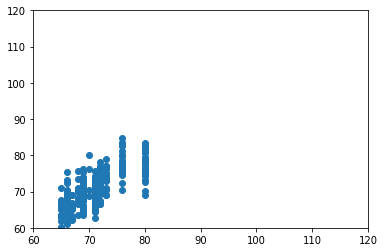

R of SBP    = 0.891591993067498
MAE of DBP  = 5.86367841200395 +/- 7.354745397389712
RMSE of SBP = 7.368135237138437


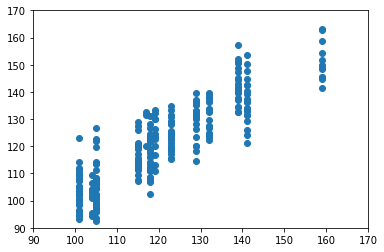

In [13]:
# import matplotlib.pyplot as plt
# from scipy.stats import ttest_ind

pred = test_predictions[0]
label = (np.array(test_labels))

DBP_pred = pred[:,1]
DBP_label = label[:,1]
DBP_R = np.corrcoef(DBP_pred, DBP_label)
DBP_MAE = (np.absolute((DBP_pred - DBP_label))).mean()
DBP_MAE_std = np.std((DBP_pred - DBP_label))
DBP_RMSE = np.sqrt(((DBP_pred - DBP_label) ** 2).mean()) 
# t_DBP, p_DBP = ttest_ind(DBP_pred, DBP_label)
print("R of DBP    = {}".format(DBP_R[0][1]))
# print("p of DBP    = {}".format(p_DBP))
print("MAE of DBP  = {} +/- {}".format(DBP_MAE, DBP_MAE_std))
print("RMSE of DBP = {}\n".format(DBP_RMSE))
plt.plot(DBP_label, DBP_pred, "o")
axes = plt.gca()
axes.set_xlim([60,120])
axes.set_ylim([60,120])
plt.show()

SBP_pred = pred[:,0]
SBP_label = label[:,0]
SBP_R = np.corrcoef(SBP_pred, SBP_label)
SBP_MAE = (np.absolute((SBP_pred - SBP_label))).mean()
SBP_MAE_std = np.std((SBP_pred - SBP_label))
SBP_RMSE = np.sqrt(((SBP_pred - SBP_label) ** 2).mean())
print("R of SBP    = {}".format(SBP_R[0][1]))
print("MAE of DBP  = {} +/- {}".format(SBP_MAE, SBP_MAE_std))
print("RMSE of SBP = {}".format(SBP_RMSE))
plt.plot(SBP_label, SBP_pred, "o")
axes = plt.gca()
axes.set_xlim([90,170])
axes.set_ylim([90,170])
plt.show()

## Scatter plot of the results across DBP and SBP

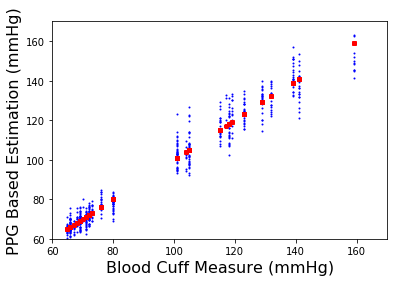

In [14]:
comb_pred  = np.concatenate((DBP_pred, SBP_pred))
comb_label = np.concatenate((DBP_label, SBP_label))
plt.plot(comb_label, comb_pred, "bo", markersize=1)
plt.plot(comb_label, comb_label, "ro", markersize=4)
plt.xlabel('Blood Cuff Measure (mmHg)', fontsize = '16')
plt.ylabel('PPG Based Estimation (mmHg)', fontsize = '16')
plt.savefig("BP_fitting_7s.svg", format="svg", bbox_inches='tight')
axes = plt.gca()
axes.set_xlim([60,170])
axes.set_ylim([60,170])

plt.show()


## Bland-Altman analysis across DBP and SBP

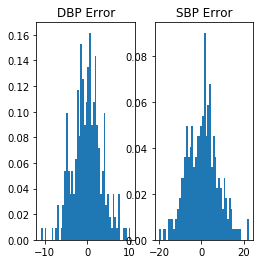

In [15]:
# plt.subplot(131)
# plt.plot(comb_label, diff_pred_label, "bo", markersize=1)
# axes = plt.gca()
# axes.set_xlim([60,170])
# axes.set_ylim([-60,60])
# plt.title("")


diff_pred_label_DBP = DBP_pred - DBP_label
diff_pred_label_SBP = SBP_pred - SBP_label
plt.subplot(131)
plt.hist(diff_pred_label_DBP, 50, normed=1, histtype='stepfilled')  # arguments are passed to np.histogram
plt.title("DBP Error")
plt.subplot(132)
plt.hist(diff_pred_label_SBP, 50, normed=1, histtype='stepfilled')  # arguments are passed to np.histogram
plt.title("SBP Error")
plt.savefig("BP_fitting_7s_error.svg", format="svg", bbox_inches='tight')
plt.show()

In [16]:
total_DBP = diff_pred_label_DBP.size
small_than_05_DBP = sum(i < 5 for i in diff_pred_label_DBP)
small_than_10_DBP = sum(i < 10 for i in diff_pred_label_DBP)
small_than_15_DBP = sum(i < 15 for i in diff_pred_label_DBP)
percentage_small_than_05_DBP = small_than_05_DBP / total_DBP
percentage_small_than_10_DBP = small_than_10_DBP / total_DBP
percentage_small_than_15_DBP = small_than_15_DBP / total_DBP

total_SBP = diff_pred_label_SBP.size
small_than_05_SBP = sum(i < 5 for i in diff_pred_label_SBP)
small_than_10_SBP = sum(i < 10 for i in diff_pred_label_SBP)
small_than_15_SBP = sum(i < 15 for i in diff_pred_label_SBP)
percentage_small_than_05_SBP = small_than_05_SBP / total_SBP
percentage_small_than_10_SBP = small_than_10_SBP / total_SBP
percentage_small_than_15_SBP = small_than_15_SBP / total_SBP

print ("DBP < 5 = {:.2f}%, < 10 = {:.2f}%, < 15 = {:.2f}%.\n".format(percentage_small_than_05_DBP*100, percentage_small_than_10_DBP*100, percentage_small_than_15_DBP*100))
print ("SBP < 5 = {:.2f}%, < 10 = {:.2f}%, < 15 = {:.2f}%.\n".format(percentage_small_than_05_SBP*100, percentage_small_than_10_SBP*100, percentage_small_than_15_SBP*100))

DBP < 5 = 93.18%, < 10 = 99.62%, < 15 = 100.00%.

SBP < 5 = 74.24%, < 10 = 89.39%, < 15 = 97.73%.



In [ ]:
import lz_BlandAltman_correlation as BA
diff_pred_label = comb_pred - comb_label
# plt.subplot(131)
# plt.plot(comb_label, diff_pred_label, "bo", markersize=1)
# axes = plt.gca()
# axes.set_xlim([60,170])
# axes.set_ylim([-60,60])
# plt.title("")

# plt.subplot(132)
# plt.hist(diff_pred_label, bins='auto')  # arguments are passed to np.histogram
# plt.title("Histogram of Difference")

# plt.subplot(133)
BA.lz_BlandAltmanPlot(comb_pred, comb_label)
plt.title("Bland-Altman")
axes = plt.gca()
axes.set_xlim([60,170])

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 24,
        }

Difference = comb_pred-comb_label
mean_diff = np.mean(Difference)
Std_diff = np.std(Difference)
upper_limit = mean_diff + 1.96*Std_diff
lower_limit = mean_diff - 1.96*Std_diff
plt.text(165, mean_diff, 'Mean Diff = %0.6s' % mean_diff, fontdict=font)
plt.text(165, upper_limit, '+1.96SD = %0.6s' % upper_limit, fontdict=font)
plt.text(165, lower_limit, '-1.96SD = %0.6s' % lower_limit, fontdict=font)

plt.show()

In [ ]:
%run lz_BlandAltman_correlation

## RMSE for individual BP points

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mean_err_uniq_est = []
std_err_uniq_est  = []
rmse_uniq_est     = []
uniq_label_list = np.unique(comb_label)
for uniq_label in uniq_label_list:
    mean_err_uniq_est.append(np.mean(Difference[comb_label == uniq_label]))
    std_err_uniq_est.append(np.std(Difference[comb_label == uniq_label]))
    rmse_uniq_est.append(sqrt(mean_squared_error(comb_pred[comb_label == uniq_label], comb_label[comb_label == uniq_label])))

plt.plot(uniq_label_list, rmse_uniq_est, 'o')
plt.xlabel('Blood Cuff Measure (mmHg)', fontsize = '16')
plt.ylabel('RMSE(mmHg)', fontsize = '16')
plt.show()
np.mean(rmse_uniq_est)